
# TODO

1. [x] P1: random sample 10% by search_id & validate it -> 
2. [ ] P1: position Benchmark
2. [ ] how to cope with `gross_bookings_usd`
2. [ ] P1: Market, e.g. hotel price, varies in different cities, at 
different times. -> Tree-based consider one feature one time 
    1. Our solution: normalize hotel and competitor descriptions 
    with respect to different indicators 
    [x] srch_id: compare the quality of hotels in the impression list
    [ ] prop_id: compare the quality of hotels in their own history
    [ ] srch_des_id: compare the quality of hotels in a given region
    [ ] month: compare the quality of hotels in a given time
    [ ] srch_book_window: compare the quality of hotels for a given 
    booking window
2. feature todo
    1. [ ] user features
    2. [x] P1: destination features
        1. [x] srch_dest_id
    2. [ ] item features
        1. [ ] if propsize< 10 -> use average features
        2. [x] mean, std, median of numeric features
        2. [ ] P1: item ctr, item cvr: ctr, cvr of item  -> overfit, need more validation
            1. [ ] except current record  (overfit??) -> hotel quality??
        4. [ ] mean value of categoriacal features 
    2. [x] context feature 
        1. [x] time
        2. [x] P1: whether domestic: visitor_location_country_id == prop_country_id
            1. prop_country_id' 'srch_destination_id' -> same values??
    3. [x] P1: Listwise features
        1. [x] price 
            1. [x] price_percentile, rank_percentile
        2. [x] prop_review_rate, prop_star
        3. [ ] only promotion ??
    4. [ ] Others
        2. [ ] price diff?? price_usd VS gross_booking_usd
        4. [ ] how to code random_bool
        6. [ ] item position features?? -> xgb no possible, should try for deepFM
        7. [ ] ctr in different dimensions
    5. [ ] P2: positon CTR (problem encountered) -> overfit, need more validation
    5. [ ] P1: match feature -> reduce dimension ???
        1. [ ] users history rate - curent rate?
        2. [ ] hist_starrating diff
    7. [ ] P2: dense feature -> bin?
        1. no need to bin: prop_starrating, prop_review_score, srch_length_of_stay, srch_adults_count, srch_children_count, srch_room_count
    8. [ ] P1: big fraction of null
        1. [ ] user history feature -> 94% 
             1. [ ] new or old users??
        2. prop_log_historical_price -> replace 0 with biggest values
        3. [ ] hotel info -> missing value -> not click
            1. fill with worst case
    6. [ ] P1: categorical features
        1. [ ] competitor infor -> encode null -> categorical features
        9. [ ] reduce feature number -> ['site_id', 'visitor_location_country_id', 'prop_country_id', 'srch_destination_id']
        10. [ ] <10% of prop_id only have 1-2 sample -> item feature not enough
        13. [ ] combine `comp1_inv` and `comp1_rate` to reduce dimension
        14. [ ] one hot -> two cols??
    8. combination of srch_destination_id and prop_id -> the quality of search result ???
    7. [ ] P3: skewed data -> what to do for regression
        1. [ ] downsample negative sample??



# Module 

In [59]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

import pandas as pd
import os
import numpy as np

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

from src.utils.plot_utils import count_plot, plot_feature_importances, value_count_stats, stats_plot
from src.FeatureCreator.utils import get_label
# from scripts.train_config import position_feature_path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Config 

In [83]:
debug = False
# if debug:
debug_num = 1000
# else:
#     sample_num = -1
# data_dir = '../raw_data/'

# big_data_dir = 'data/big_data'
# small_data_dir = 'data/small_data'

data_dir = '../data/small_data/raw_data/0503_lgbmranker_v2/'
# data_dir = '../data/big_data/'



# if big_data:
#      = os.path.join(big_data_dir, 'raw_data')
#     model_dir = 'model_training/big_data/production'
# else:
#     raw_data_path = os.path.join(small_data_dir, 'raw_data')
#     model_dir = 'model_training/small_data/production'
# result_dir = '../result/'

submission_cols =  ['SearchId','PropertyId']
search_id = 'srch_id'
prop_id = 'prop_id'
regression_label = 'label'

base_dir = '../'


# Feature cols 

In [84]:
sparse_features = [
    'site_id'
    , 'visitor_location_country_id'
    , 'prop_country_id'
    , 'srch_destination_id'
    , 'prop_brand_bool'
    , 'promotion_flag'
    , 'srch_saturday_night_bool'
    , 'random_bool'
    , 'comp1_rate'
    , 'comp1_inv'
    , 'comp2_rate'
    , 'comp2_inv'
    , 'comp3_rate'
    , 'comp3_inv'
    , 'comp4_rate'
    , 'comp4_inv'
    , 'comp5_rate'
    , 'comp5_inv'
    , 'comp6_rate'
    , 'comp6_inv'
    , 'comp7_rate'
    , 'comp7_inv'
    , 'comp8_rate'
    , 'comp8_inv'
    
    # new feature 
    , 'day'
    , 'hour'
    , 'dayofweek'
    
]
dense_features = [
    'visitor_hist_starrating'
    , 'visitor_hist_adr_usd'
    , 'prop_starrating'
    , 'prop_review_score'
    , 'prop_location_score1'
    , 'prop_location_score2'
    , 'prop_log_historical_price'
    , 'price_usd'
    , 'srch_length_of_stay'
    , 'srch_booking_window'
    , 'srch_adults_count'
    , 'srch_children_count'
    , 'srch_room_count'
    , 'srch_query_affinity_score'
    , 'orig_destination_distance'
    , 'comp1_rate_percent_diff'
    , 'comp2_rate_percent_diff'
    , 'comp3_rate_percent_diff'
    , 'comp4_rate_percent_diff'
    , 'comp5_rate_percent_diff'
    , 'comp6_rate_percent_diff'
    , 'comp7_rate_percent_diff'
    , 'comp8_rate_percent_diff'
    
]



user_features = [
    'visitor_location_country_id'
    
    
]

user_item_features = [
    'visitor_hist_starrating'
    , 'visitor_hist_adr_usd'
    , 
]

item_features = [
    
    'prop_country_id'
    , 'prop_starrating'
    , 'prop_review_score'
    , 'prop_brand_bool'
    , 'prop_log_historical_price'
    , 'price_usd'
    , 'srch_query_affinity_score'
    , 
]

context_features = [
    'site_id'
    , 'promotion_flag'
    , 'srch_length_of_stay'
    , 'srch_booking_window'
    , 'srch_adults_count'
    , 'prop_location_score1'
    , 'prop_location_score2'
    , 'srch_children_count'
    , 'srch_room_count'
    , 'orig_destination_distance'
    , 'random_bool'
    , 'comp1_rate'
    , 'comp1_inv'
    , 'comp1_rate_percent_diff'
    , 'comp2_rate'
    , 'comp2_inv'
    , 'comp2_rate_percent_diff'
    , 'comp3_rate'
    , 'comp3_inv'
    , 'comp3_rate_percent_diff'
    , 'comp4_rate'
    , 'comp4_inv'
    , 'comp4_rate_percent_diff'
    , 'comp5_rate'
    , 'comp5_inv'
    , 'comp5_rate_percent_diff'
    , 'comp6_rate'
    , 'comp6_inv'
    , 'comp6_rate_percent_diff'
    , 'comp7_rate'
    , 'comp7_inv'
    , 'comp7_rate_percent_diff'
    , 'comp8_rate'
    , 'comp8_inv'
    , 'comp8_rate_percent_diff'
    , 'srch_destination_id'
    , 'srch_saturday_night_bool'
        # new feature 
    , 'day'
    , 'hour'
    , 'dayofweek'
]

In [85]:
one_hot_features = [
	# category reduce
	'site_id', 
	'visitor_location_country_id',
	 'prop_country_id', 
	 'srch_destination_id'
	 , 

	# direct 

]

one_hot_TBD = [
	'comp7_inv'
	, 
]


# dense_to_bins 

In [86]:
feature_col1 = set(dense_features + sparse_features)
feature_col2 = set(user_features+item_features+context_features+user_item_features)

In [87]:
assert len(feature_col1) == len(feature_col2), f"{feature_col2-feature_col1}; {feature_col1-feature_col2}"

# Data 

In [88]:
data_dir

'../data/small_data/raw_data/0503_lgbmranker_v2/'

In [90]:

train_df = pd.read_pickle(os.path.join(data_dir, 'train_df.pkl'))
test_df = pd.read_pickle(os.path.join(data_dir, 'test_df.pkl'))

In [91]:
# ! ls ../data/small_data/raw_data/0503_lgbmranker_v2/

In [92]:
# pd.concat([train_df['date_time'], test_df['date_time']])

In [93]:
print(f"train dimension: {train_df.shape}")
print(f"test dimension: {test_df.shape}")
print(f"Unique cols for train_df: {set(train_df.columns)-set(test_df.columns)}")
print(f"Unique cols for test_df: {set(test_df.columns)-set(train_df.columns)}")


train dimension: (635157, 135)
test dimension: (197996, 135)
Unique cols for train_df: set()
Unique cols for test_df: set()


In [94]:
train_df[regression_label] = train_df.apply(lambda row: get_label(row), axis=1)

In [95]:
# min_date = min(pd.concat([train_df['date_time'], test_df['date_time']]))[:10]
# # test_min_date = min(train_df['date_time'])[:10]
# train_min_date = min(train_df['date_time'])[:10]
# train_max_date = max(train_df['date_time'])[:10]
# test_min_date = min(test_df['date_time'])[:10]
# test_max_date = max(test_df['date_time'])[:10]
# print(f"min date: {min_date}")
# print(f"train min date: [{train_min_date}, {train_max_date}]")
# print(f"test min date: [{test_min_date}, {test_max_date}]")

In [96]:

# if debug:
#     train = train_df.sample(debug_num)
#     test = test_df.sample(debug_num)
# else:
#     train = train_df.copy()
#     test = test_df.copy()

In [97]:
# train.info()

# Basic Info 

In [98]:
max(train_df['date_time'])

Timestamp('2013-06-30 23:57:52')

In [99]:
min(train_df['date_time'])

Timestamp('2012-11-01 00:12:06')

# Expected Position 

In [100]:
train_df.columns

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score',
       ...
       'month', 'hour', 'dayofweek', 'whether_domestic',
       'price_usd_percentile', 'price_usd_rank_percentile',
       'prop_starrating_percentile', 'prop_starrating_rank_percentile',
       'prop_review_score_percentile', 'prop_review_score_rank_percentile'],
      dtype='object', length=135)

In [101]:
[col for col in train_df.columns if 'id' in col]

['srch_id',
 'site_id',
 'visitor_location_country_id',
 'prop_country_id',
 'prop_id',
 'srch_destination_id',
 'prop_id_size',
 'prop_id_mean_visitor_hist_starrating',
 'prop_id_std_visitor_hist_starrating',
 'prop_id_median_visitor_hist_starrating',
 'prop_id_mean_visitor_hist_adr_usd',
 'prop_id_std_visitor_hist_adr_usd',
 'prop_id_median_visitor_hist_adr_usd',
 'prop_id_mean_prop_starrating',
 'prop_id_std_prop_starrating',
 'prop_id_median_prop_starrating',
 'prop_id_mean_prop_review_score',
 'prop_id_std_prop_review_score',
 'prop_id_median_prop_review_score',
 'prop_id_mean_prop_location_score1',
 'prop_id_std_prop_location_score1',
 'prop_id_median_prop_location_score1',
 'prop_id_mean_prop_location_score2',
 'prop_id_std_prop_location_score2',
 'prop_id_median_prop_location_score2',
 'prop_id_mean_prop_log_historical_price',
 'prop_id_std_prop_log_historical_price',
 'prop_id_median_prop_log_historical_price',
 'prop_id_mean_price_usd',
 'prop_id_std_price_usd',
 'prop_id_med

In [102]:

# rename_map4 = {
#     "booking_bool": prefix + 'total_cnt'
# }
# click_count = self.train.groupby(item_id)['click_bool'].sum().reset_index().rename(columns=rename_map2)



groupby = ['prop_id', 'srch_destination_id']

def get_expected_position(groupby):
    target_col_name = '_'.join(groupby) + '_positoin'
    target_df = train_df.copy()
    stats_df = target_df.groupby(groupby)['position'].mean().reset_index().rename(columns={'position': target_col_name})
    return stats_df

In [103]:
stats1 = get_expected_position(groupby=['prop_id', 'srch_destination_id'])
stats1.head()

prop_id  srch_destination_id  prop_id_srch_destination_id_positoin
0        1                 6475                             26.285714
1        1                14215                             21.000000
2        1                15587                             36.000000
3        1                26664                             34.000000
4        2                 1989                             10.000000

In [104]:
stats2 = get_expected_position(groupby=['prop_id'])
stats2.head()

prop_id  prop_id_positoin
0        1         27.500000
1        2         10.000000
2        3         17.384615
3        4         14.000000
4        5         25.000000

In [105]:
target_data_dir = '../data/small_data/offline_features'

In [106]:
file1 = os.path.join(target_data_dir, 'prob_destination_position.csv')
file2 = os.path.join(target_data_dir, 'prob_position.csv')

In [107]:
stats1.to_csv(file1, index=False)
stats2.to_csv(file2, index=False)

# COEC 

In [108]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 635157 entries, 0 to 635156
Columns: 135 entries, srch_id to prop_review_score_rank_percentile
dtypes: datetime64[ns](1), float16(26), float32(8), float64(73), int16(4), int32(2), int64(8), int8(13)
memory usage: 470.7 MB


In [110]:
train_df['label'].value_counts()

0    606744
5     17557
2     10856
Name: label, dtype: int64

In [136]:
# BOEB 

num_threshold = 3
target_col = 'BOEB'
target_label = 5
groupby = ['prop_id']

def get_coec(num_threshold, target_col, target_label, groupby):
    seg_df = train_df[train_df['label']==target_label]
    final_df = seg_df.groupby(groupby)['label'].count().reset_index().rename(columns={'label': 'cnt'}).sort_values('cnt', ascending=False)
    final_df[target_col] = final_df['cnt']/len(seg_df)
    final_df = final_df[final_df['cnt']>=num_threshold]
    final_df.drop('cnt', axis=1, inplace=True)
    return final_df
    # (seg_df.groupby(groupby)['label'].count()/len(seg_df)).reset_index().sort_values('label', ascending=False)

In [137]:
boeb_df = get_coec(num_threshold=3, target_col='BOEB', target_label=5, groupby=['prop_id'])

In [139]:
coec_df = get_coec(num_threshold=3, target_col='COEC', target_label=2, groupby=['prop_id'])

In [143]:
target_data_dir

'../data/small_data/offline_features'

In [144]:
boeb_df.to_csv(os.path.join(target_data_dir, 'boeb.csv'), index=False)
coec_df.to_csv(os.path.join(target_data_dir, 'coec.csv'), index=False)

## Target variable

### click 

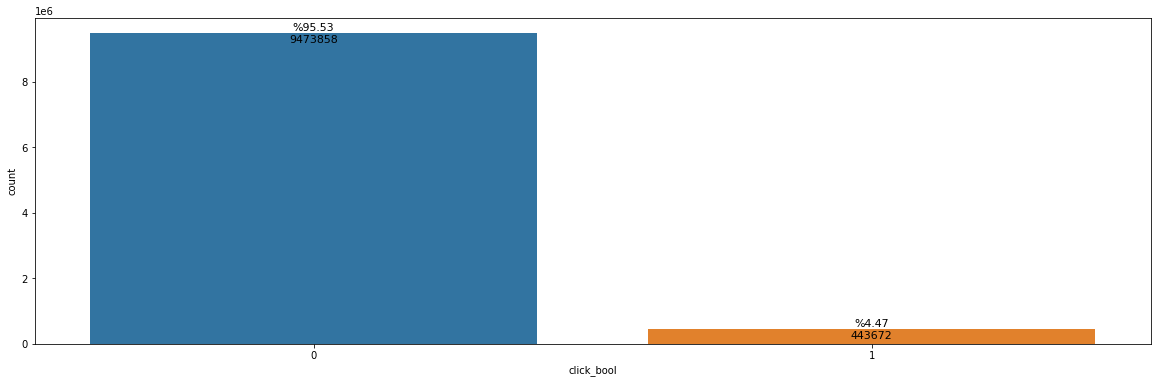

In [132]:
count_plot(train, 'click_bool')

### book

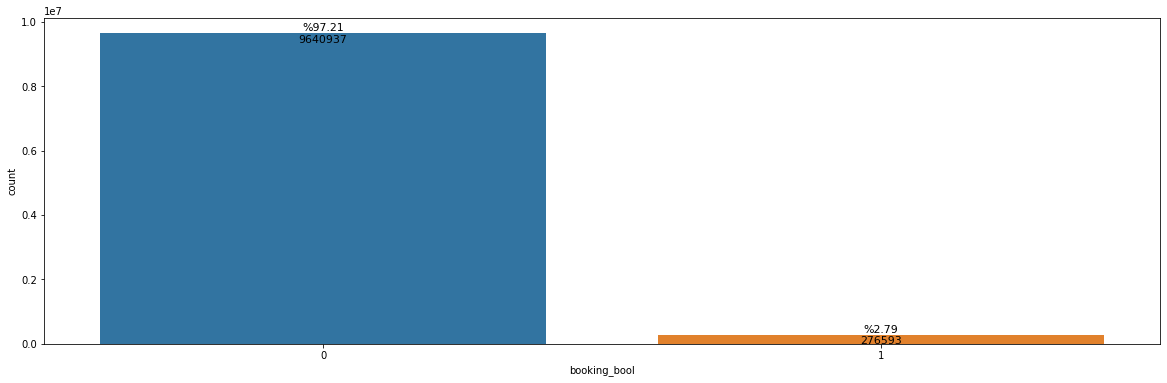

In [133]:
count_plot(train, 'booking_bool')

### Regression Target 

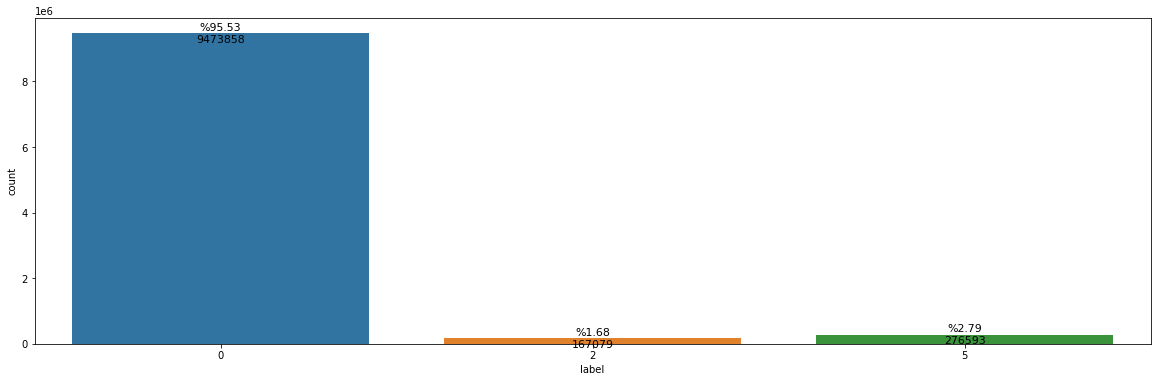

In [157]:
count_plot(train, regression_label)

## data time 

In [134]:
def get_date_info(df):
    df['date_time'] = pd.to_datetime(df['date_time'])
    df['year'] = df['date_time'].dt.year
    df['day'] = df['date_time'].dt.day
    df['hour'] = df['date_time'].dt.hour
    df['dayofweek'] = df['date_time'].dt.dayofweek
    df['day_from_0'] = (df['date_time'] - pd.to_datetime(min_date)).dt.days
    return df

In [135]:
train = get_date_info(train)

In [136]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9917530 entries, 0 to 9917529
Data columns (total 59 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   srch_id                      int64         
 1   date_time                    datetime64[ns]
 2   site_id                      int64         
 3   visitor_location_country_id  int64         
 4   visitor_hist_starrating      float64       
 5   visitor_hist_adr_usd         float64       
 6   prop_country_id              int64         
 7   prop_id                      int64         
 8   prop_starrating              int64         
 9   prop_review_score            float64       
 10  prop_brand_bool              int64         
 11  prop_location_score1         float64       
 12  prop_location_score2         float64       
 13  prop_log_historical_price    float64       
 14  position                     int64         
 15  price_usd                    float64       
 16  

In [138]:
# train['day_from_0'].

In [139]:
# count_plot(df=train, col='day_from_0')

## Null value 

In [140]:
train.isna().sum()/train.shape[0]

srch_id                        0.000000
date_time                      0.000000
site_id                        0.000000
visitor_location_country_id    0.000000
visitor_hist_starrating        0.949050
visitor_hist_adr_usd           0.948817
prop_country_id                0.000000
prop_id                        0.000000
prop_starrating                0.000000
prop_review_score              0.001475
prop_brand_bool                0.000000
prop_location_score1           0.000000
prop_location_score2           0.219649
prop_log_historical_price      0.000000
position                       0.000000
price_usd                      0.000000
promotion_flag                 0.000000
srch_destination_id            0.000000
srch_length_of_stay            0.000000
srch_booking_window            0.000000
srch_adults_count              0.000000
srch_children_count            0.000000
srch_room_count                0.000000
srch_saturday_night_bool       0.000000
srch_query_affinity_score      0.935915


## srch_id

### train  

In [169]:

df = train
stats = df.groupby('srch_id')['date_time'].count().reset_index()
print(stats['date_time'].describe([0.05*i for i in range(20)]))


count    399344.000000
mean         24.834554
std           9.114234
min           5.000000
0%            5.000000
5%            7.000000
10%           9.000000
15%          12.000000
20%          15.000000
25%          18.000000
30%          21.000000
35%          24.000000
40%          26.000000
45%          28.000000
50%          29.000000
55%          30.000000
60%          31.000000
65%          31.000000
70%          32.000000
75%          32.000000
80%          32.000000
85%          33.000000
90%          33.000000
95%          34.000000
max          38.000000
Name: date_time, dtype: float64


### test

In [170]:

df = test
stats = df.groupby('srch_id')['date_time'].count().reset_index()
print(stats['date_time'].describe([0.05*i for i in range(20)]))


count    266230.000000
mean         24.875593
std           9.103166
min           5.000000
0%            5.000000
5%            7.000000
10%           9.000000
15%          12.000000
20%          15.000000
25%          18.000000
30%          21.000000
35%          24.000000
40%          26.000000
45%          28.000000
50%          29.000000
55%          30.000000
60%          31.000000
65%          31.000000
70%          32.000000
75%          32.000000
80%          32.000000
85%          33.000000
90%          33.000000
95%          34.000000
max          37.000000
Name: date_time, dtype: float64


##  prop_id

In [171]:

df = train
stats = df.groupby('prop_id')['date_time'].count().reset_index()
print(stats['date_time'].describe([0.05*i for i in range(20)]))


count    136886.000000
mean         72.451018
std         159.768293
min           1.000000
0%            1.000000
5%            1.000000
10%           2.000000
15%           3.000000
20%           5.000000
25%           6.000000
30%           8.000000
35%          10.000000
40%          13.000000
45%          16.000000
50%          21.000000
55%          26.000000
60%          34.000000
65%          44.000000
70%          57.000000
75%          74.000000
80%          98.000000
85%         131.000000
90%         184.000000
95%         300.000000
max        4733.000000
Name: date_time, dtype: float64


## TODO Prop_id overlap for train and test

## TODO price_usd  VS gross_booking_usd

# Genral Analysis of Features

## Sparse feature 

In [141]:
sparse_features

['site_id',
 'visitor_location_country_id',
 'prop_country_id',
 'srch_destination_id',
 'prop_brand_bool',
 'promotion_flag',
 'srch_saturday_night_bool',
 'random_bool',
 'comp1_rate',
 'comp1_inv',
 'comp2_rate',
 'comp2_inv',
 'comp3_rate',
 'comp3_inv',
 'comp4_rate',
 'comp4_inv',
 'comp5_rate',
 'comp5_inv',
 'comp6_rate',
 'comp6_inv',
 'comp7_rate',
 'comp7_inv',
 'comp8_rate',
 'comp8_inv',
 'day',
 'hour',
 'dayofweek']

col: site_id
Unique number: 34

Top 5 (value: number):

   site_id  sample_num      frac    cumsum
0        5     6164803  0.621607  0.621607
1       14      964105  0.097212  0.718819
2       15      618620  0.062376  0.781195
3       24      475893  0.047985  0.829180
4       32      355805  0.035876  0.865057

Bottom 5 (value: number):

    site_id  sample_num      frac    cumsum
29        3        7015  0.000707  0.999347
30        6        4807  0.000485  0.999832
31       33        1355  0.000137  0.999969
32       20         248  0.000025  0.999994
33        8          62  0.000006  1.000000


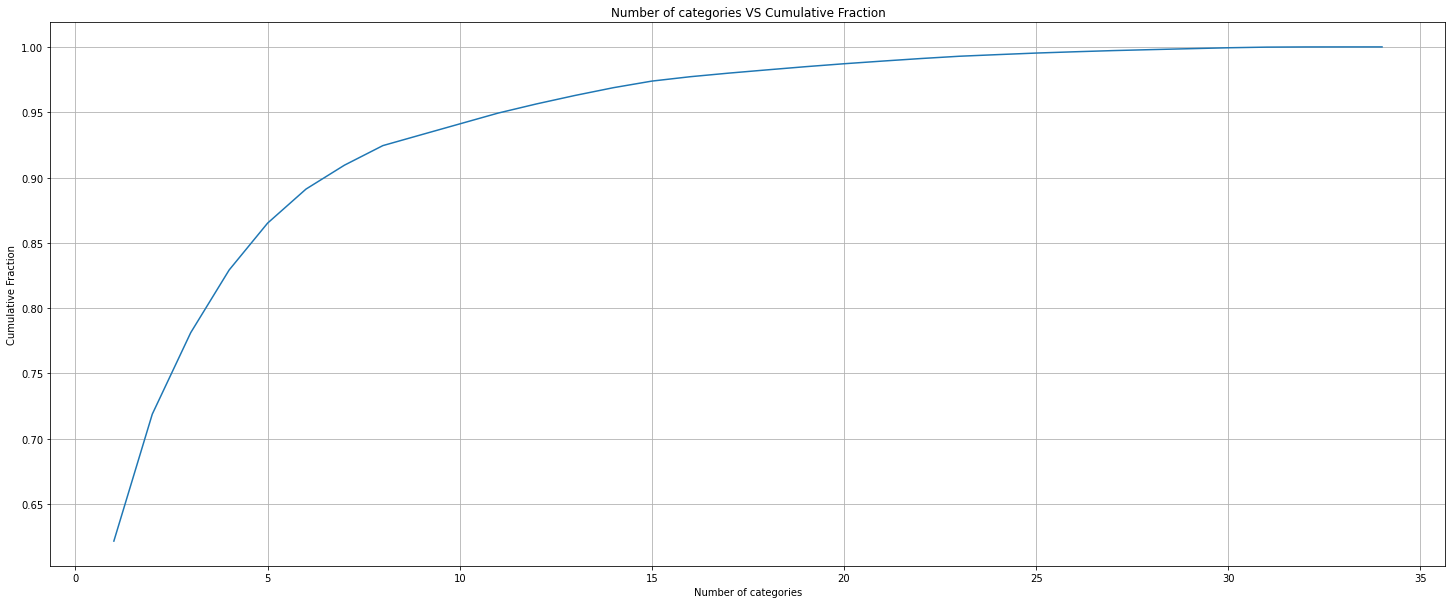

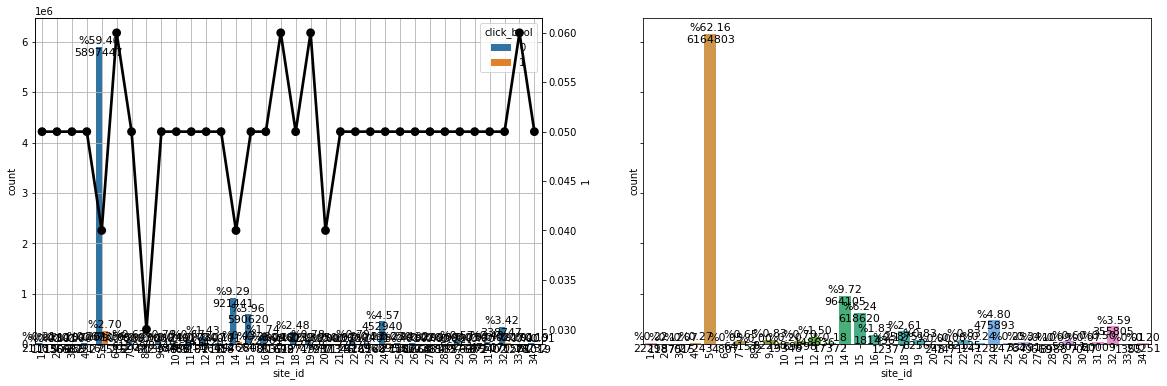

col: visitor_location_country_id
Unique number: 218

Top 5 (value: number):

   visitor_location_country_id  sample_num      frac    cumsum
0                          219     5778805  0.582686  0.582686
1                          100      990487  0.099872  0.682558
2                           55      580072  0.058490  0.741048
3                          216      434568  0.043818  0.784866
4                          220      350433  0.035335  0.820201

Bottom 5 (value: number):

     visitor_location_country_id  sample_num      frac    cumsum
213                          144          31  0.000003  0.999988
214                          198          30  0.000003  0.999991
215                          146          30  0.000003  0.999994
216                           24          29  0.000003  0.999997
217                            8          27  0.000003  1.000000


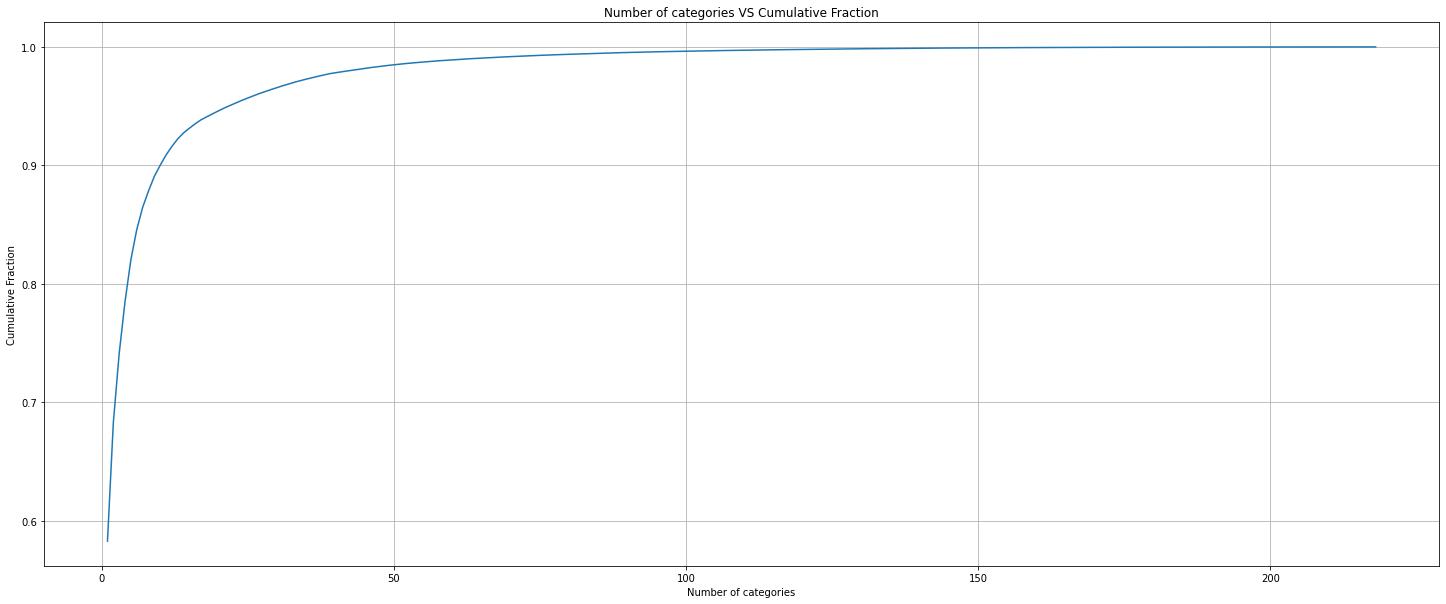

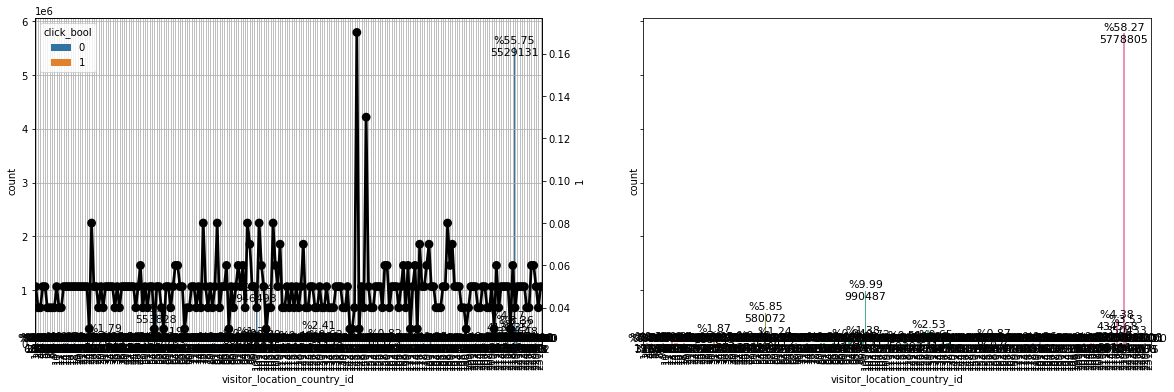

col: prop_country_id
Unique number: 172

Top 5 (value: number):

   prop_country_id  sample_num      frac    cumsum
0              219     6052976  0.610331  0.610331
1              100      622810  0.062799  0.673130
2               55      376219  0.037935  0.711065
3               31      309434  0.031201  0.742265
4               99      268393  0.027062  0.769328

Bottom 5 (value: number):

     prop_country_id  sample_num          frac    cumsum
167               79          16  1.613305e-06  0.999996
168               87          13  1.310810e-06  0.999997
169                7          10  1.008316e-06  0.999998
170              204          10  1.008316e-06  0.999999
171              165           7  7.058209e-07  1.000000


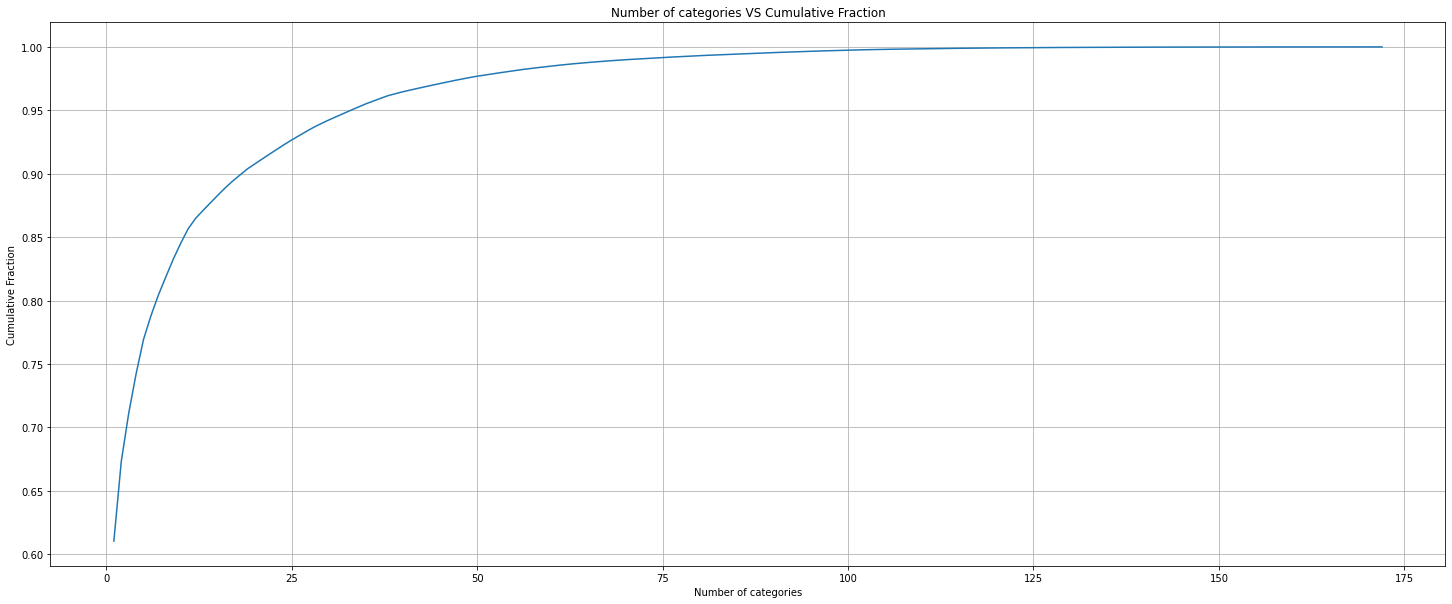

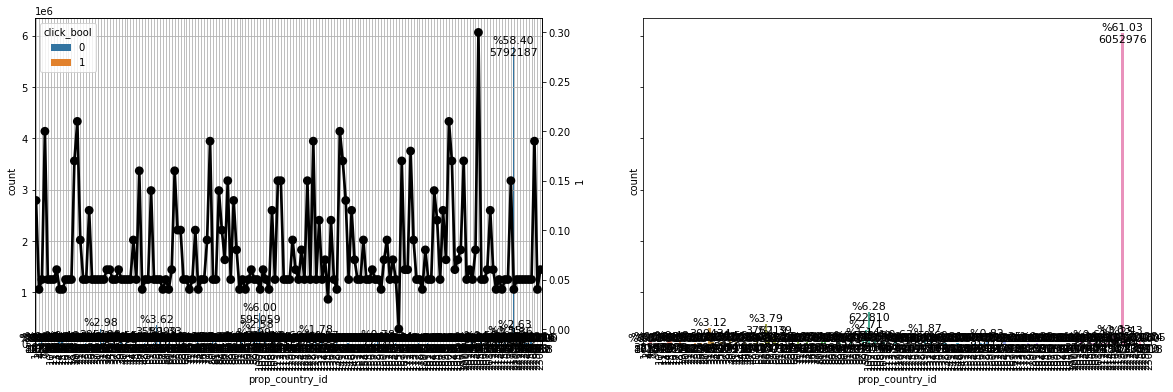

col: srch_destination_id
Unique number: 23715

Top 5 (value: number):

   srch_destination_id  sample_num      frac    cumsum
0                 8192      140182  0.014135  0.014135
1                 4562      114350  0.011530  0.025665
2                 9402       82842  0.008353  0.034018
3                10979       69369  0.006995  0.041013
4                 8347       64198  0.006473  0.047486

Bottom 5 (value: number):

       srch_destination_id  sample_num          frac    cumsum
23710                21110           5  5.041578e-07  0.999998
23711                 4104           5  5.041578e-07  0.999998
23712                 4719           5  5.041578e-07  0.999999
23713                 4643           5  5.041578e-07  0.999999
23714                25011           5  5.041578e-07  1.000000


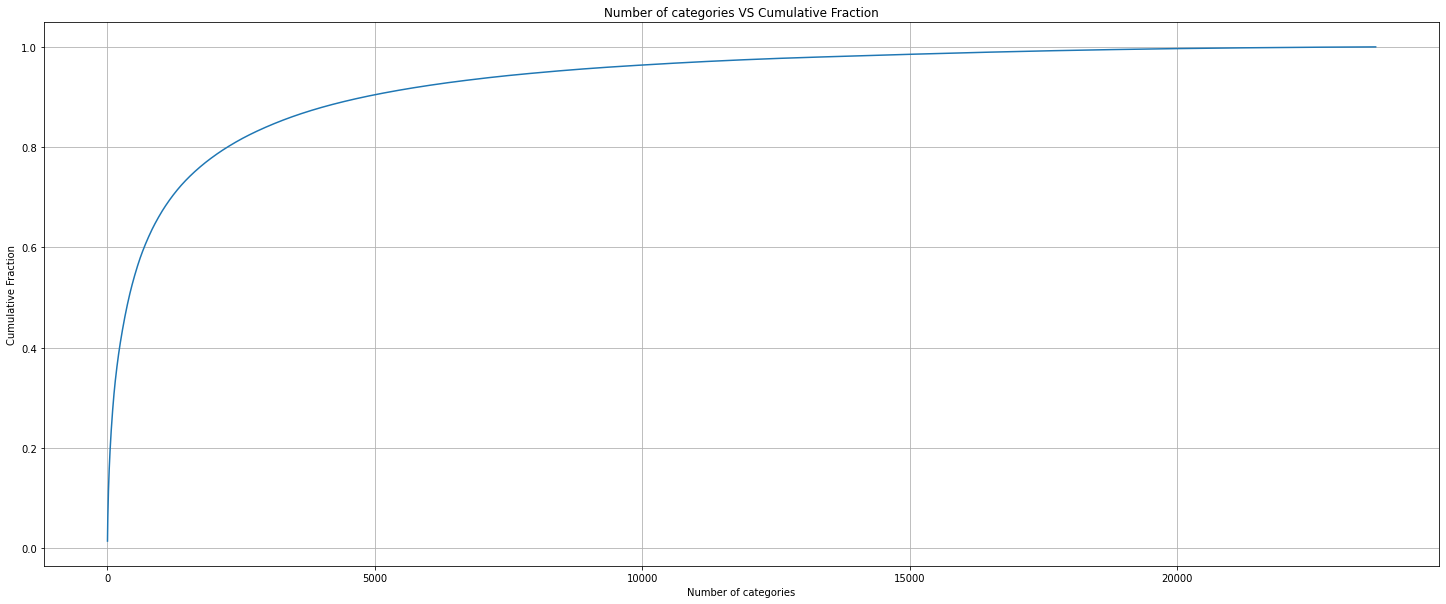

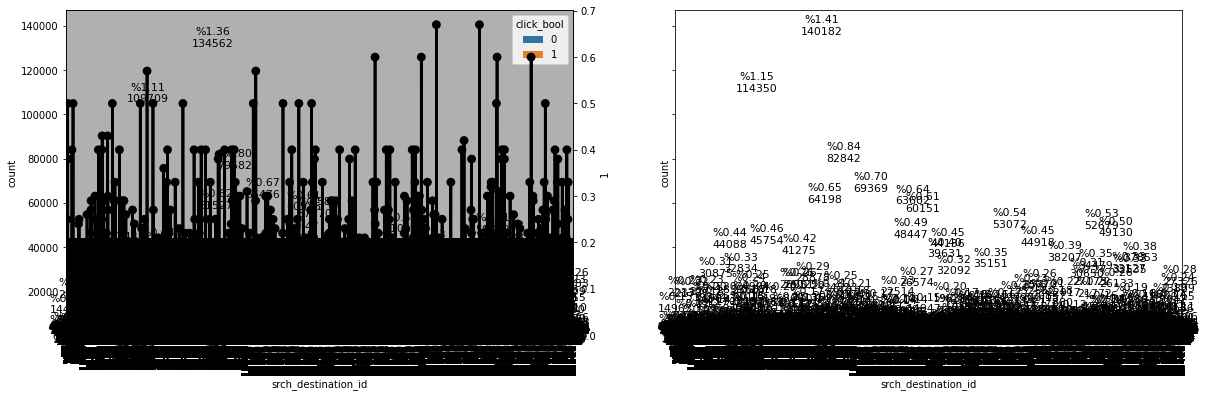

col: prop_brand_bool
Unique number: 2

Top 5 (value: number):

   prop_brand_bool  sample_num      frac    cumsum
0                1     6290731  0.634304  0.634304
1                0     3626799  0.365696  1.000000

Bottom 5 (value: number):

   prop_brand_bool  sample_num      frac    cumsum
0                1     6290731  0.634304  0.634304
1                0     3626799  0.365696  1.000000


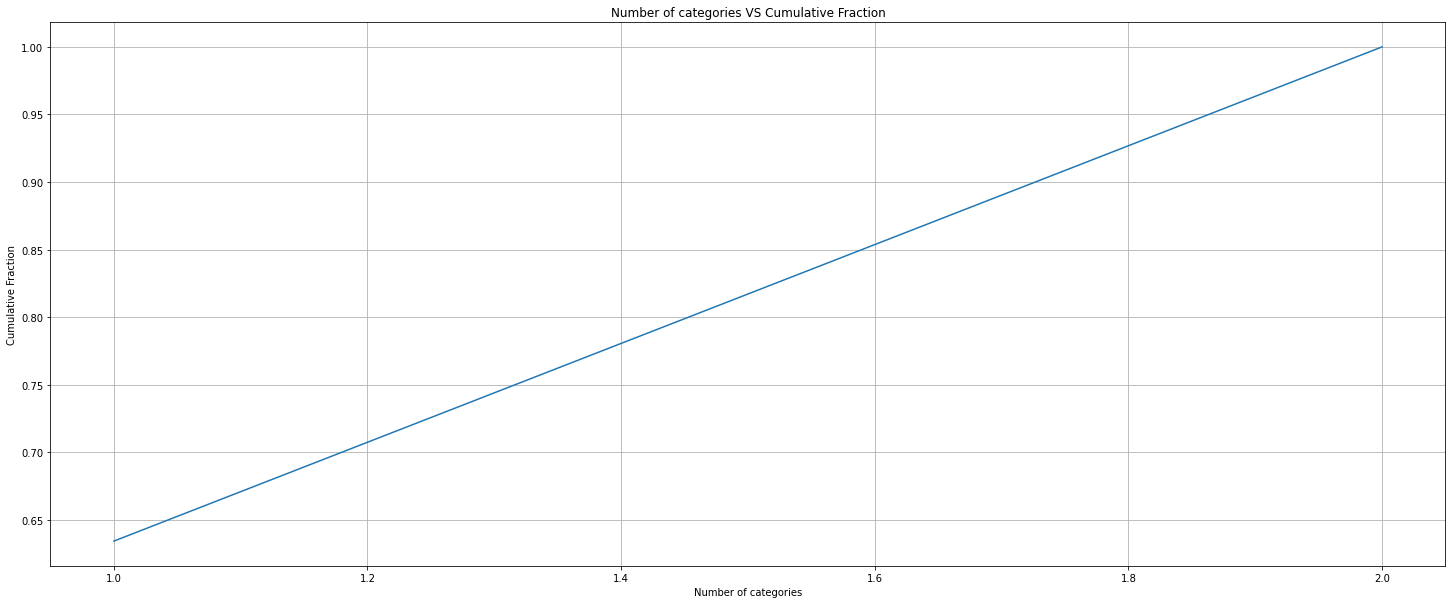

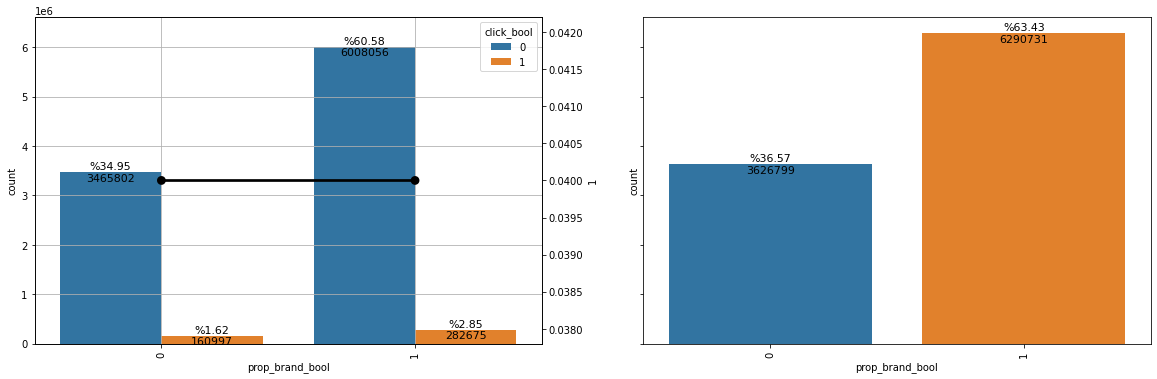

col: promotion_flag
Unique number: 2

Top 5 (value: number):

   promotion_flag  sample_num      frac    cumsum
0               0     7777708  0.784238  0.784238
1               1     2139822  0.215762  1.000000

Bottom 5 (value: number):

   promotion_flag  sample_num      frac    cumsum
0               0     7777708  0.784238  0.784238
1               1     2139822  0.215762  1.000000


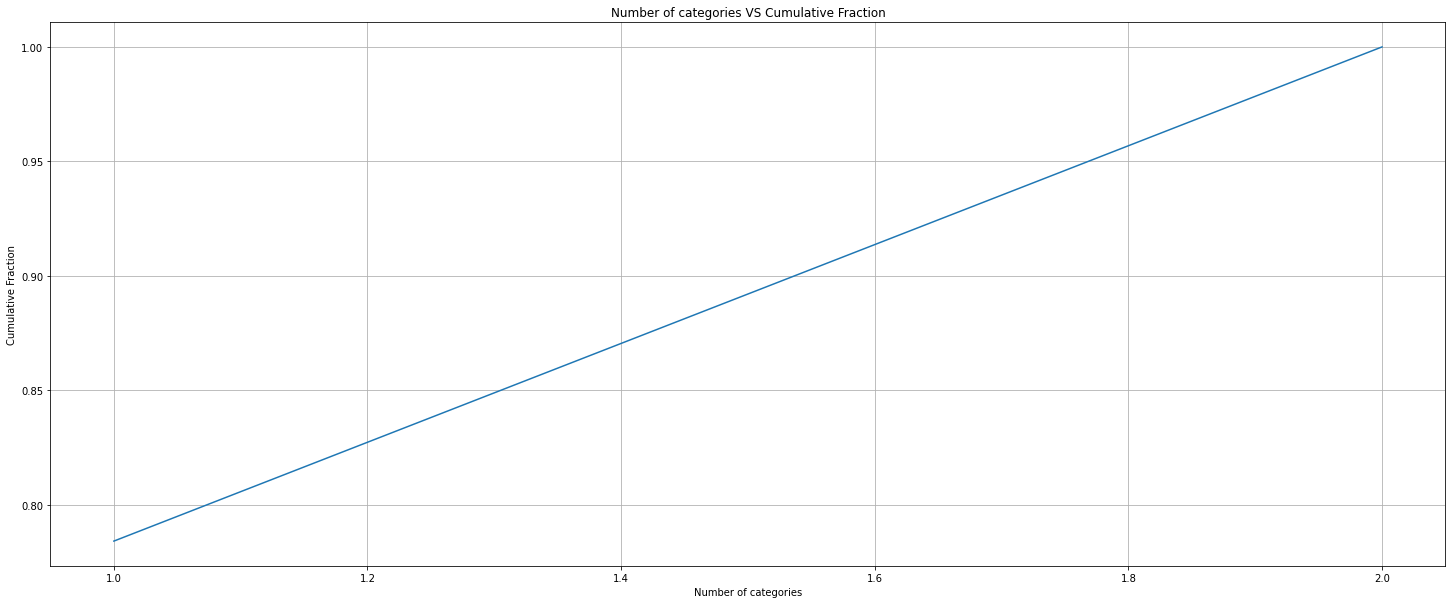

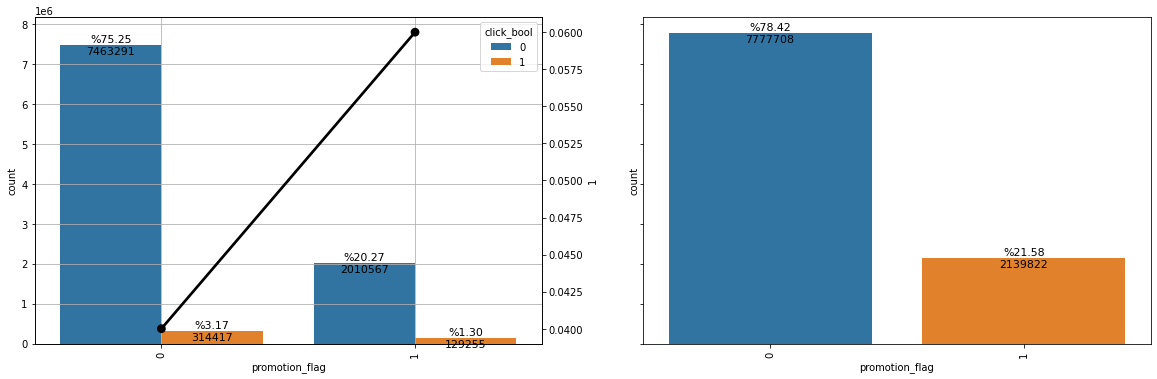

col: srch_saturday_night_bool
Unique number: 2

Top 5 (value: number):

   srch_saturday_night_bool  sample_num      frac    cumsum
0                         1     4961307  0.500256  0.500256
1                         0     4956223  0.499744  1.000000

Bottom 5 (value: number):

   srch_saturday_night_bool  sample_num      frac    cumsum
0                         1     4961307  0.500256  0.500256
1                         0     4956223  0.499744  1.000000


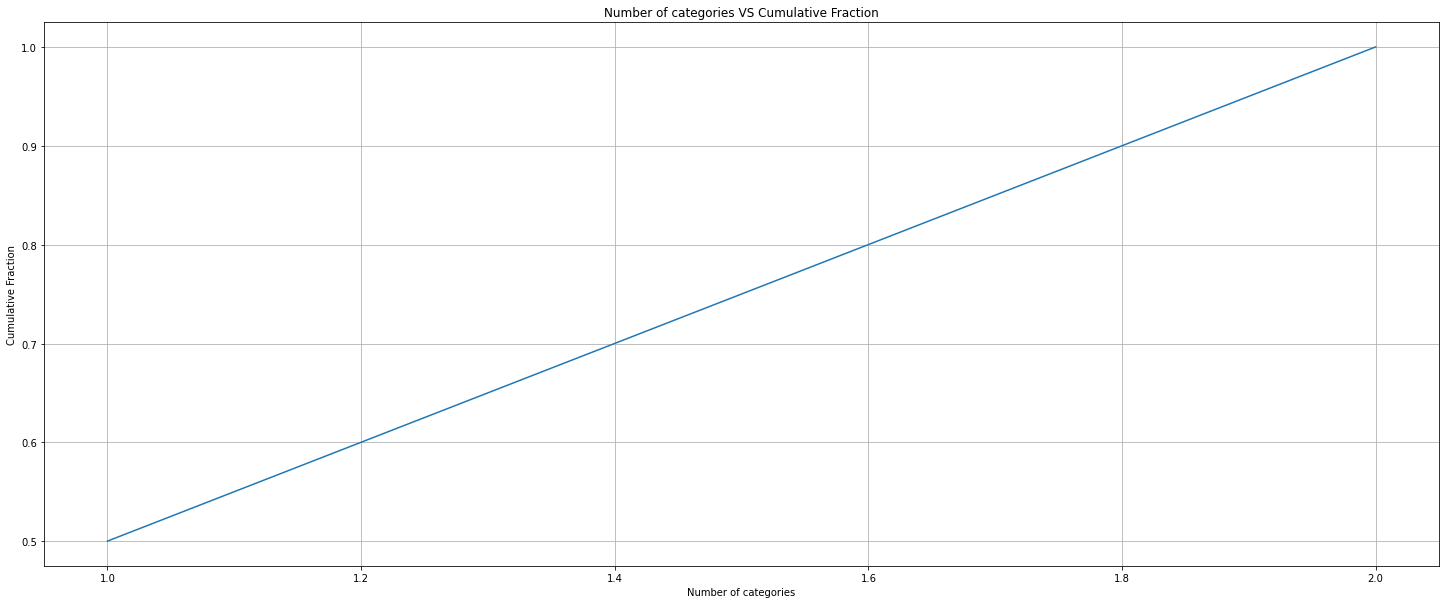

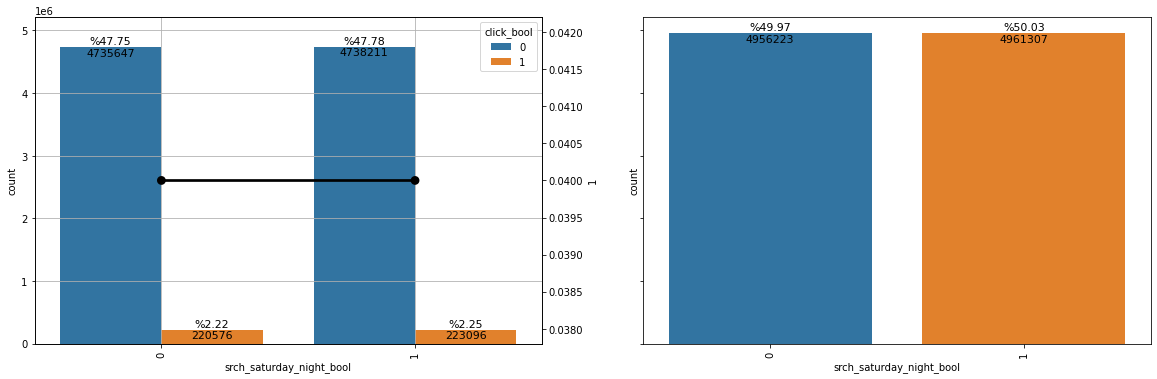

col: random_bool
Unique number: 2

Top 5 (value: number):

   random_bool  sample_num     frac   cumsum
0            0     6977878  0.70359  0.70359
1            1     2939652  0.29641  1.00000

Bottom 5 (value: number):

   random_bool  sample_num     frac   cumsum
0            0     6977878  0.70359  0.70359
1            1     2939652  0.29641  1.00000


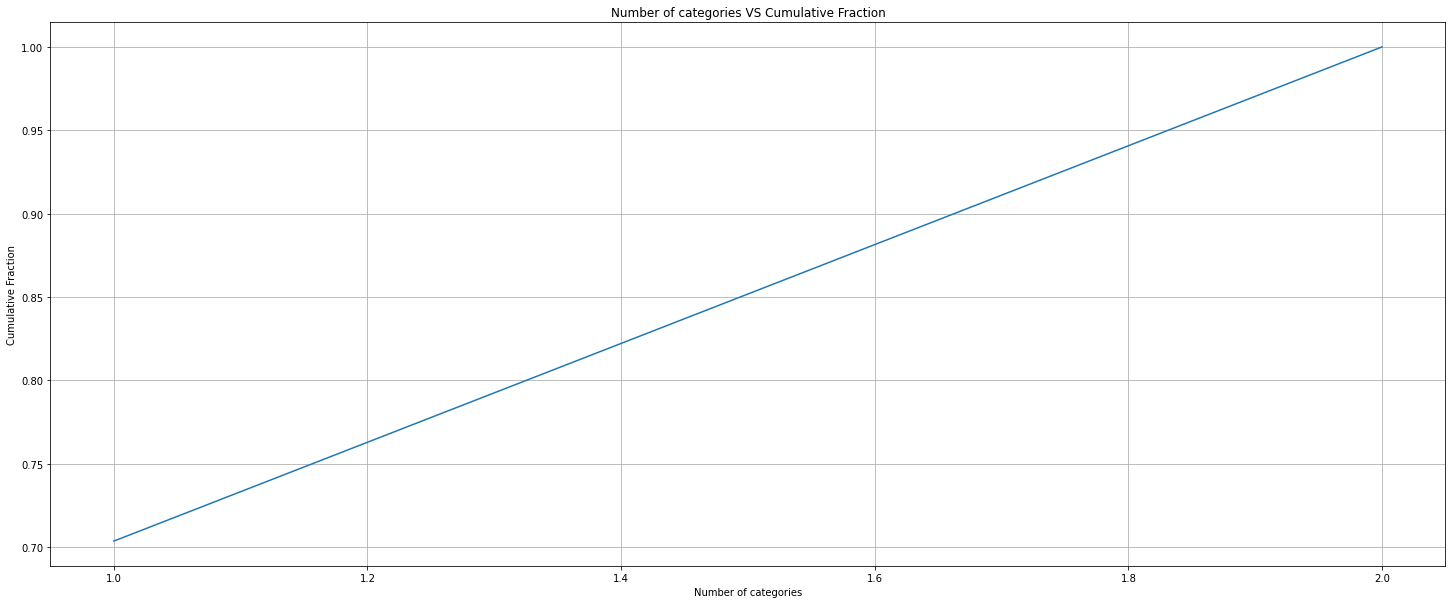

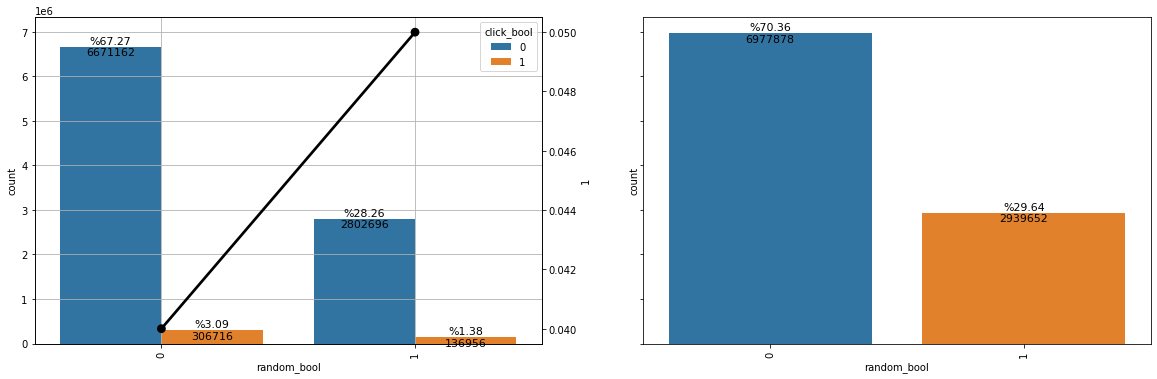

col: comp1_rate
Unique number: 4

Top 5 (value: number):

   comp1_rate  sample_num      frac    cumsum
0         1.0      132077  0.013318  0.013318
1         0.0       84558  0.008526  0.021844
2        -1.0       19171  0.001933  0.023777

Bottom 5 (value: number):

   comp1_rate  sample_num      frac    cumsum
0         1.0      132077  0.013318  0.013318
1         0.0       84558  0.008526  0.021844
2        -1.0       19171  0.001933  0.023777


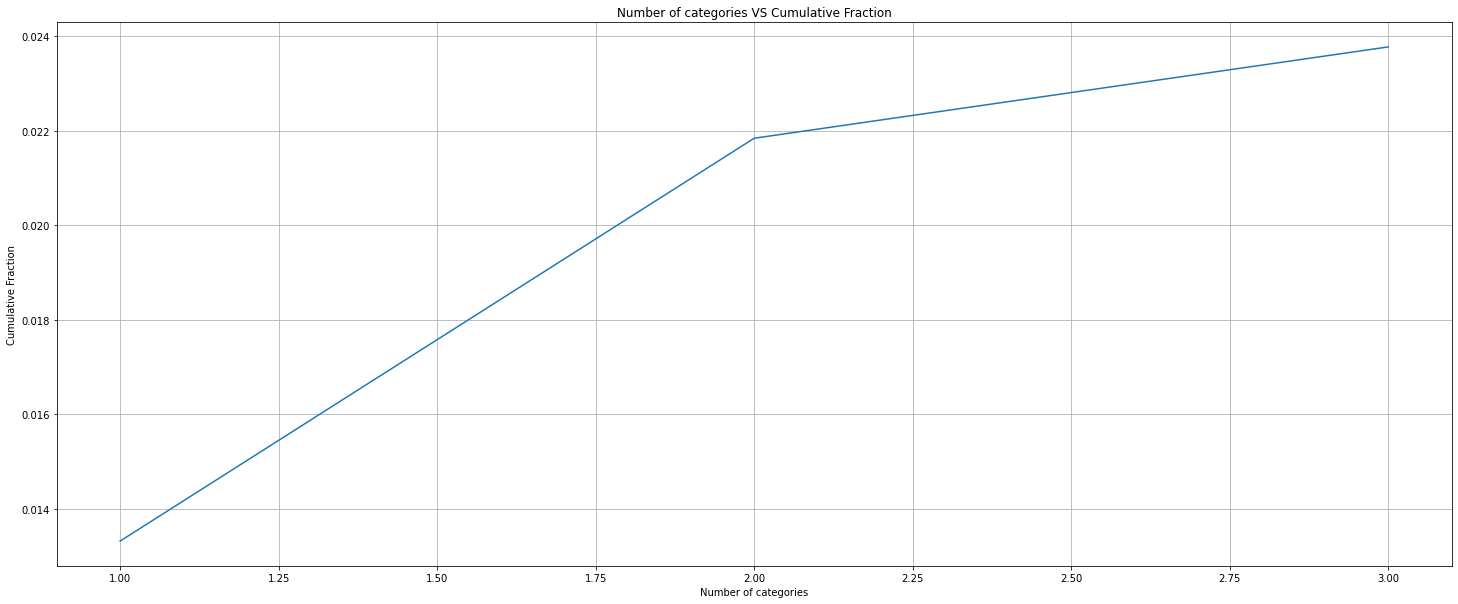

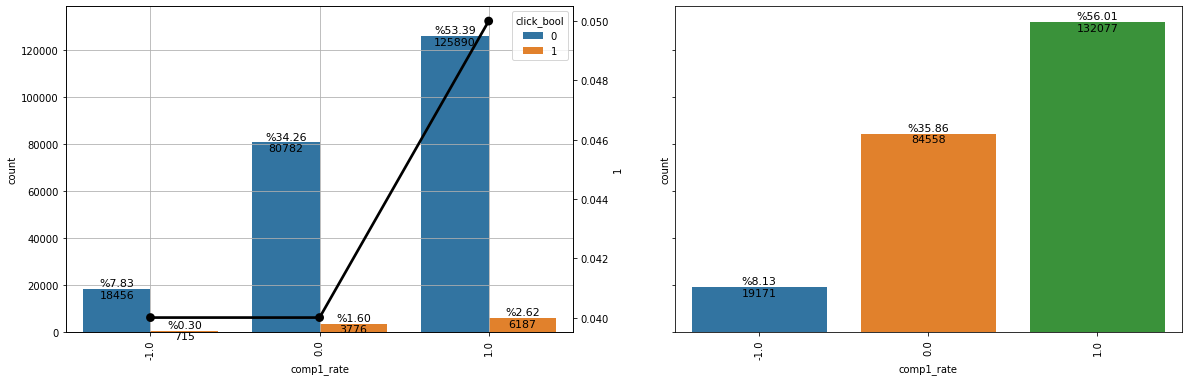

col: comp1_inv
Unique number: 4

Top 5 (value: number):

   comp1_inv  sample_num      frac    cumsum
0        0.0      241050  0.024305  0.024305
1        1.0       10533  0.001062  0.025368
2       -1.0        2850  0.000287  0.025655

Bottom 5 (value: number):

   comp1_inv  sample_num      frac    cumsum
0        0.0      241050  0.024305  0.024305
1        1.0       10533  0.001062  0.025368
2       -1.0        2850  0.000287  0.025655


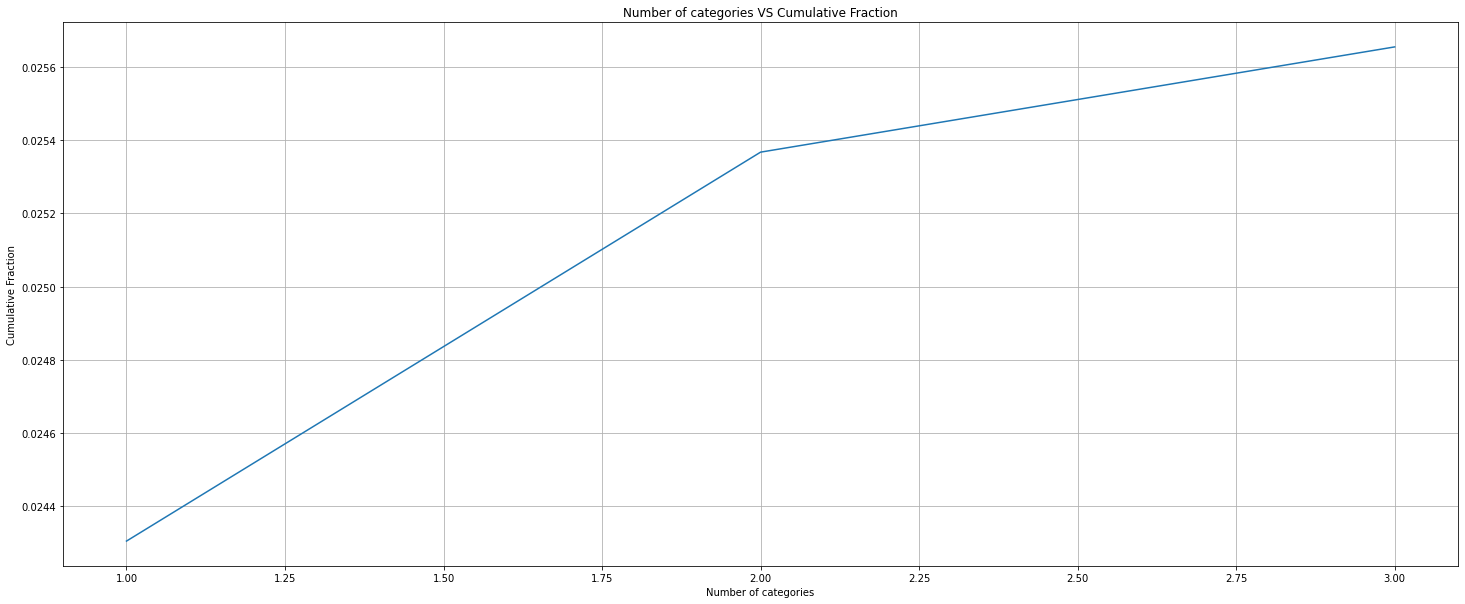

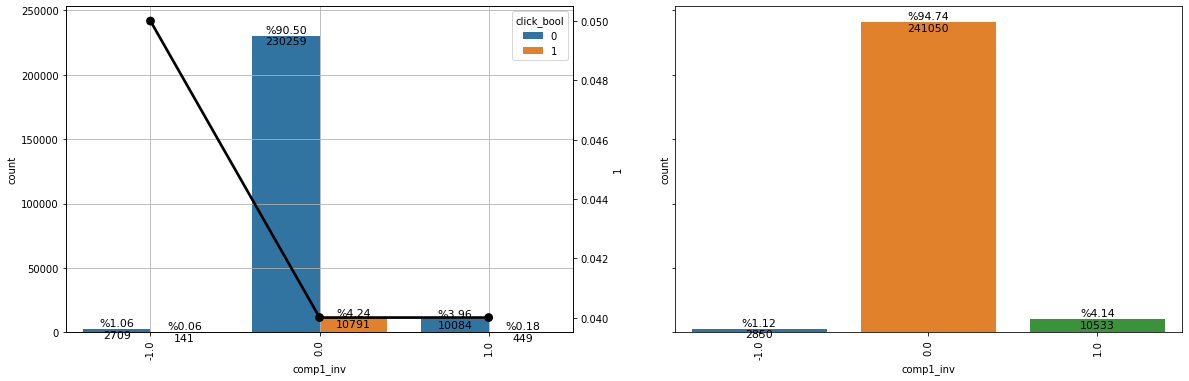

col: comp2_rate
Unique number: 4

Top 5 (value: number):

   comp2_rate  sample_num      frac    cumsum
0         0.0     3221003  0.324779  0.324779
1         1.0      499985  0.050414  0.375193
2        -1.0      319645  0.032230  0.407423

Bottom 5 (value: number):

   comp2_rate  sample_num      frac    cumsum
0         0.0     3221003  0.324779  0.324779
1         1.0      499985  0.050414  0.375193
2        -1.0      319645  0.032230  0.407423


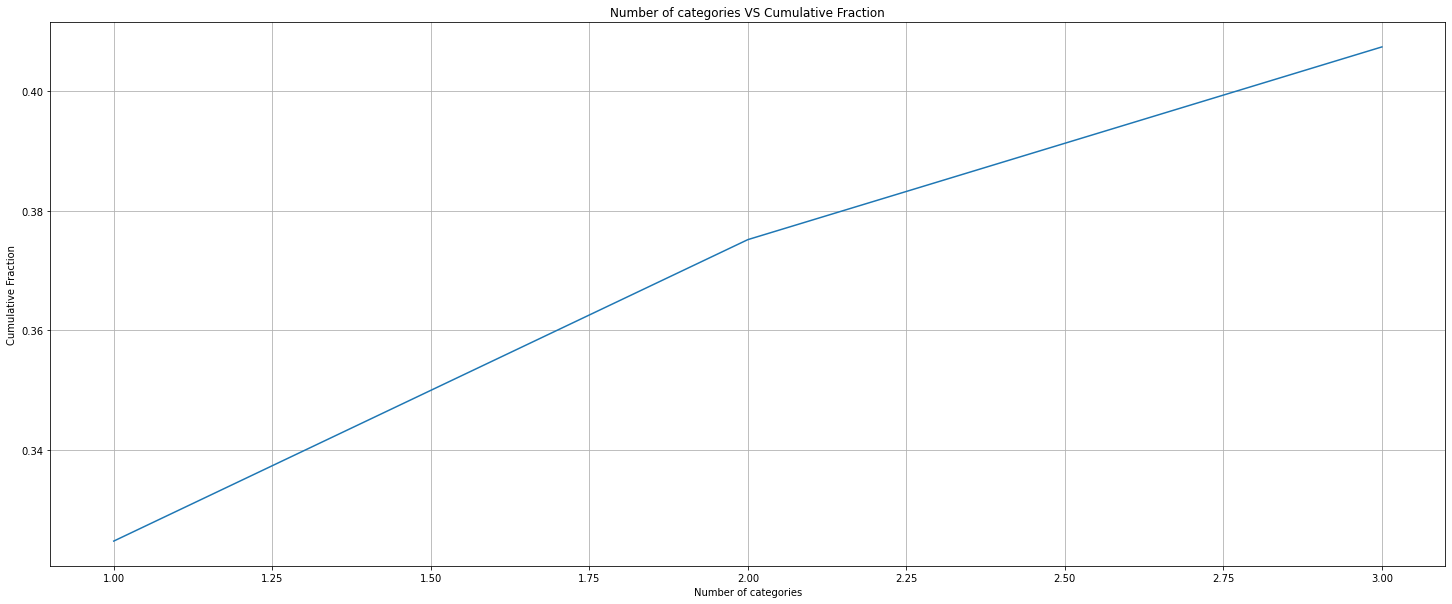

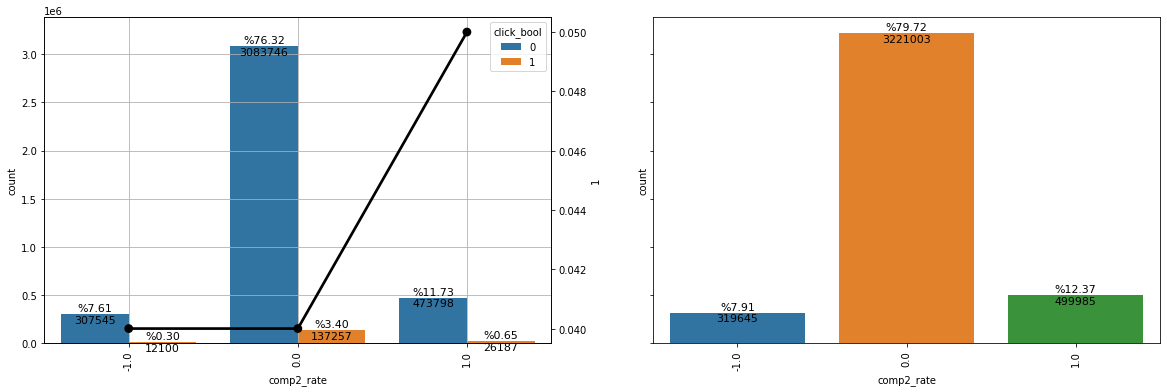

col: comp2_inv
Unique number: 4

Top 5 (value: number):

   comp2_inv  sample_num      frac    cumsum
0        0.0     4011180  0.404454  0.404454
1        1.0      204286  0.020598  0.425052
2       -1.0       36072  0.003637  0.428689

Bottom 5 (value: number):

   comp2_inv  sample_num      frac    cumsum
0        0.0     4011180  0.404454  0.404454
1        1.0      204286  0.020598  0.425052
2       -1.0       36072  0.003637  0.428689


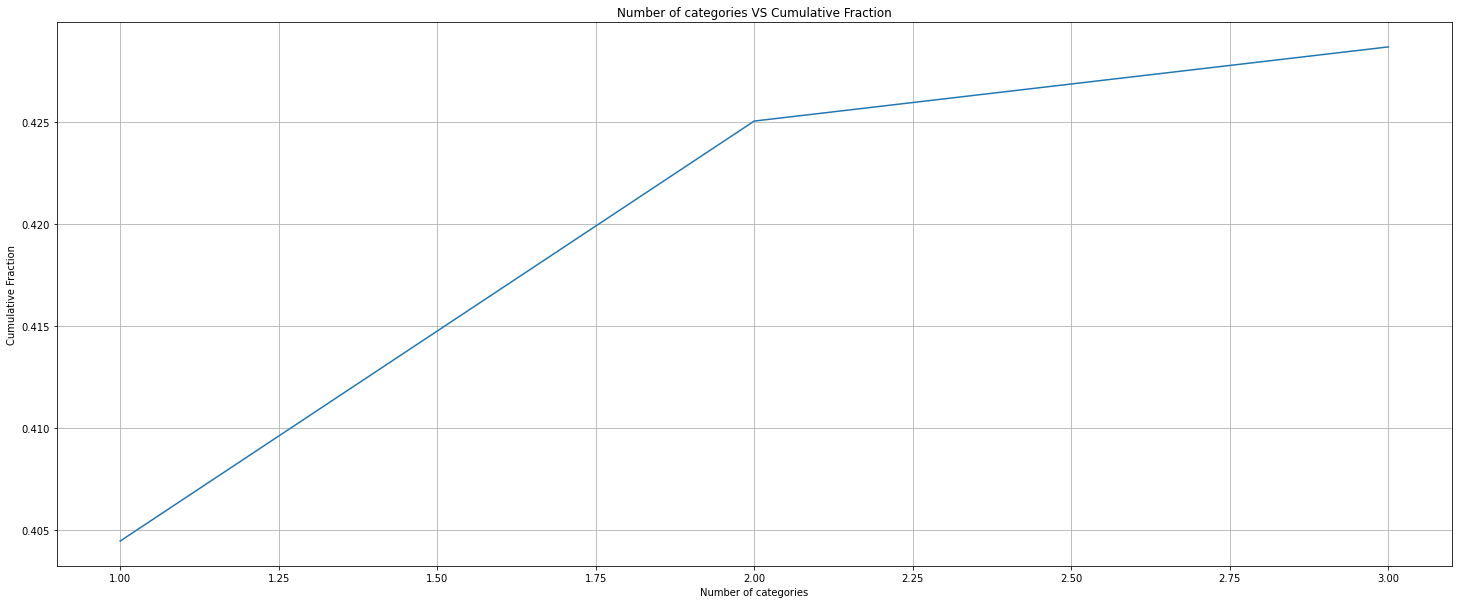

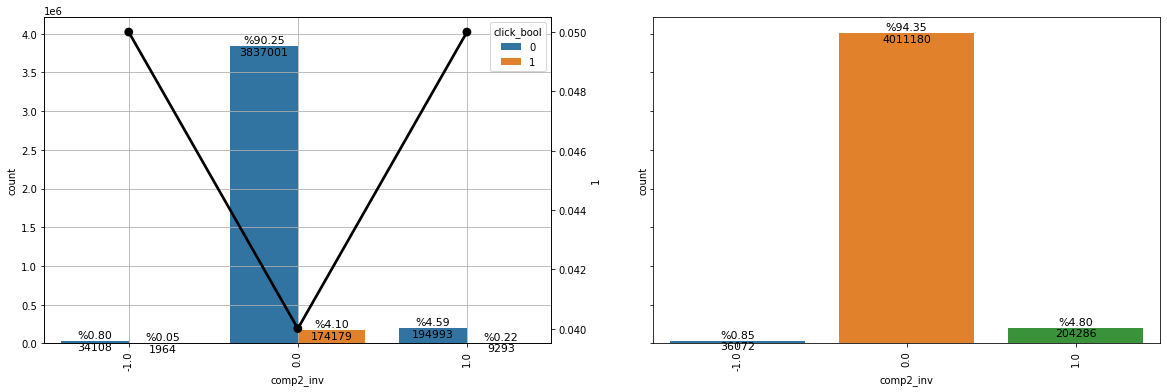

col: comp3_rate
Unique number: 4

Top 5 (value: number):

   comp3_rate  sample_num      frac    cumsum
0         0.0     2417159  0.243726  0.243726
1         1.0      347919  0.035081  0.278807
2        -1.0      294195  0.029664  0.308471

Bottom 5 (value: number):

   comp3_rate  sample_num      frac    cumsum
0         0.0     2417159  0.243726  0.243726
1         1.0      347919  0.035081  0.278807
2        -1.0      294195  0.029664  0.308471


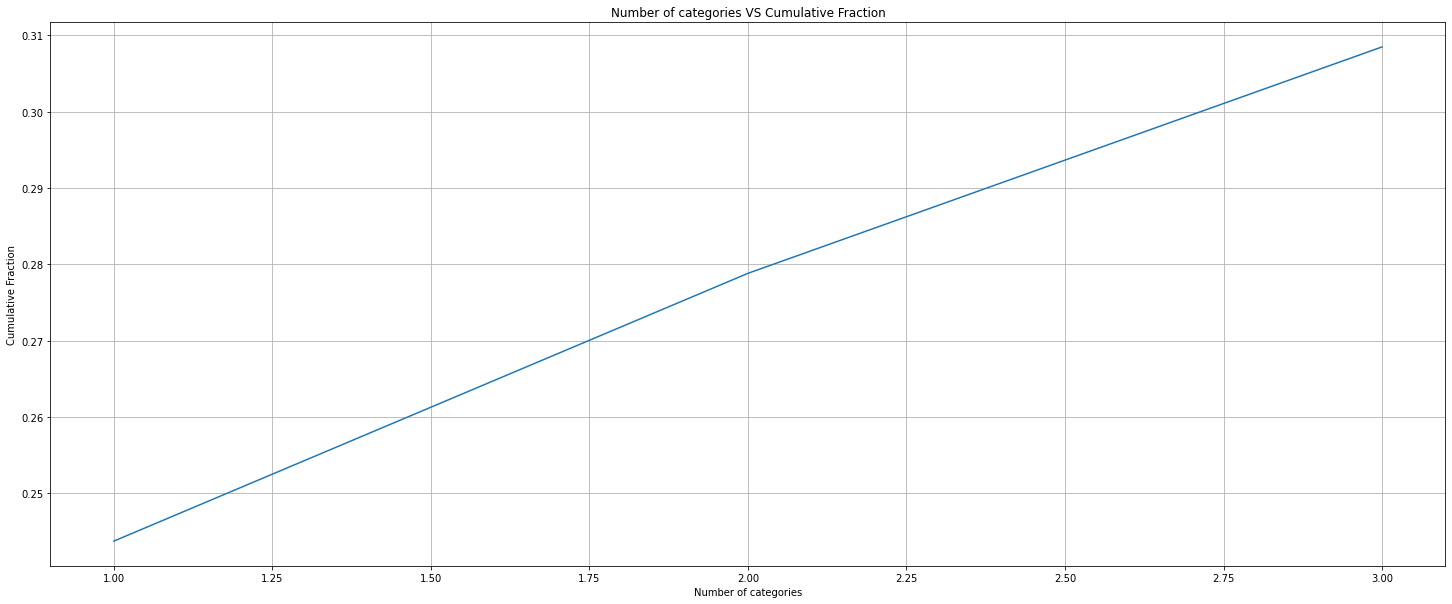

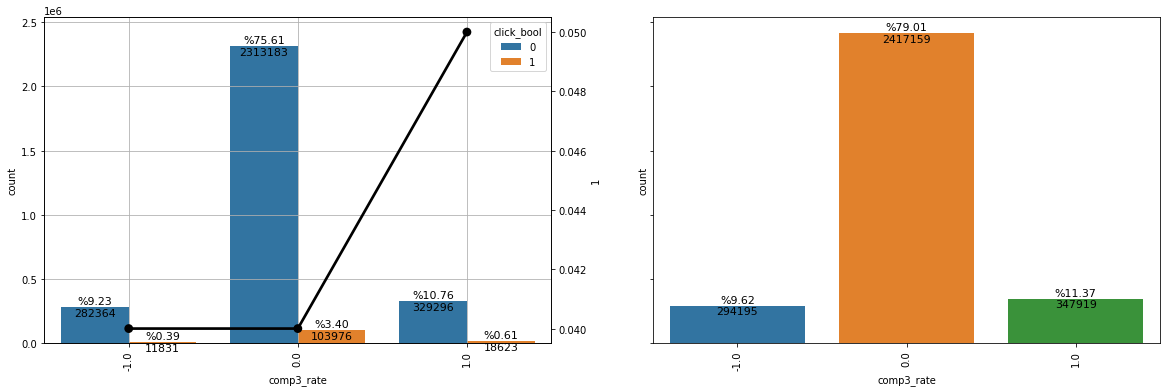

col: comp3_inv
Unique number: 4

Top 5 (value: number):

   comp3_inv  sample_num      frac    cumsum
0        0.0     2995501  0.302041  0.302041
1        1.0      242930  0.024495  0.326536
2       -1.0       53790  0.005424  0.331960

Bottom 5 (value: number):

   comp3_inv  sample_num      frac    cumsum
0        0.0     2995501  0.302041  0.302041
1        1.0      242930  0.024495  0.326536
2       -1.0       53790  0.005424  0.331960


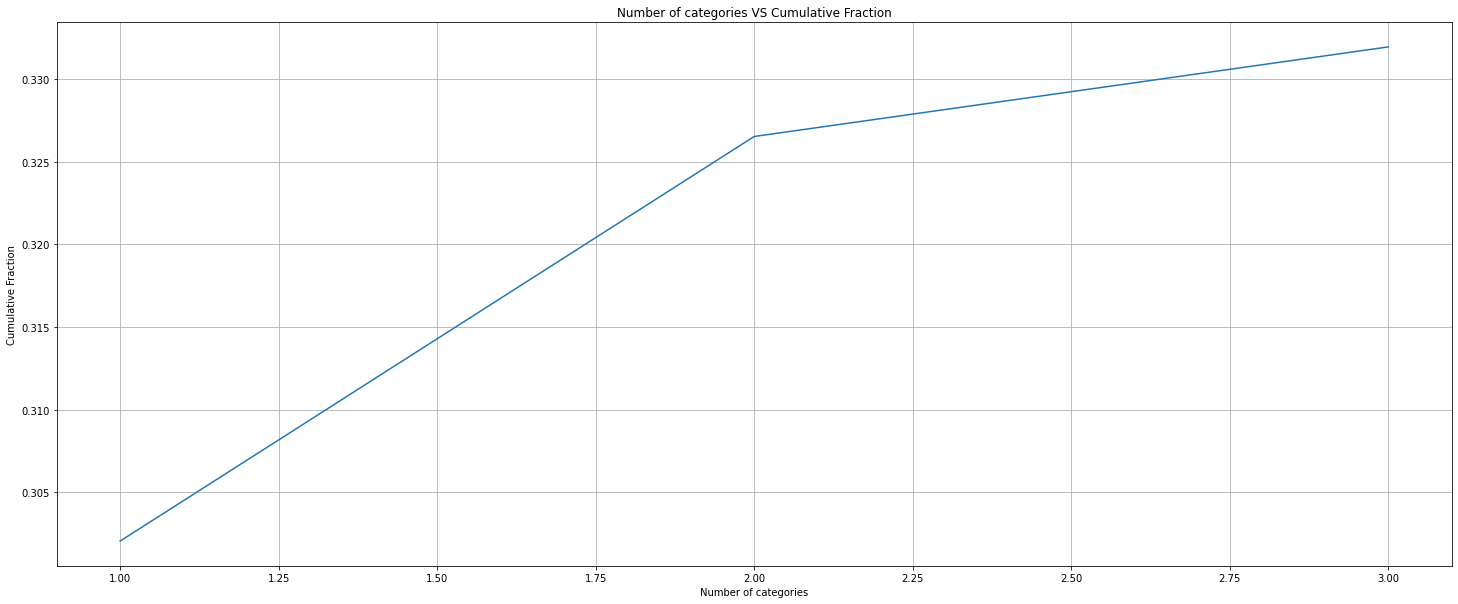

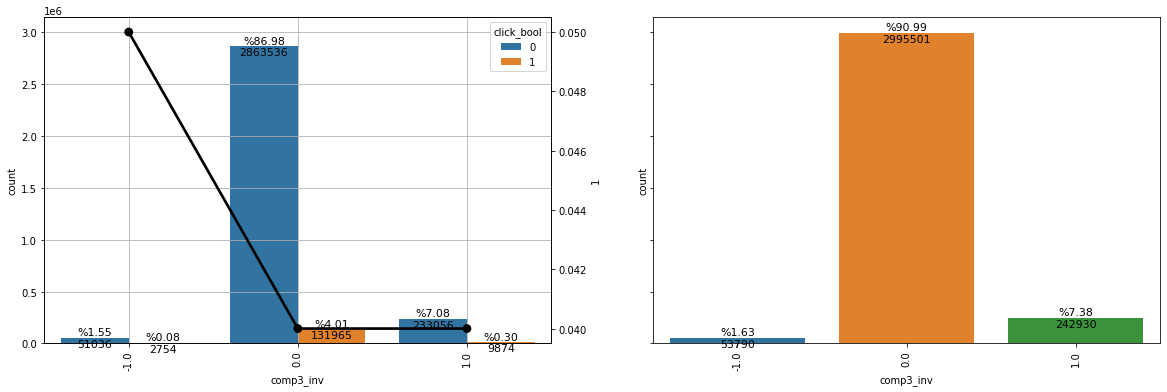

col: comp4_rate
Unique number: 4

Top 5 (value: number):

   comp4_rate  sample_num      frac    cumsum
0         0.0      413459  0.041690  0.041690
1        -1.0      108532  0.010943  0.052633
2         1.0       98108  0.009892  0.062526

Bottom 5 (value: number):

   comp4_rate  sample_num      frac    cumsum
0         0.0      413459  0.041690  0.041690
1        -1.0      108532  0.010943  0.052633
2         1.0       98108  0.009892  0.062526


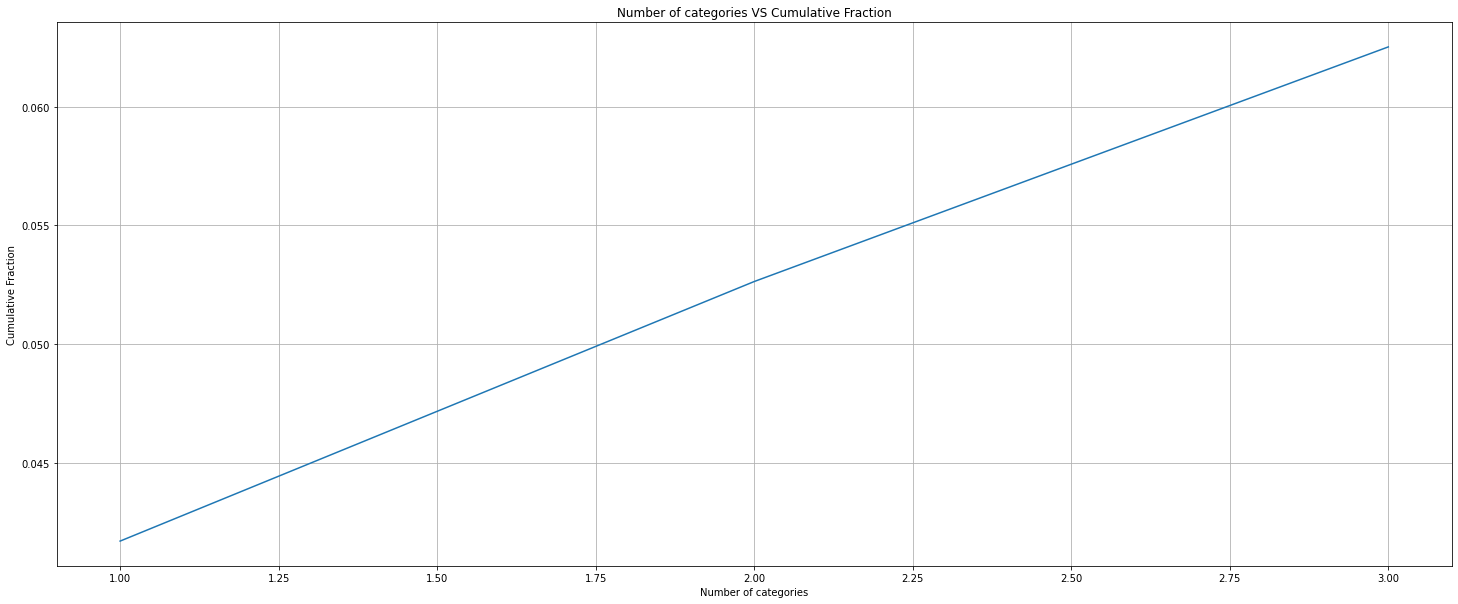

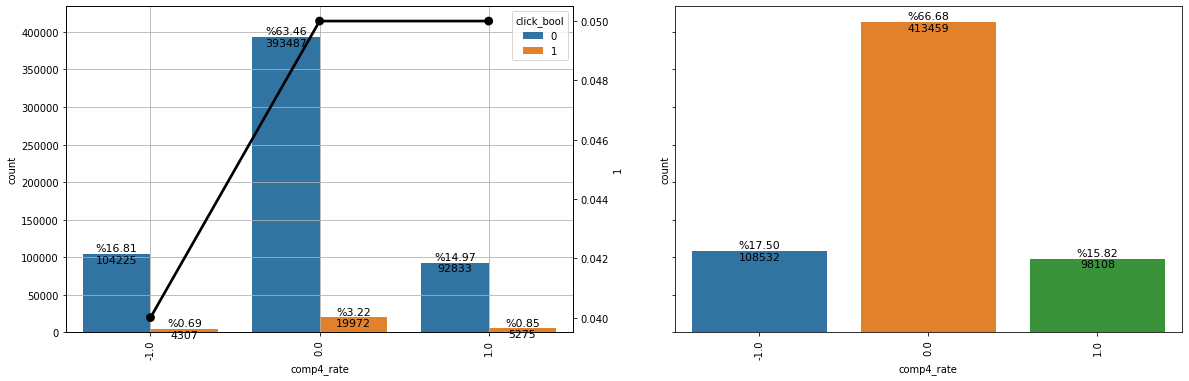

col: comp4_inv
Unique number: 4

Top 5 (value: number):

   comp4_inv  sample_num      frac    cumsum
0        0.0      607809  0.061286  0.061286
1        1.0       75543  0.007617  0.068903
2       -1.0        9119  0.000919  0.069823

Bottom 5 (value: number):

   comp4_inv  sample_num      frac    cumsum
0        0.0      607809  0.061286  0.061286
1        1.0       75543  0.007617  0.068903
2       -1.0        9119  0.000919  0.069823


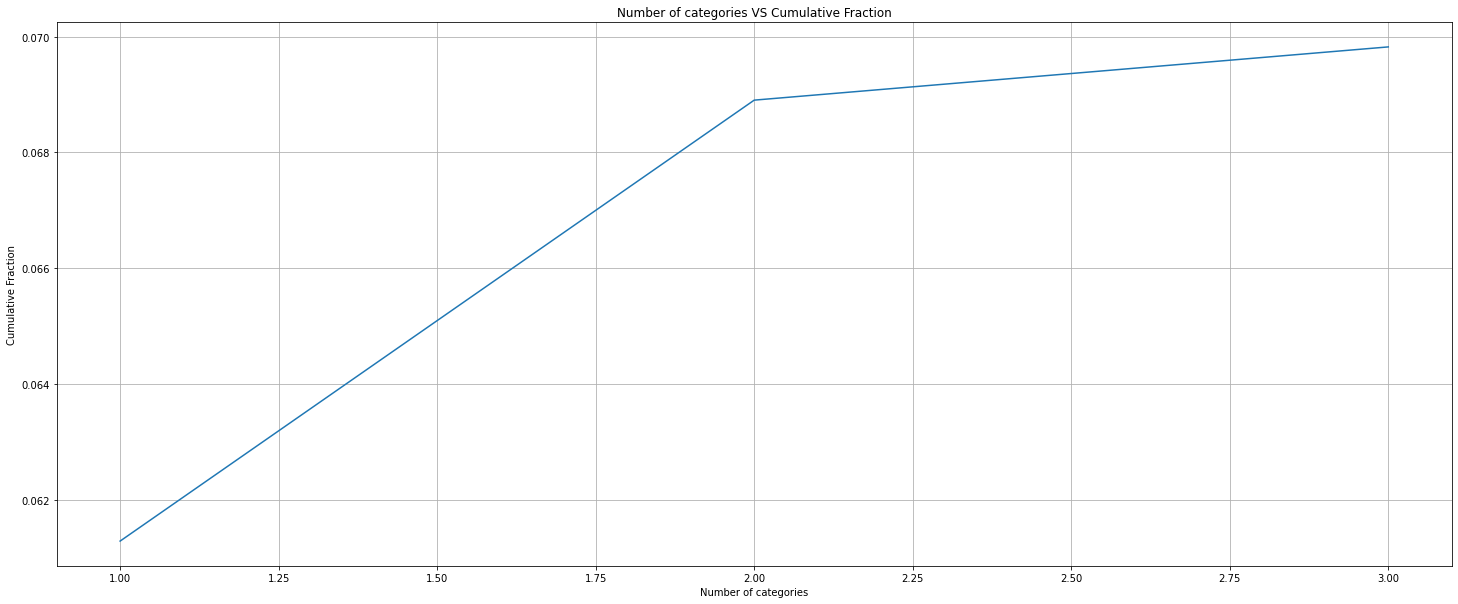

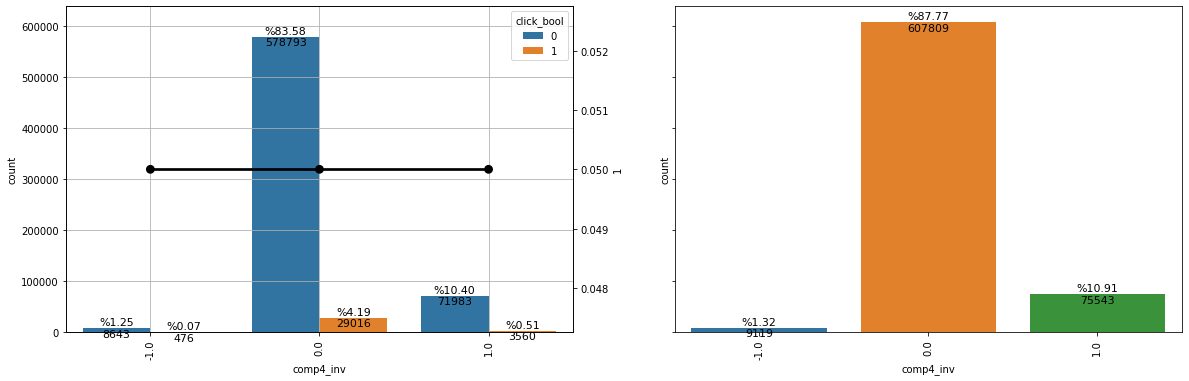

col: comp5_rate
Unique number: 4

Top 5 (value: number):

   comp5_rate  sample_num      frac    cumsum
0         0.0     3234017  0.326091  0.326091
1         1.0      655637  0.066109  0.392200
2        -1.0      554640  0.055925  0.448125

Bottom 5 (value: number):

   comp5_rate  sample_num      frac    cumsum
0         0.0     3234017  0.326091  0.326091
1         1.0      655637  0.066109  0.392200
2        -1.0      554640  0.055925  0.448125


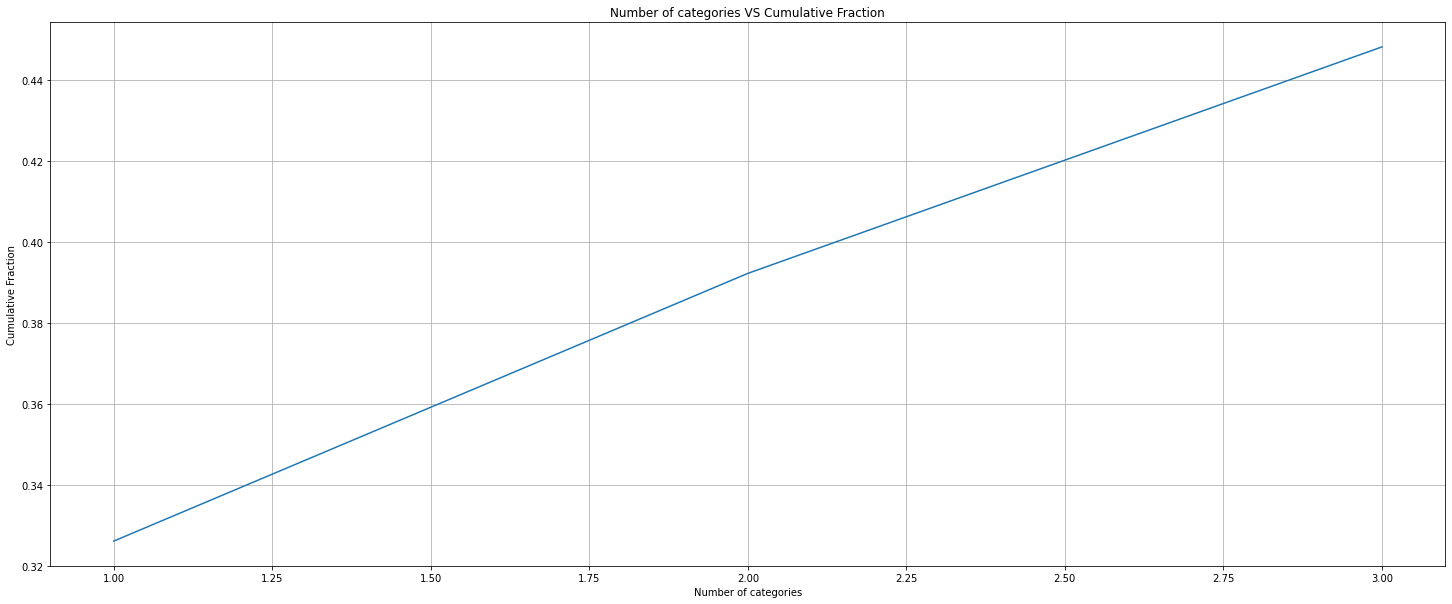

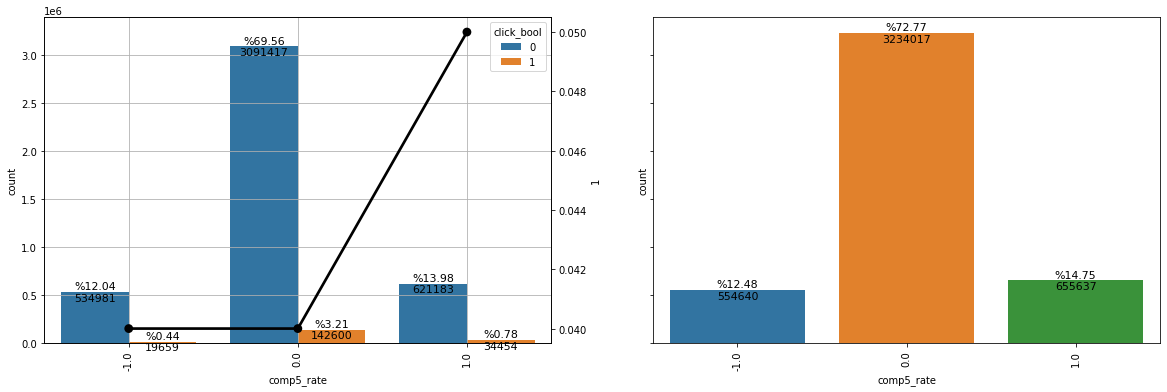

col: comp5_inv
Unique number: 4

Top 5 (value: number):

   comp5_inv  sample_num      frac    cumsum
0        0.0     4368523  0.440485  0.440485
1        1.0      298564  0.030105  0.470590
2       -1.0       53746  0.005419  0.476009

Bottom 5 (value: number):

   comp5_inv  sample_num      frac    cumsum
0        0.0     4368523  0.440485  0.440485
1        1.0      298564  0.030105  0.470590
2       -1.0       53746  0.005419  0.476009


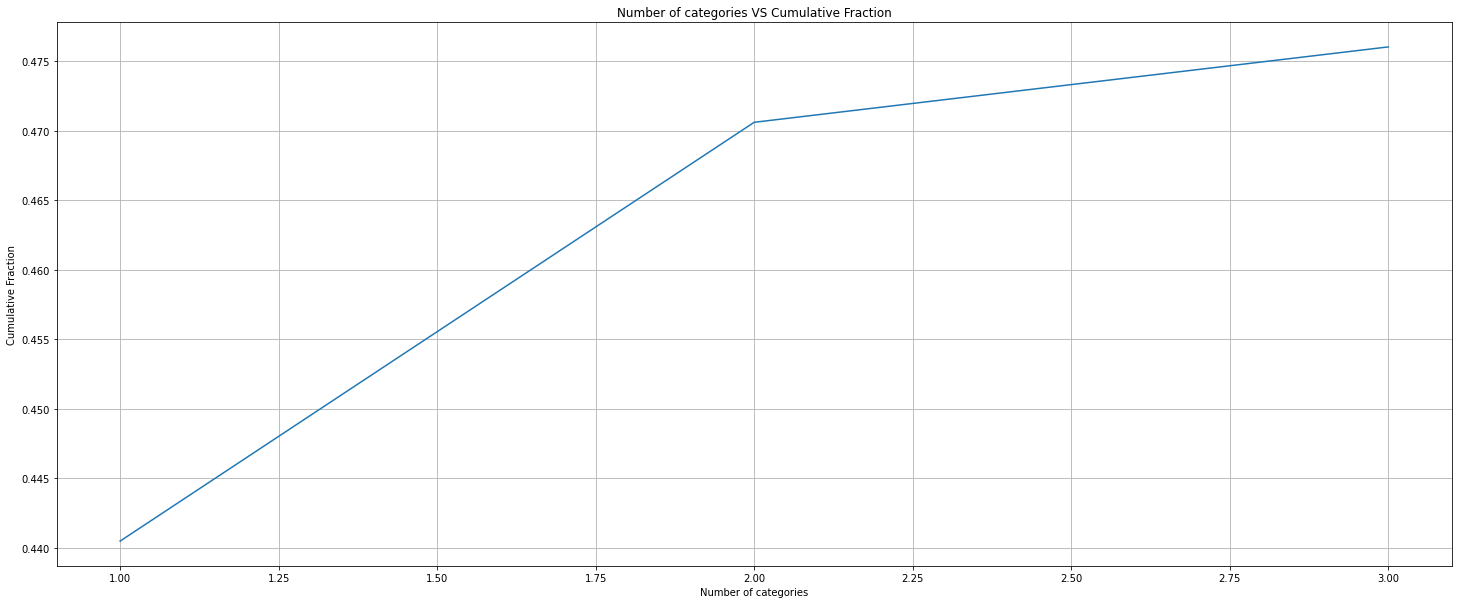

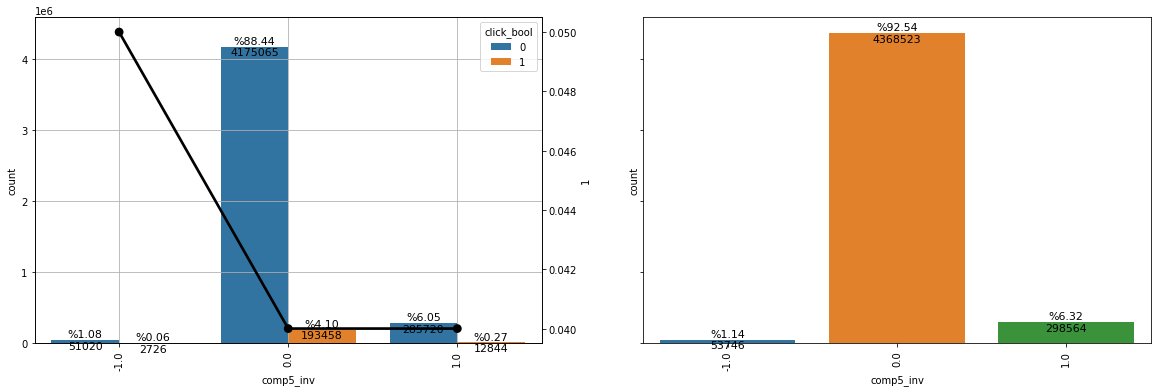

col: comp6_rate
Unique number: 4

Top 5 (value: number):

   comp6_rate  sample_num      frac    cumsum
0         0.0      323036  0.032572  0.032572
1         1.0      110840  0.011176  0.043748
2        -1.0       48611  0.004902  0.048650

Bottom 5 (value: number):

   comp6_rate  sample_num      frac    cumsum
0         0.0      323036  0.032572  0.032572
1         1.0      110840  0.011176  0.043748
2        -1.0       48611  0.004902  0.048650


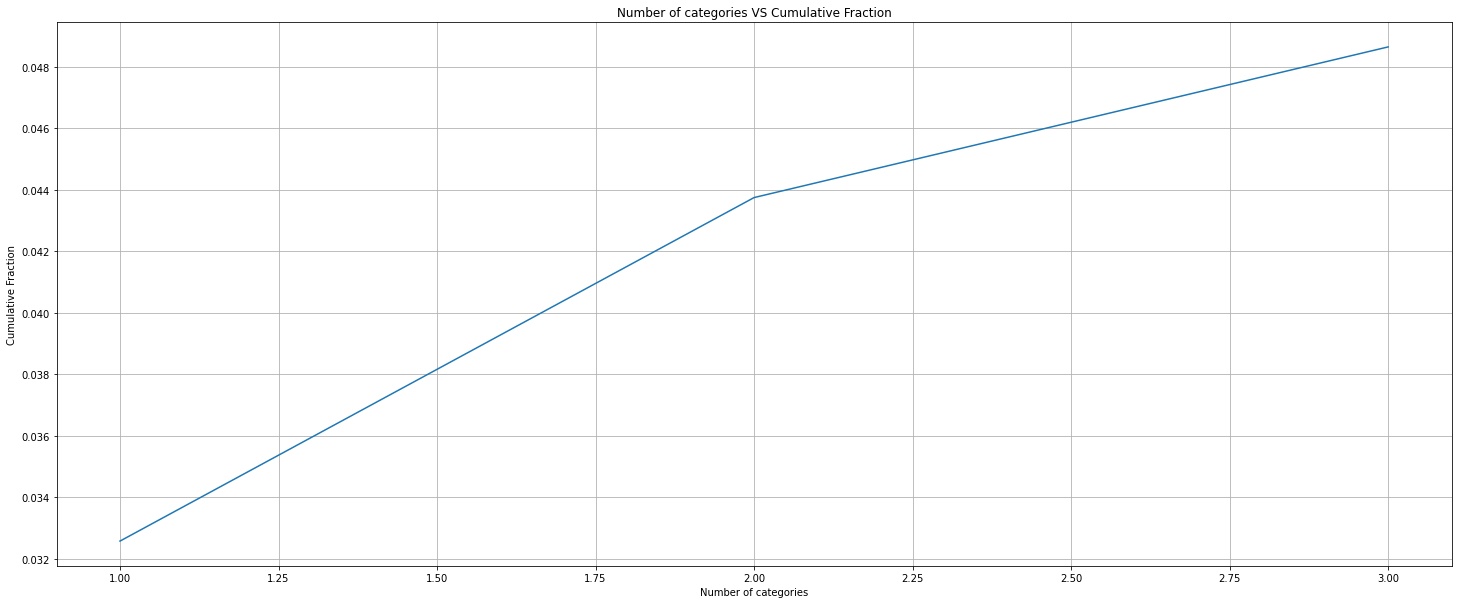

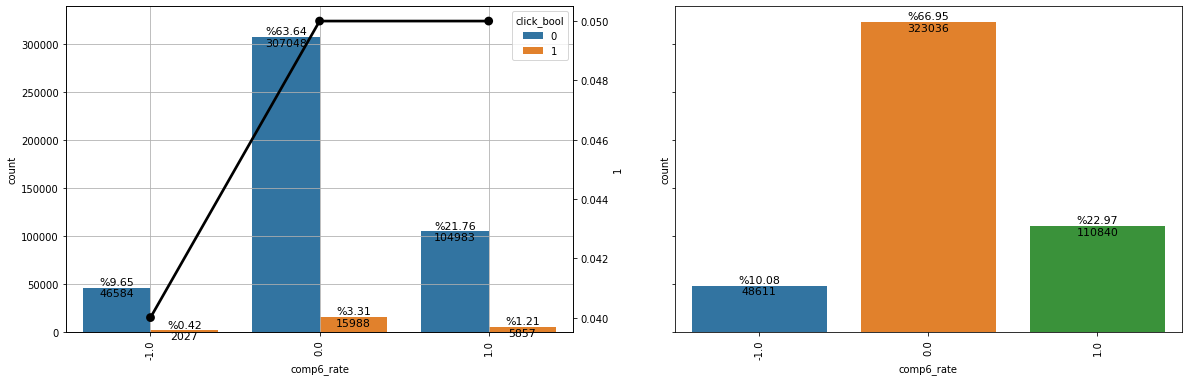

col: comp6_inv
Unique number: 4

Top 5 (value: number):

   comp6_inv  sample_num      frac    cumsum
0        0.0      473323  0.047726  0.047726
1        1.0       45237  0.004561  0.052287
2       -1.0        5585  0.000563  0.052850

Bottom 5 (value: number):

   comp6_inv  sample_num      frac    cumsum
0        0.0      473323  0.047726  0.047726
1        1.0       45237  0.004561  0.052287
2       -1.0        5585  0.000563  0.052850


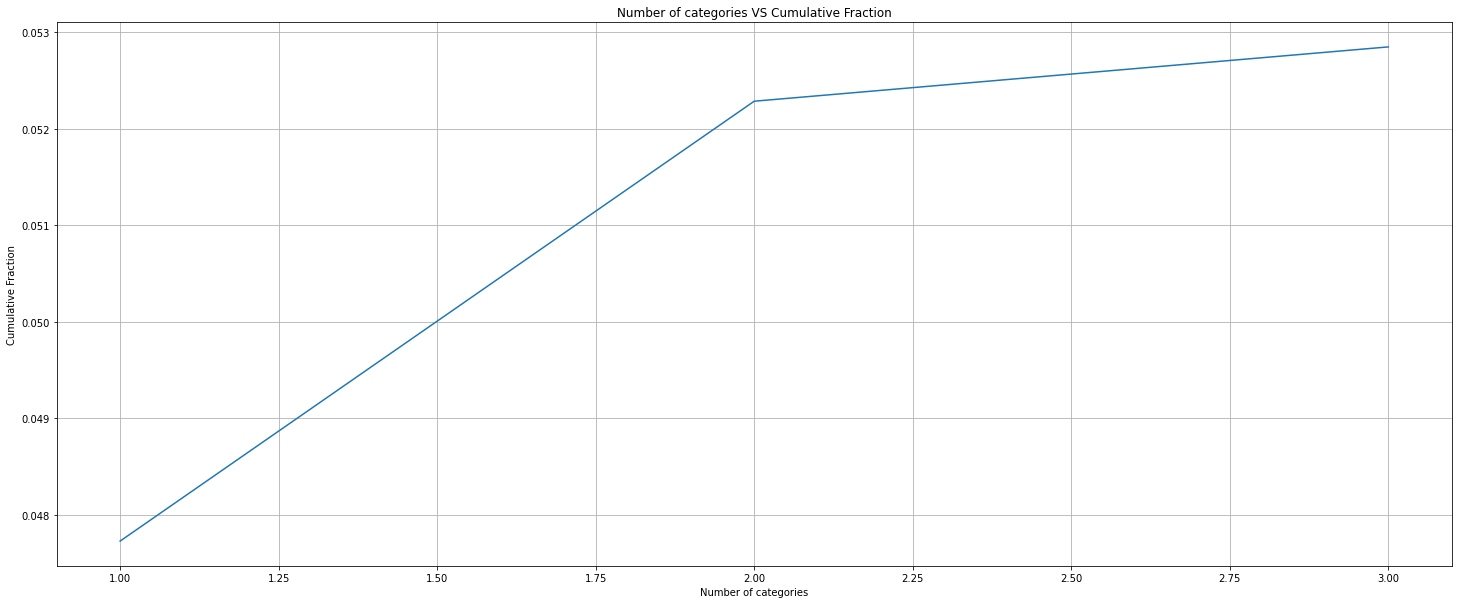

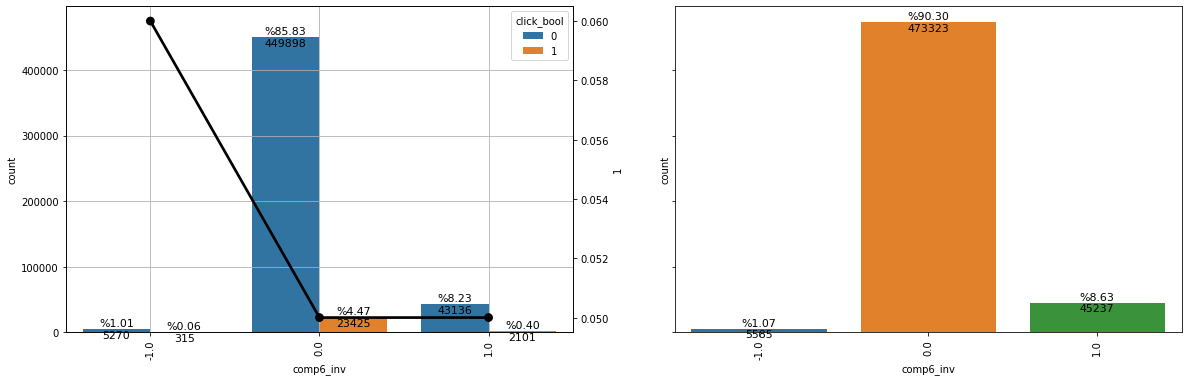

col: comp7_rate
Unique number: 4

Top 5 (value: number):

   comp7_rate  sample_num      frac    cumsum
0         0.0      406050  0.040943  0.040943
1         1.0      158917  0.016024  0.056967
2        -1.0       66110  0.006666  0.063632

Bottom 5 (value: number):

   comp7_rate  sample_num      frac    cumsum
0         0.0      406050  0.040943  0.040943
1         1.0      158917  0.016024  0.056967
2        -1.0       66110  0.006666  0.063632


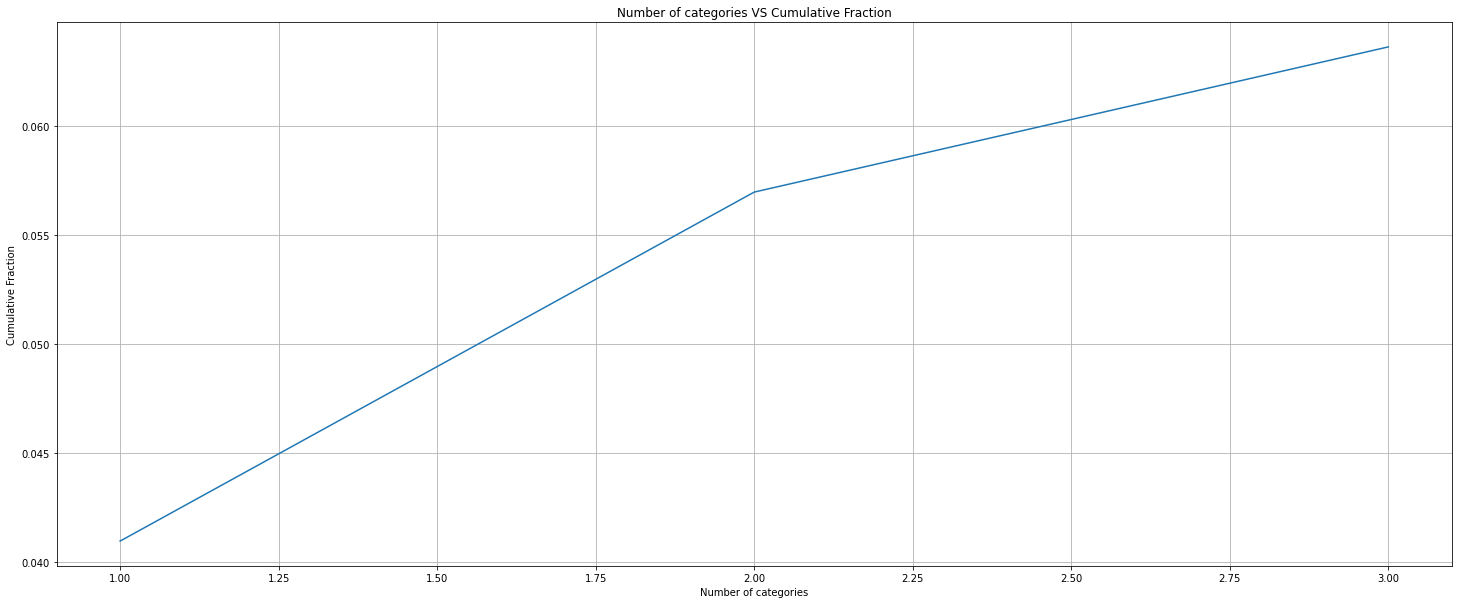

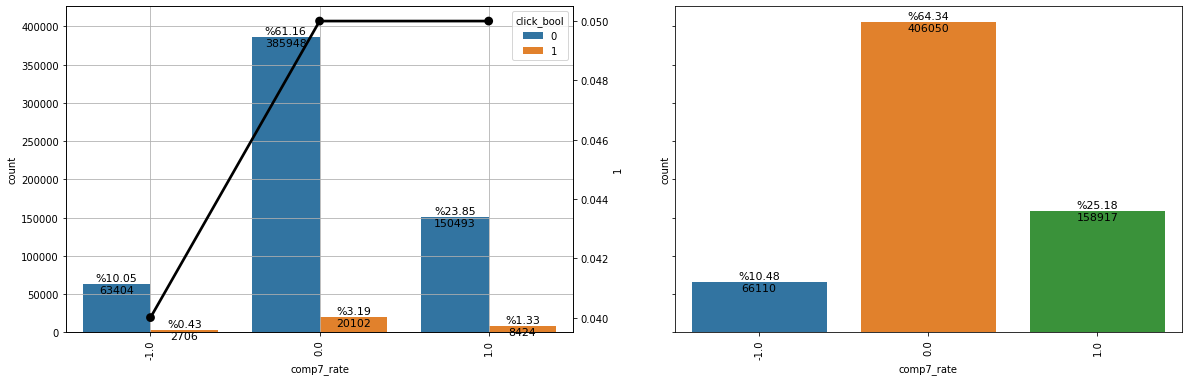

col: comp7_inv
Unique number: 4

Top 5 (value: number):

   comp7_inv  sample_num      frac    cumsum
0        0.0      637060  0.064236  0.064236
1        1.0       67390  0.006795  0.071031
2       -1.0        8725  0.000880  0.071911

Bottom 5 (value: number):

   comp7_inv  sample_num      frac    cumsum
0        0.0      637060  0.064236  0.064236
1        1.0       67390  0.006795  0.071031
2       -1.0        8725  0.000880  0.071911


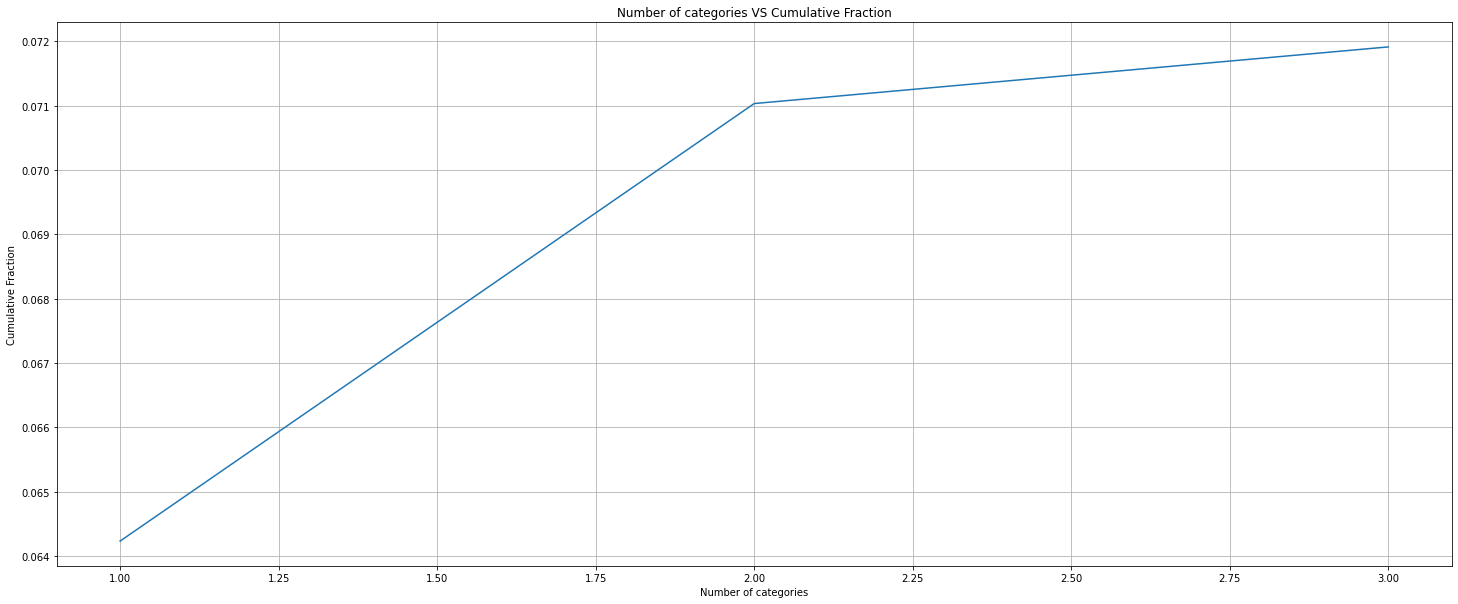

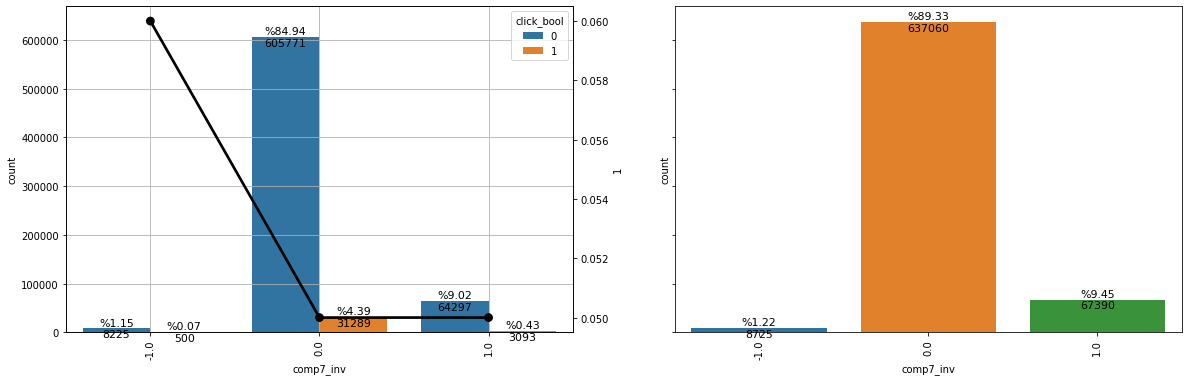

col: comp8_rate
Unique number: 4

Top 5 (value: number):

   comp8_rate  sample_num      frac    cumsum
0         0.0     2964040  0.298869  0.298869
1        -1.0      543457  0.054798  0.353666
2         1.0      311546  0.031414  0.385080

Bottom 5 (value: number):

   comp8_rate  sample_num      frac    cumsum
0         0.0     2964040  0.298869  0.298869
1        -1.0      543457  0.054798  0.353666
2         1.0      311546  0.031414  0.385080


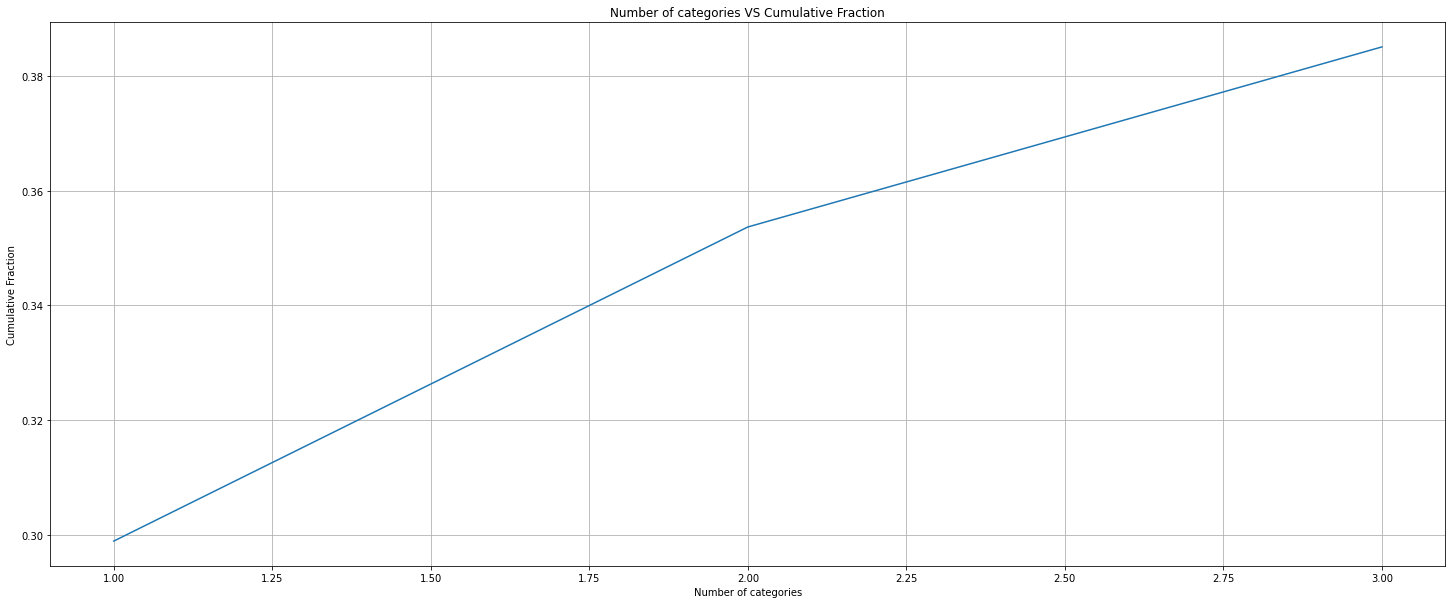

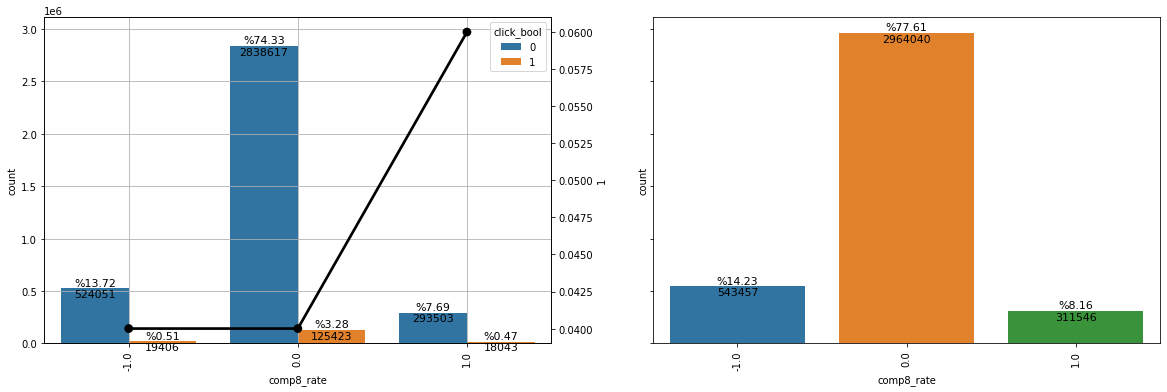

col: comp8_inv
Unique number: 4

Top 5 (value: number):

   comp8_inv  sample_num      frac    cumsum
0        0.0     3796532  0.382810  0.382810
1        1.0      101511  0.010236  0.393046
2       -1.0       62345  0.006286  0.399332

Bottom 5 (value: number):

   comp8_inv  sample_num      frac    cumsum
0        0.0     3796532  0.382810  0.382810
1        1.0      101511  0.010236  0.393046
2       -1.0       62345  0.006286  0.399332


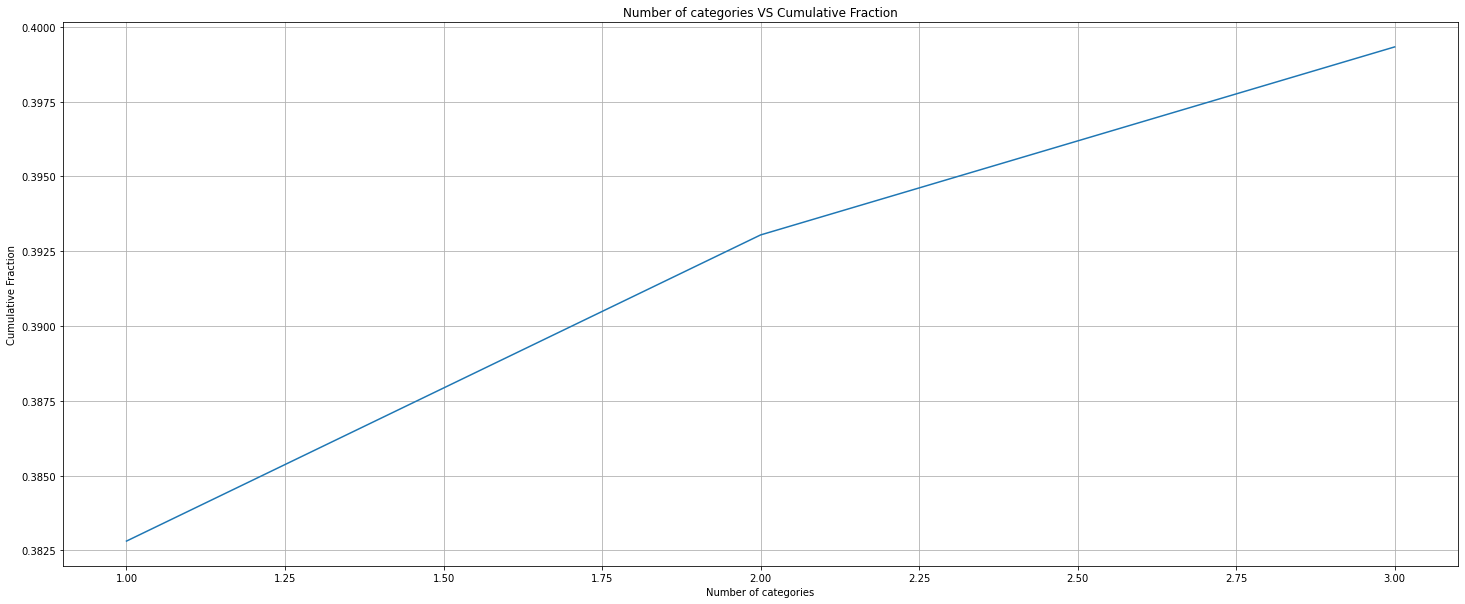

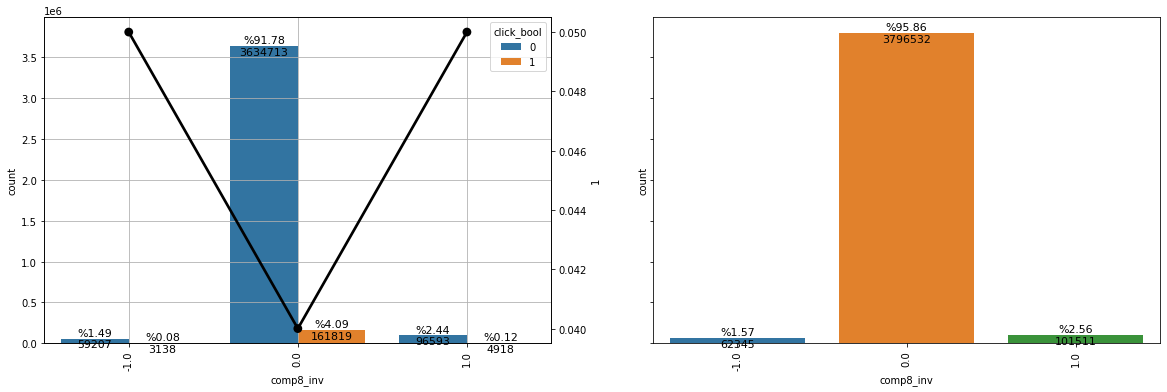

col: day
Unique number: 31

Top 5 (value: number):

   day  sample_num      frac    cumsum
0   28      347442  0.035033  0.035033
1   20      346070  0.034895  0.069928
2    7      344396  0.034726  0.104654
3   21      344199  0.034706  0.139360
4   13      341368  0.034421  0.173781

Bottom 5 (value: number):

    day  sample_num      frac    cumsum
26    2      308696  0.031126  0.899203
27    1      299737  0.030223  0.929426
28   29      280969  0.028331  0.957757
29   30      276039  0.027833  0.985590
30   31      142912  0.014410  1.000000


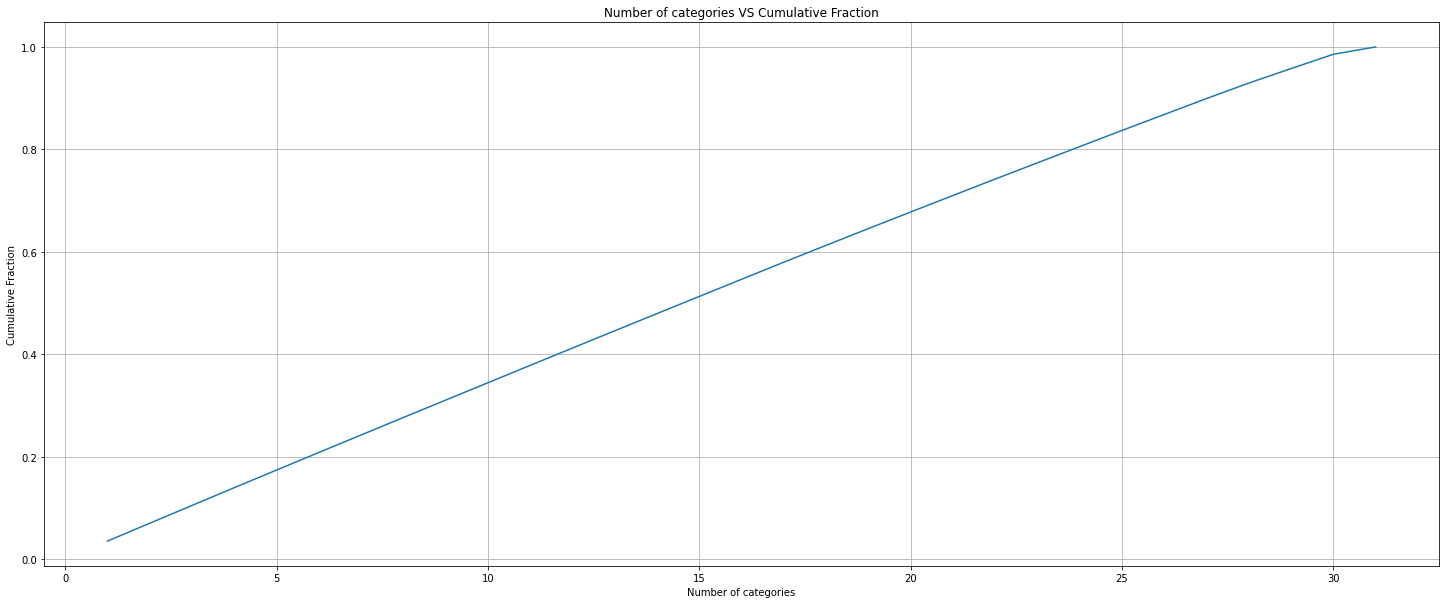

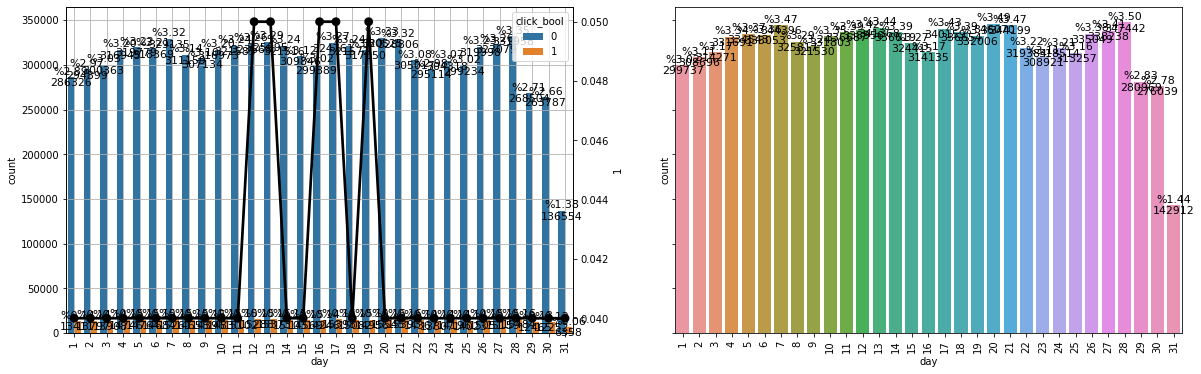

col: hour
Unique number: 24

Top 5 (value: number):

   hour  sample_num      frac    cumsum
0    18      627277  0.063249  0.063249
1    17      618736  0.062388  0.125637
2    11      614252  0.061936  0.187573
3    12      613858  0.061896  0.249470
4    19      605192  0.061022  0.310492

Bottom 5 (value: number):

    hour  sample_num      frac    cumsum
19     0      156072  0.015737  0.966680
20     1       97605  0.009842  0.976522
21     4       95138  0.009593  0.986114
22     2       70532  0.007112  0.993226
23     3       67178  0.006774  1.000000


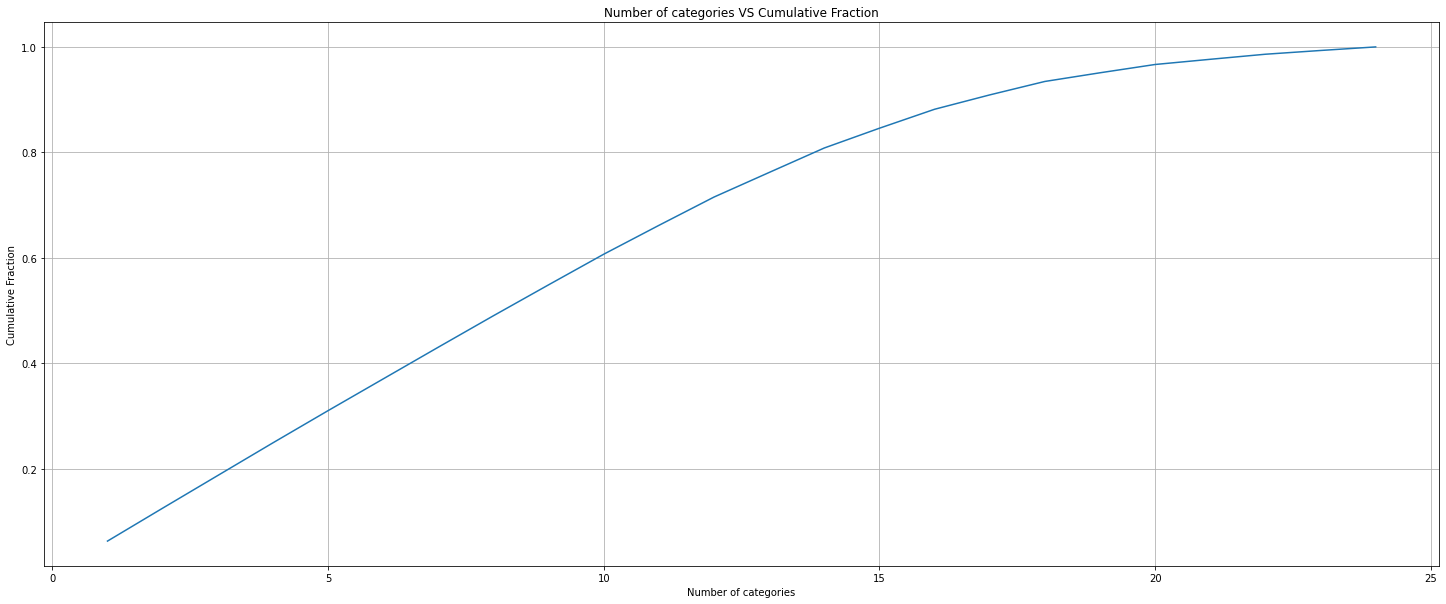

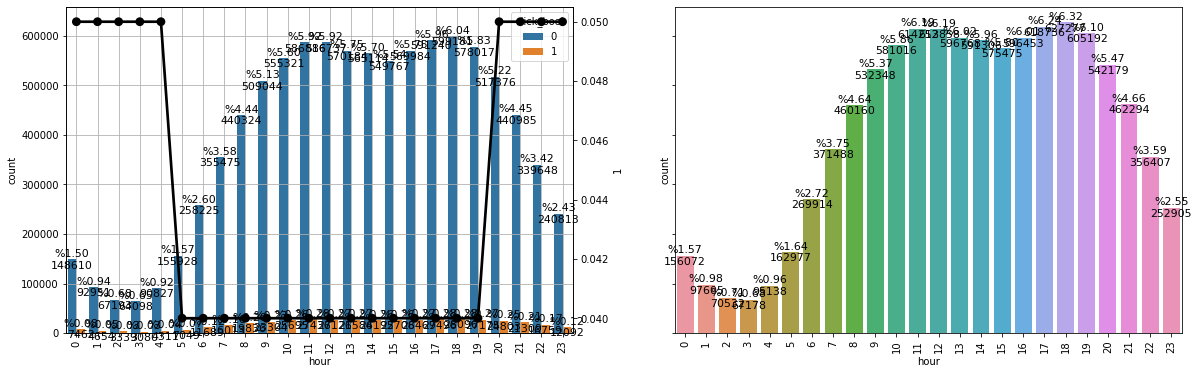

col: dayofweek
Unique number: 7

Top 5 (value: number):

   dayofweek  sample_num      frac    cumsum
0          2     1563334  0.157633  0.157633
1          0     1534358  0.154712  0.312345
2          1     1531545  0.154428  0.466773
3          3     1493334  0.150575  0.617348
4          4     1367235  0.137860  0.755209

Bottom 5 (value: number):

   dayofweek  sample_num      frac    cumsum
2          1     1531545  0.154428  0.466773
3          3     1493334  0.150575  0.617348
4          4     1367235  0.137860  0.755209
5          6     1325089  0.133611  0.888820
6          5     1102635  0.111180  1.000000


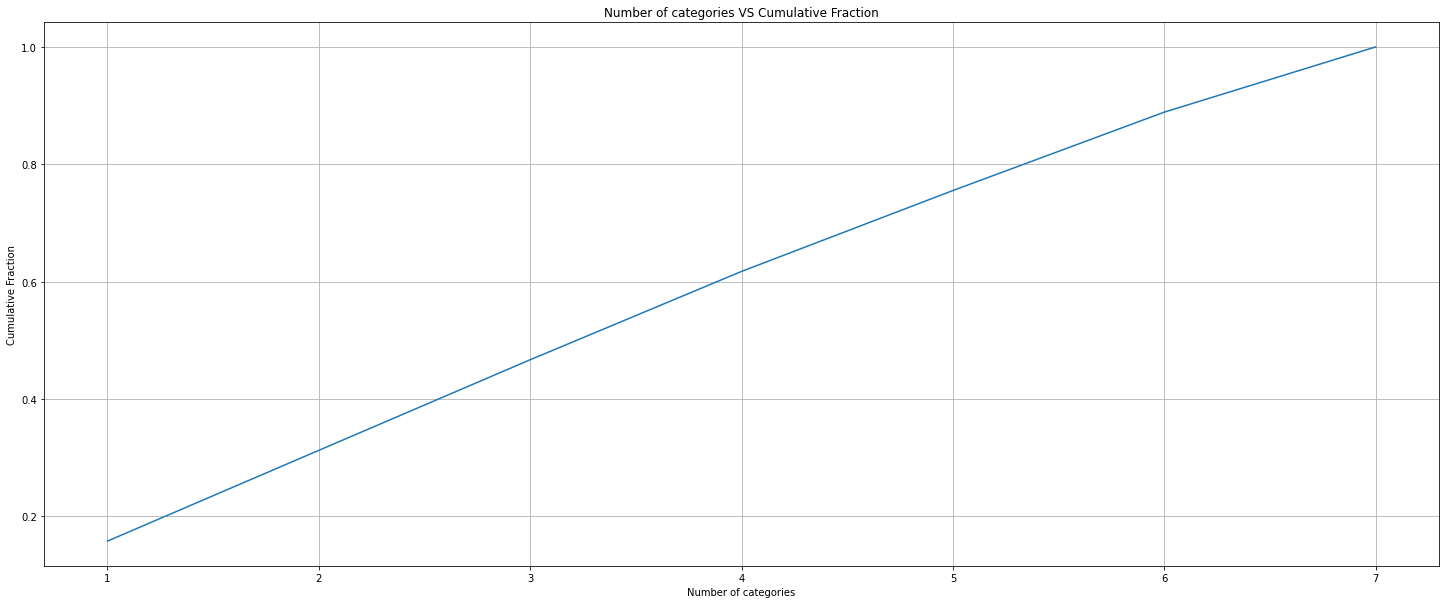

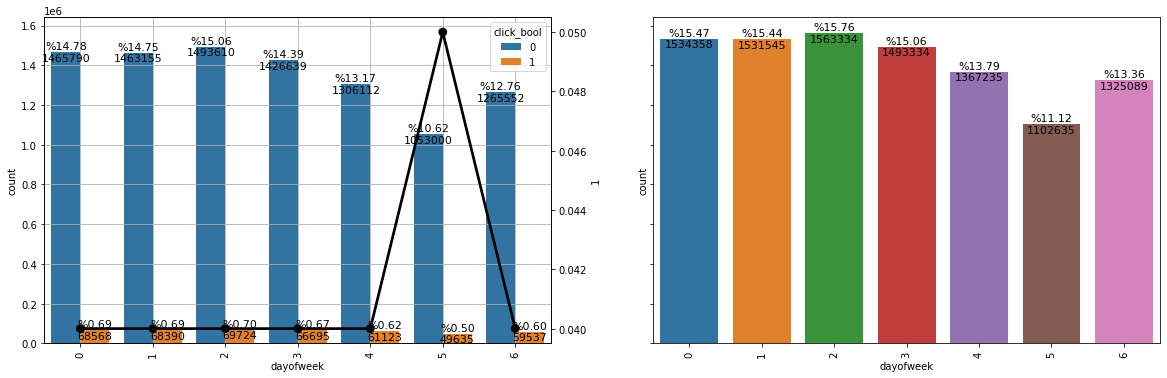

In [142]:
df = train
target = 'click_bool'
for col in sparse_features:
    print('='*20)
    print(f"col: {col}")
    unique_num = len(df[col].unique())
    stats = value_count_stats(df=df, col=col)
    print(f"Unique number: {unique_num}")
    print('='*20)
    print()
    print("Top 5 (value: number):")
    print()
    print(stats.head(5))
    print()
    print("Bottom 5 (value: number):")
    print()
    print(stats.tail(5))
    stats_plot(stats=stats)
    cate_features_plot(df=df, col=col, target=target)

## Dense features

col: visitor_hist_starrating
Unique number: 326

Top 5 (value: number):

   visitor_hist_starrating  sample_num      frac    cumsum
0                      4.0       47756  0.004815  0.004815
1                      3.0       42316  0.004267  0.009082
2                      3.5       32356  0.003263  0.012345
3                      2.5       21159  0.002133  0.014478
4                      2.0       18166  0.001832  0.016310

Bottom 5 (value: number):

     visitor_hist_starrating  sample_num          frac    cumsum
320                     4.65          14  1.411642e-06  0.050946
321                     1.98          14  1.411642e-06  0.050948
322                     4.95           7  7.058209e-07  0.050949
323                     1.92           7  7.058209e-07  0.050949
324                     4.96           6  6.049893e-07  0.050950


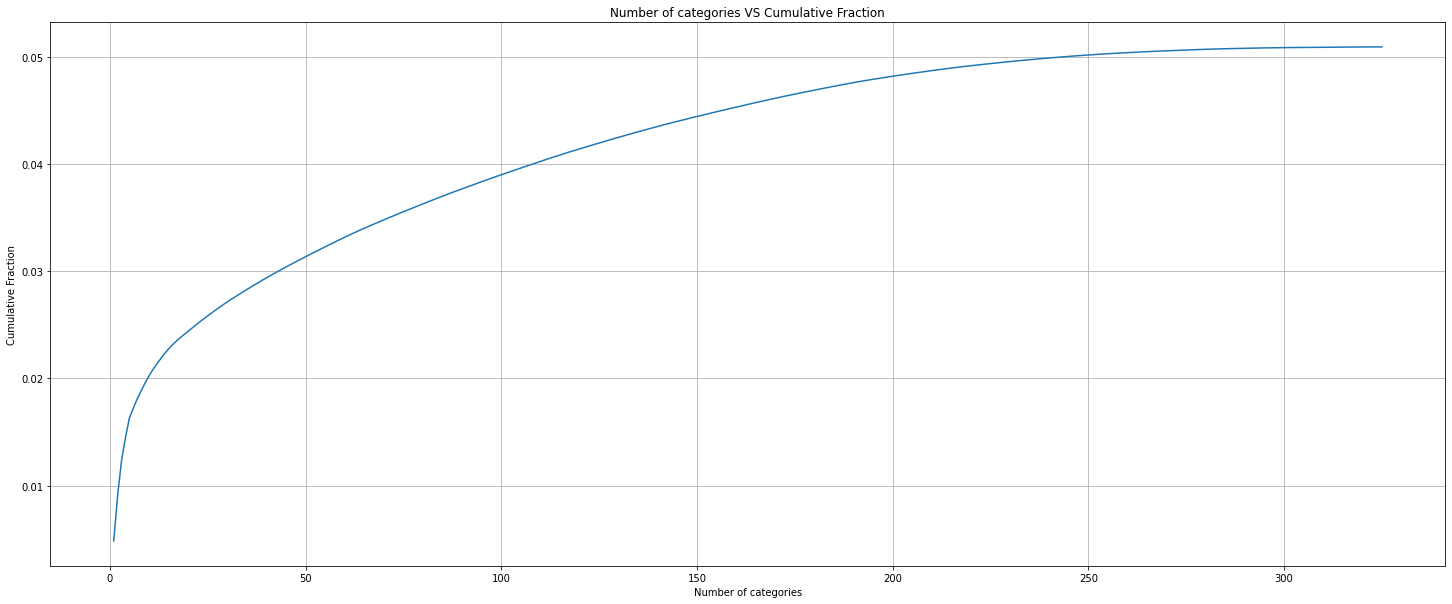

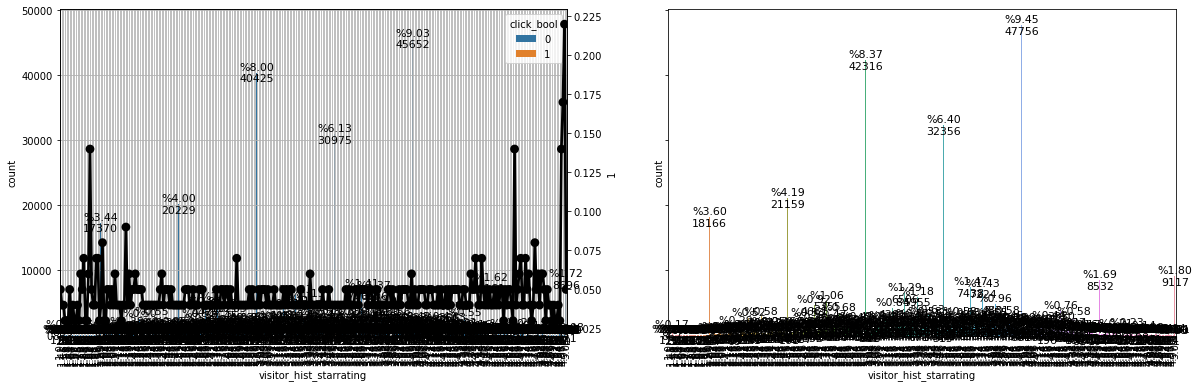

col: visitor_hist_adr_usd
Unique number: 12836

Top 5 (value: number):

   visitor_hist_adr_usd  sample_num      frac    cumsum
0                128.34        1469  0.000148  0.000148
1                117.68        1378  0.000139  0.000287
2                270.36        1008  0.000102  0.000389
3                117.86         711  0.000072  0.000460
4                210.38         505  0.000051  0.000511

Bottom 5 (value: number):

       visitor_hist_adr_usd  sample_num          frac    cumsum
12830                126.36           5  5.041578e-07  0.051181
12831                165.02           5  5.041578e-07  0.051182
12832                516.64           5  5.041578e-07  0.051182
12833                241.28           5  5.041578e-07  0.051183
12834                600.44           5  5.041578e-07  0.051183


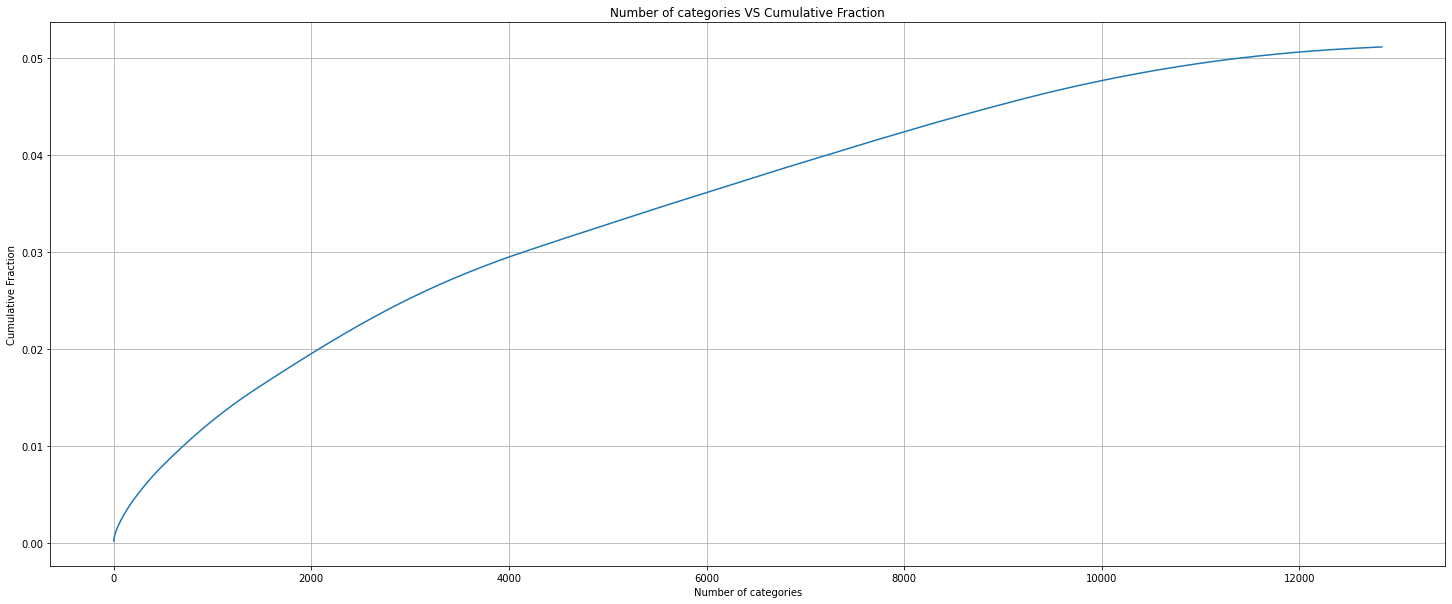

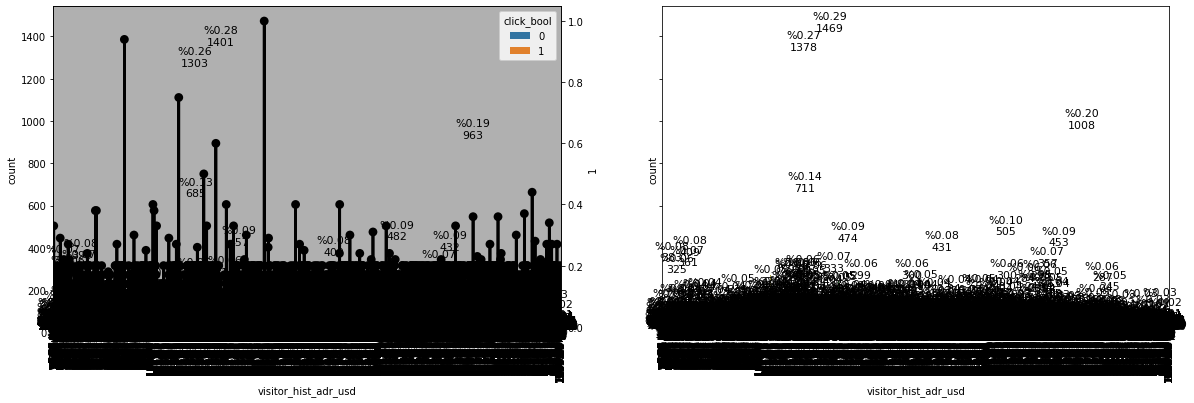

col: prop_starrating
Unique number: 6

Top 5 (value: number):

   prop_starrating  sample_num      frac    cumsum
0                3     3897419  0.392983  0.392983
1                4     3045848  0.307118  0.700100
2                2     1788994  0.180387  0.880487
3                5      812961  0.081972  0.962460
4                0      337794  0.034060  0.996520

Bottom 5 (value: number):

   prop_starrating  sample_num      frac    cumsum
1                4     3045848  0.307118  0.700100
2                2     1788994  0.180387  0.880487
3                5      812961  0.081972  0.962460
4                0      337794  0.034060  0.996520
5                1       34514  0.003480  1.000000


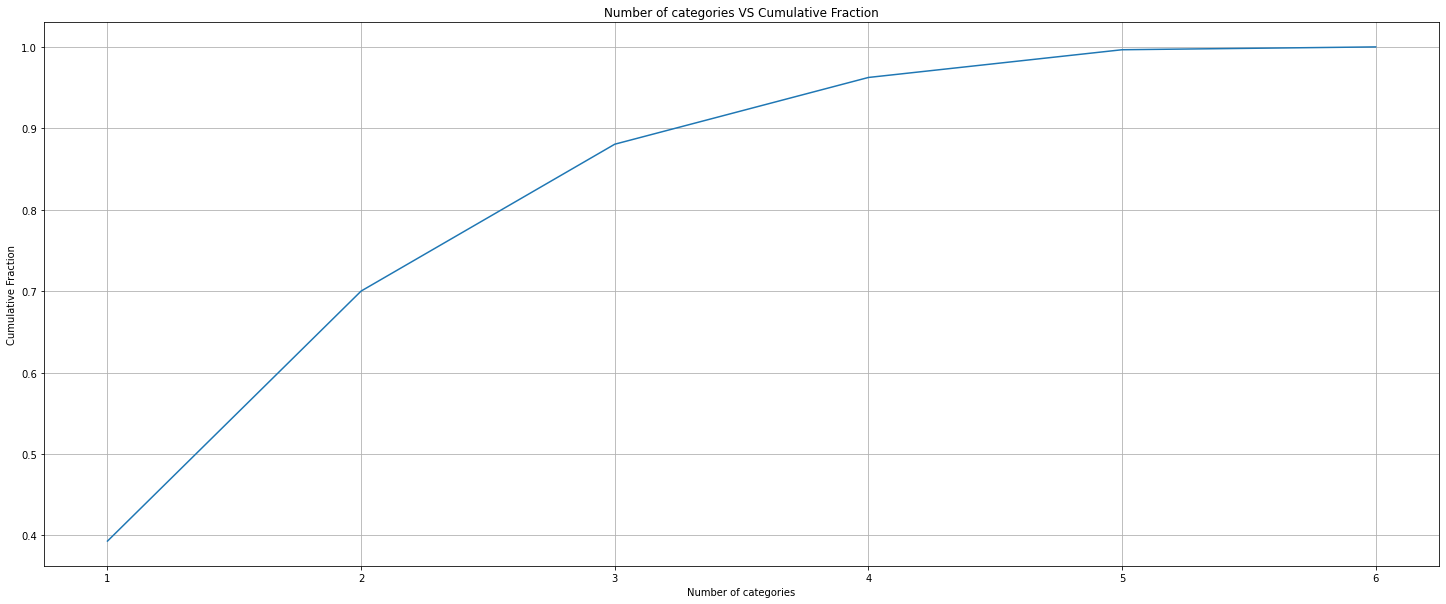

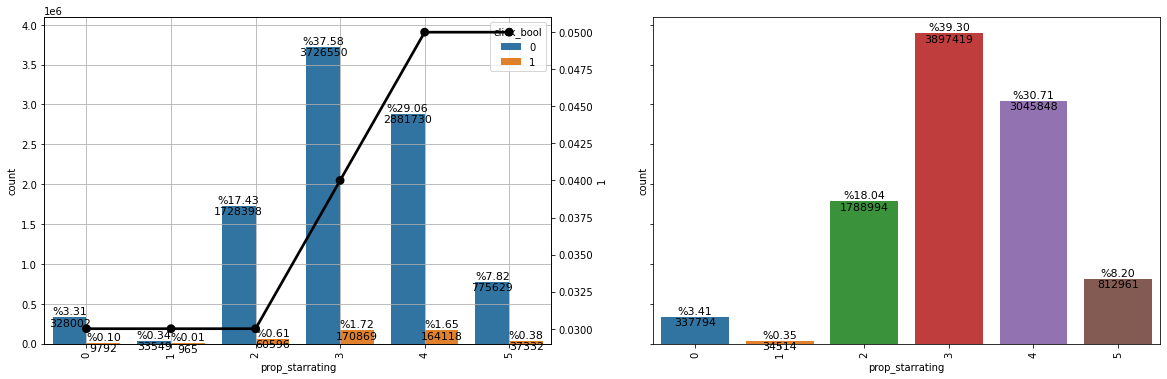

col: prop_review_score
Unique number: 11

Top 5 (value: number):

   prop_review_score  sample_num      frac    cumsum
0                4.0     3115351  0.314126  0.314126
1                4.5     3093746  0.311947  0.626073
2                3.5     1536219  0.154899  0.780972
3                3.0      750811  0.075705  0.856678
4                5.0      472194  0.047612  0.904290

Bottom 5 (value: number):

   prop_review_score  sample_num      frac    cumsum
5                0.0      467486  0.047137  0.951427
6                2.5      287427  0.028982  0.980409
7                2.0      124191  0.012522  0.992931
8                1.5       28706  0.002894  0.995826
9                1.0       26769  0.002699  0.998525


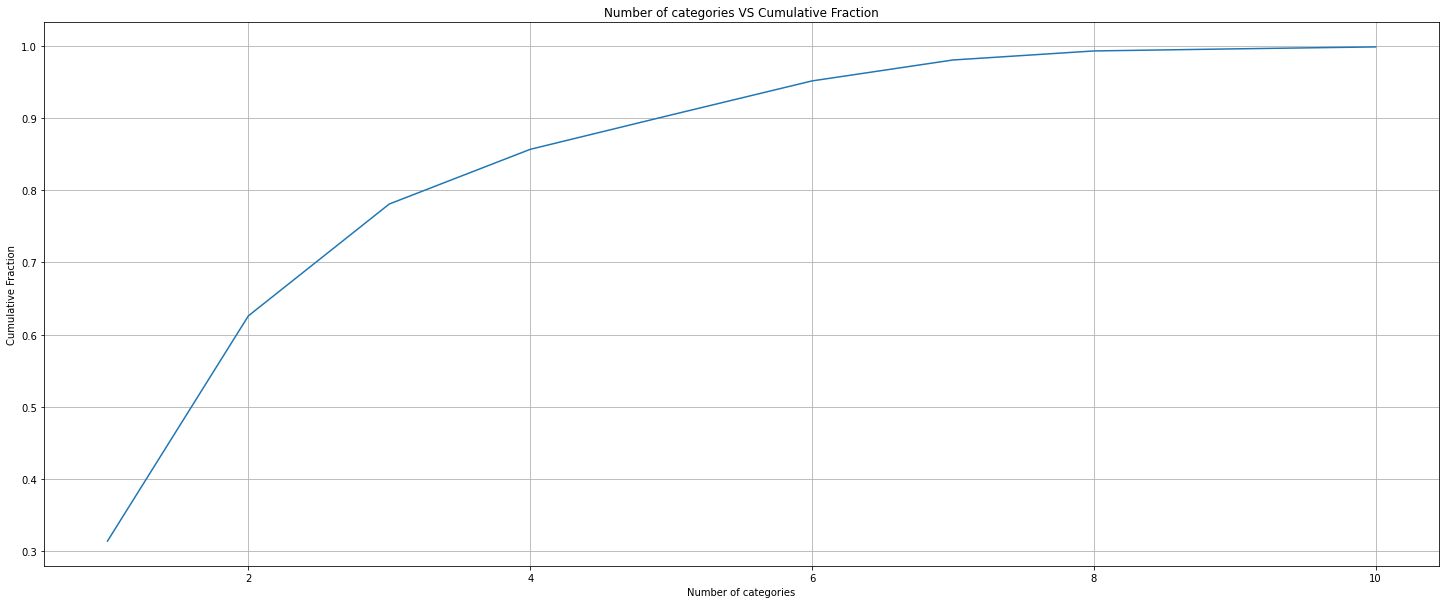

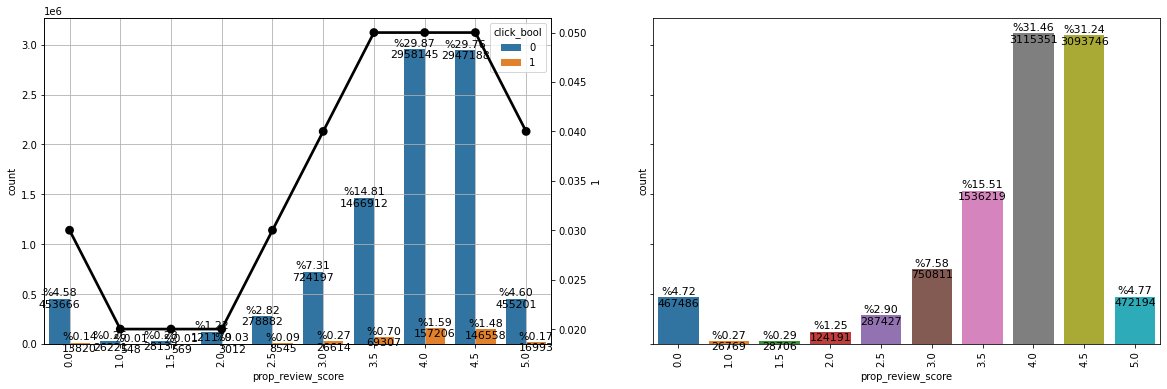

col: prop_location_score1
Unique number: 337

Top 5 (value: number):

   prop_location_score1  sample_num      frac    cumsum
0                  0.00      546041  0.055058  0.055058
1                  0.69      502481  0.050666  0.105724
2                  1.10      455694  0.045948  0.151672
3                  1.39      431791  0.043538  0.195211
4                  1.61      413462  0.041690  0.236901

Bottom 5 (value: number):

     prop_location_score1  sample_num      frac    cumsum
332                  6.66         100  0.000010  0.999973
333                  6.62          88  0.000009  0.999982
334                  6.63          80  0.000008  0.999990
335                  6.57          58  0.000006  0.999996
336                  6.96          42  0.000004  1.000000


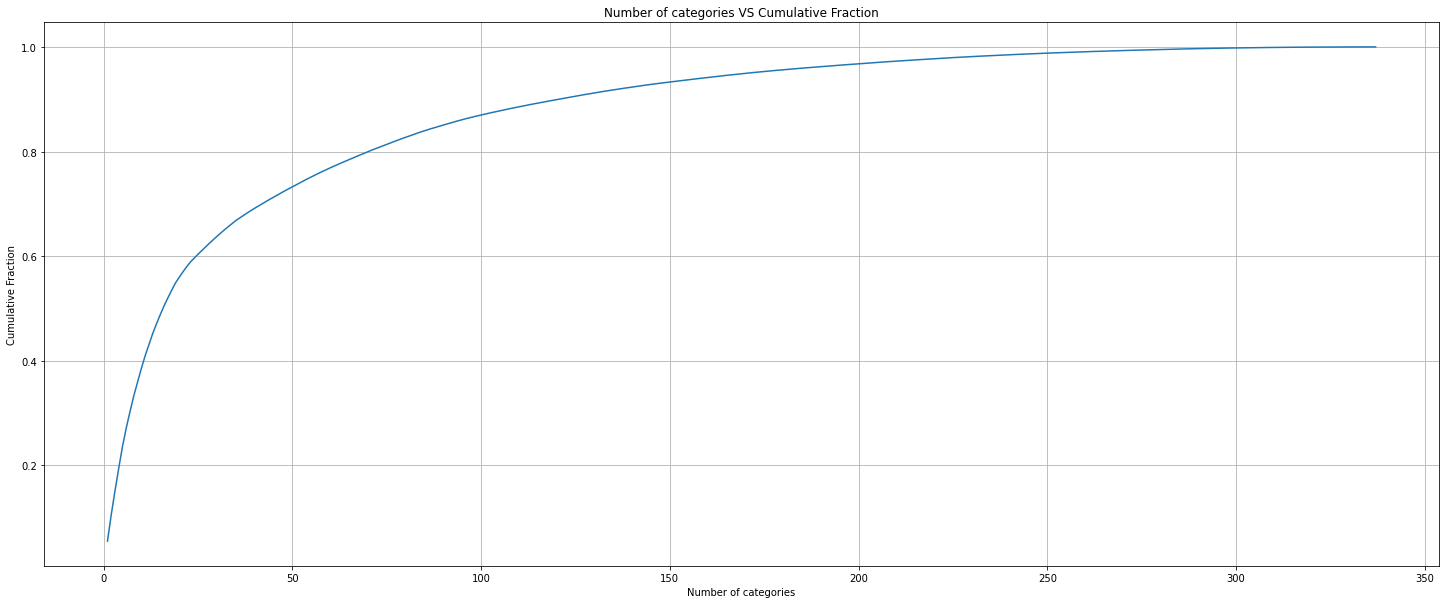

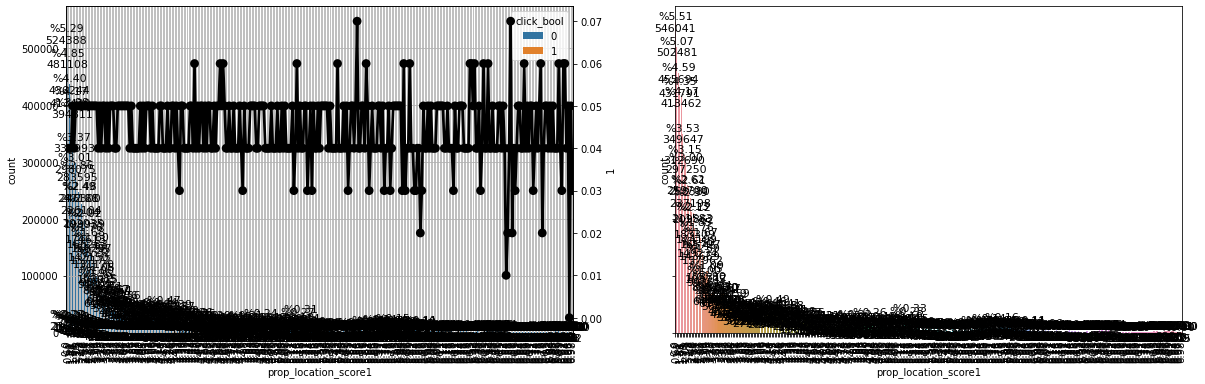

col: prop_location_score2
Unique number: 9541

Top 5 (value: number):

   prop_location_score2  sample_num      frac    cumsum
0                0.0002       26269  0.002649  0.002649
1                0.0004       25387  0.002560  0.005209
2                0.0001       24448  0.002465  0.007674
3                0.0003       23903  0.002410  0.010084
4                0.0005       23226  0.002342  0.012426

Bottom 5 (value: number):

      prop_location_score2  sample_num          frac    cumsum
9535                0.9760           1  1.008316e-07  0.780350
9536                0.6539           1  1.008316e-07  0.780350
9537                0.8922           1  1.008316e-07  0.780350
9538                0.6803           1  1.008316e-07  0.780350
9539                0.7854           1  1.008316e-07  0.780351


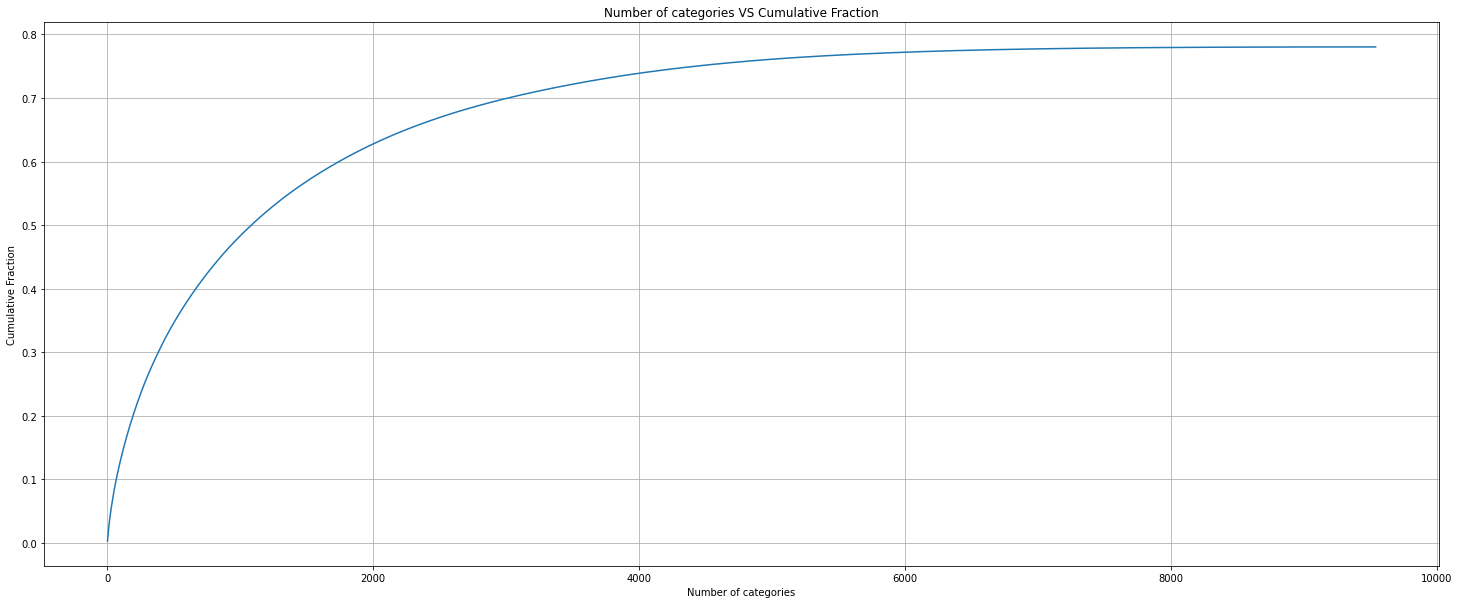

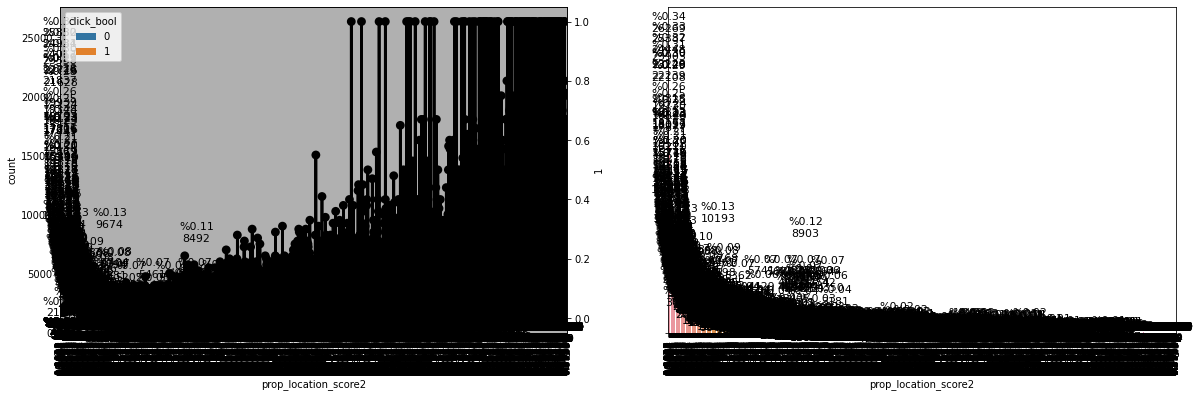

col: prop_log_historical_price
Unique number: 398

Top 5 (value: number):

   prop_log_historical_price  sample_num      frac    cumsum
0                       0.00     1430427  0.144232  0.144232
1                       6.21      177720  0.017920  0.162152
2                       5.02       72211  0.007281  0.169433
3                       5.07       70986  0.007158  0.176591
4                       4.98       70277  0.007086  0.183677

Bottom 5 (value: number):

     prop_log_historical_price  sample_num          frac  cumsum
393                       2.60           1  1.008316e-07     1.0
394                       2.41           1  1.008316e-07     1.0
395                       1.81           1  1.008316e-07     1.0
396                       2.07           1  1.008316e-07     1.0
397                       2.43           1  1.008316e-07     1.0


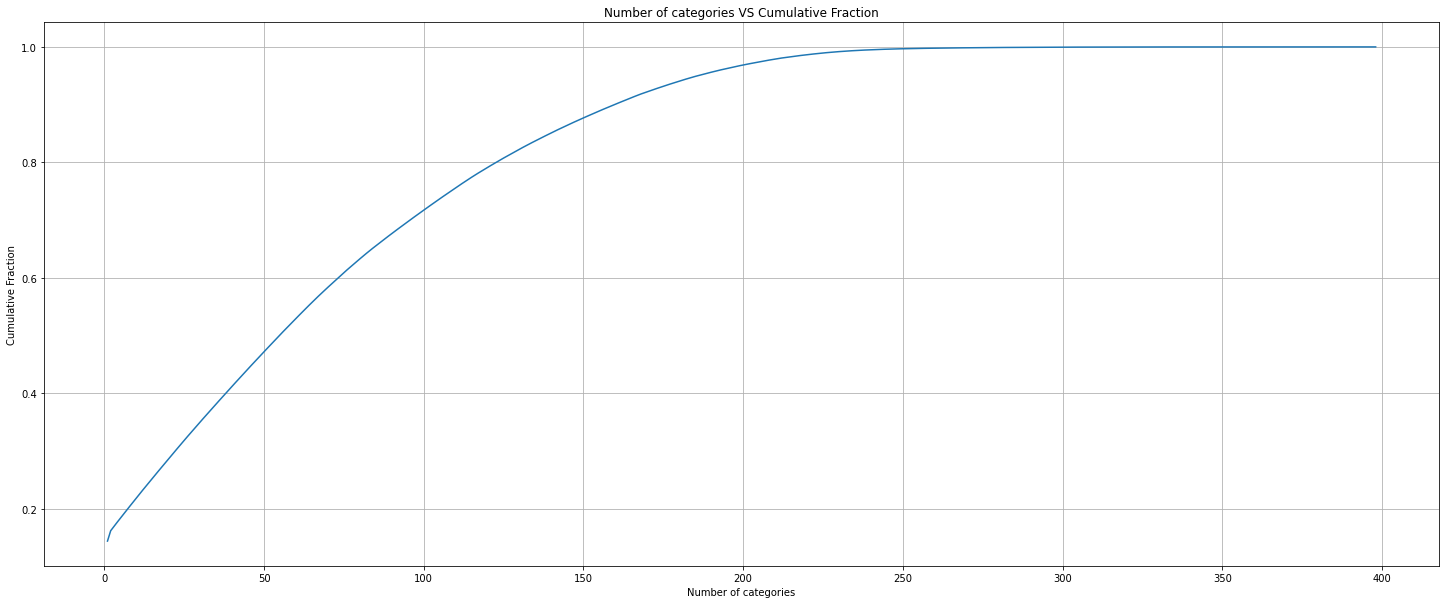

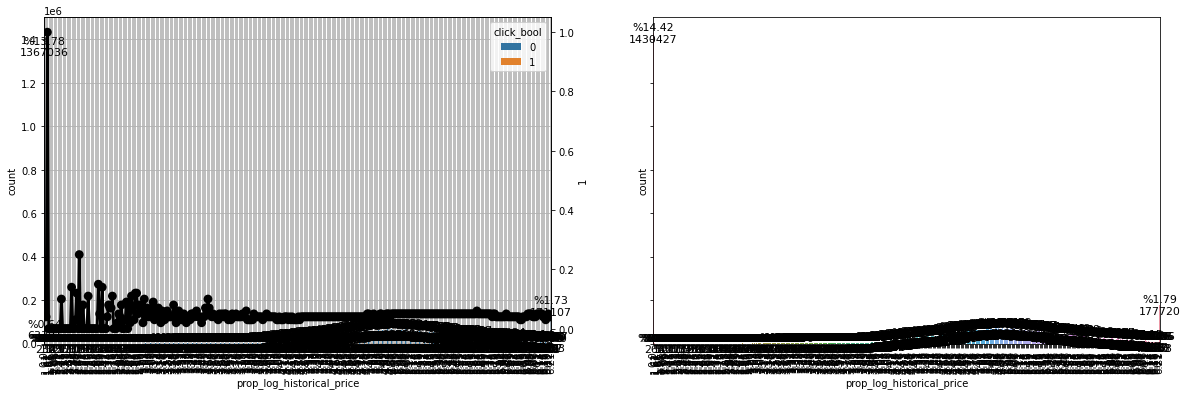

col: price_usd
Unique number: 92790

Top 5 (value: number):

   price_usd  sample_num      frac    cumsum
0       99.0      151496  0.015276  0.015276
1      119.0      129710  0.013079  0.028354
2      109.0      128222  0.012929  0.041283
3       89.0      124471  0.012551  0.053834
4      129.0      112602  0.011354  0.065188

Bottom 5 (value: number):

       price_usd  sample_num          frac  cumsum
92785    1419.40           1  1.008316e-07     1.0
92786    1631.82           1  1.008316e-07     1.0
92787     635.78           1  1.008316e-07     1.0
92788     725.25           1  1.008316e-07     1.0
92789     682.61           1  1.008316e-07     1.0


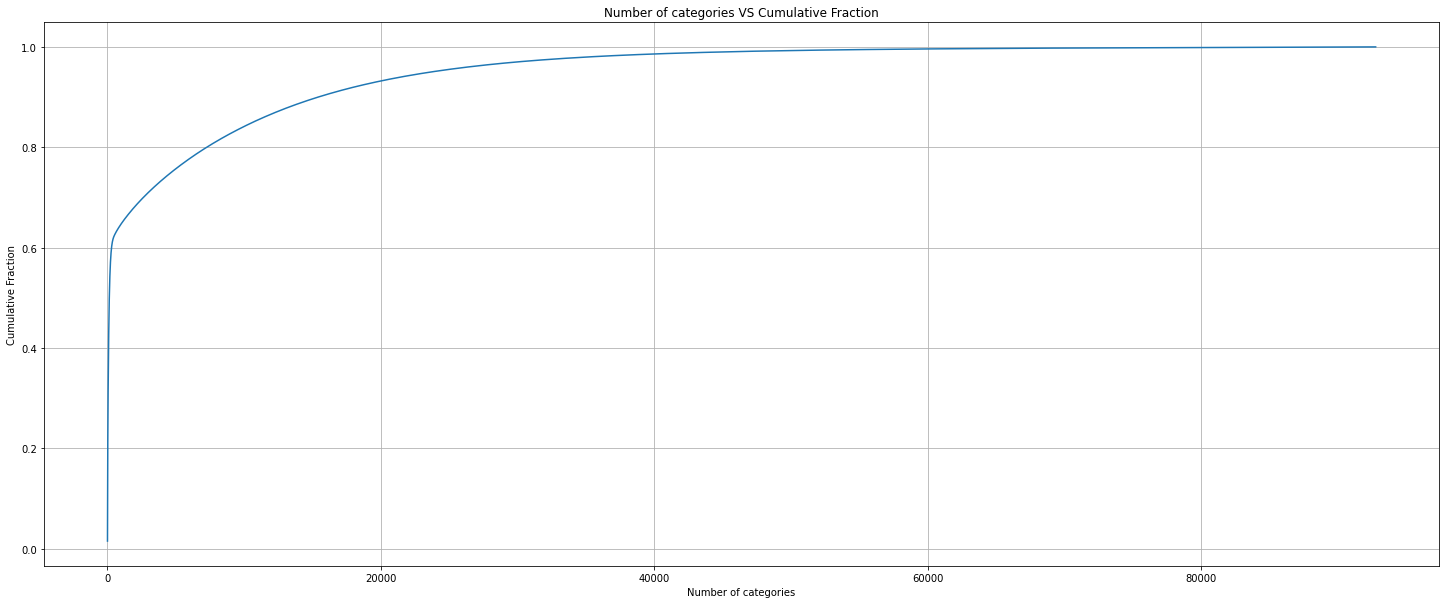

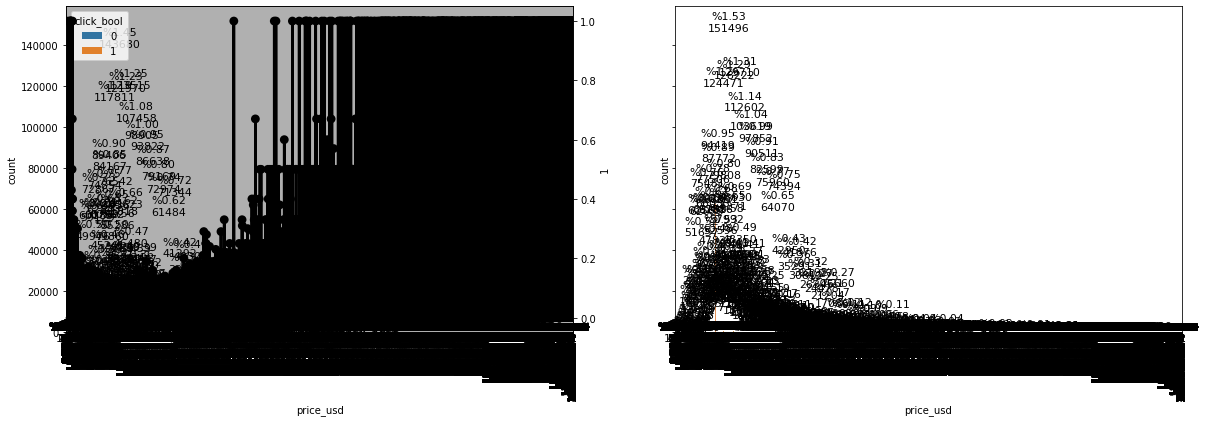

col: srch_length_of_stay
Unique number: 41

Top 5 (value: number):

   srch_length_of_stay  sample_num      frac    cumsum
0                    1     4289202  0.432487  0.432487
1                    2     2389470  0.240934  0.673421
2                    3     1439684  0.145166  0.818586
3                    4      753222  0.075949  0.894535
4                    5      375927  0.037905  0.932440

Bottom 5 (value: number):

    srch_length_of_stay  sample_num          frac    cumsum
36                   38          28  2.823284e-06  0.999996
37                   44          22  2.218294e-06  0.999998
38                   41          10  1.008316e-06  0.999999
39                   57           7  7.058209e-07  0.999999
40                   59           5  5.041578e-07  1.000000


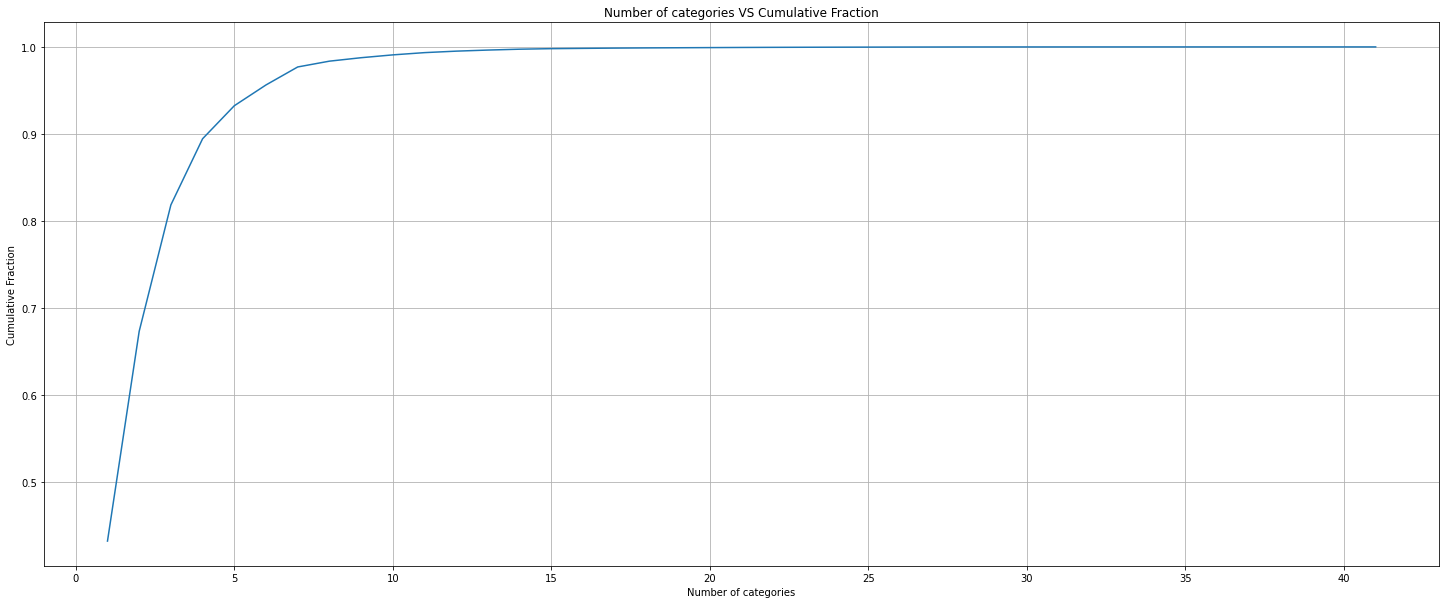

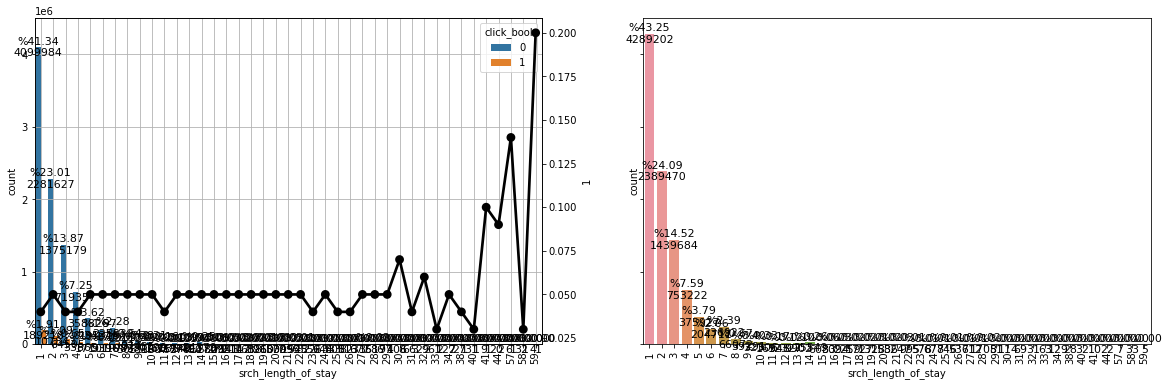

col: srch_booking_window
Unique number: 448

Top 5 (value: number):

   srch_booking_window  sample_num      frac    cumsum
0                    1      744507  0.075070  0.075070
1                    0      556154  0.056078  0.131148
2                    2      483584  0.048761  0.179908
3                    3      407449  0.041084  0.220992
4                    4      361577  0.036458  0.257450

Bottom 5 (value: number):

     srch_booking_window  sample_num          frac    cumsum
443                  389           5  5.041578e-07  0.999998
444                  382           5  5.041578e-07  0.999998
445                  421           5  5.041578e-07  0.999999
446                  433           5  5.041578e-07  0.999999
447                  403           5  5.041578e-07  1.000000


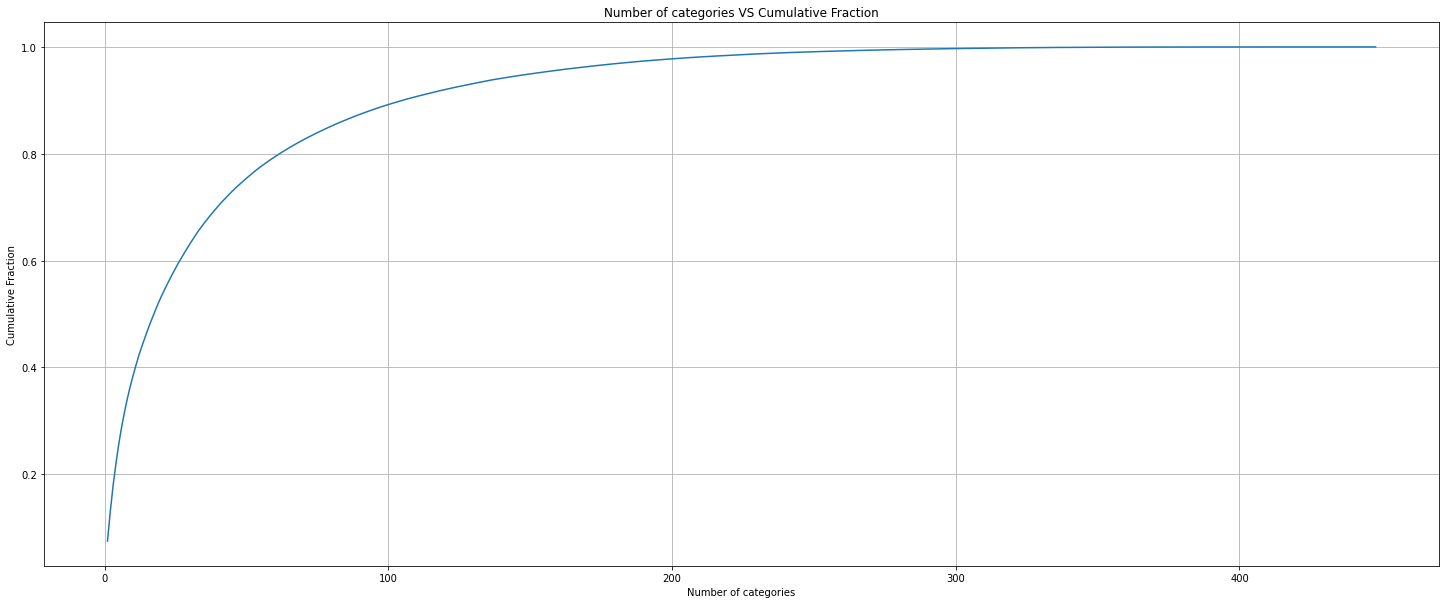

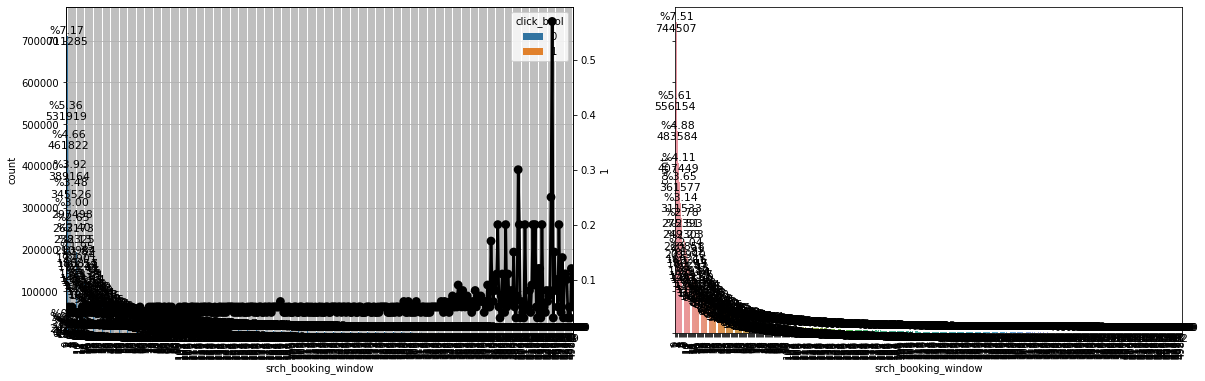

col: srch_adults_count
Unique number: 9

Top 5 (value: number):

   srch_adults_count  sample_num      frac    cumsum
0                  2     6494969  0.654898  0.654898
1                  1     2315541  0.233480  0.888377
2                  4      481440  0.048544  0.936922
3                  3      475287  0.047924  0.984846
4                  6       63323  0.006385  0.991231

Bottom 5 (value: number):

   srch_adults_count  sample_num      frac    cumsum
4                  6       63323  0.006385  0.991231
5                  5       54180  0.005463  0.996694
6                  8       20371  0.002054  0.998748
7                  7        9693  0.000977  0.999725
8                  9        2726  0.000275  1.000000


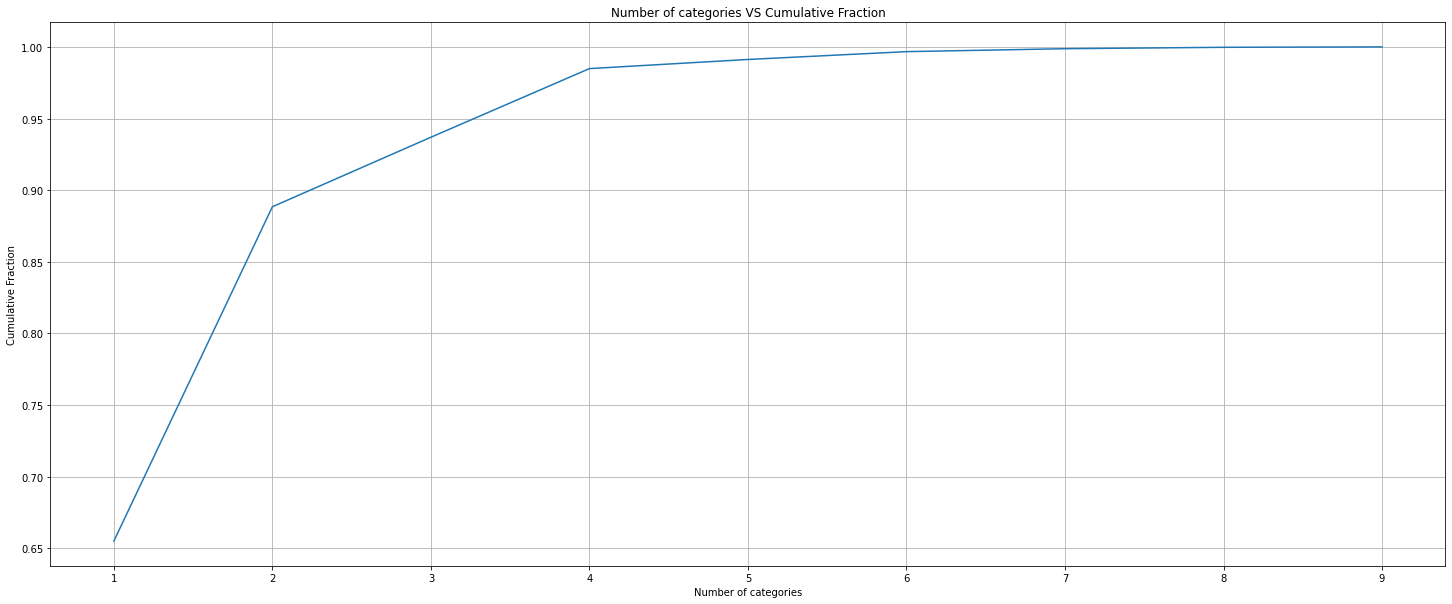

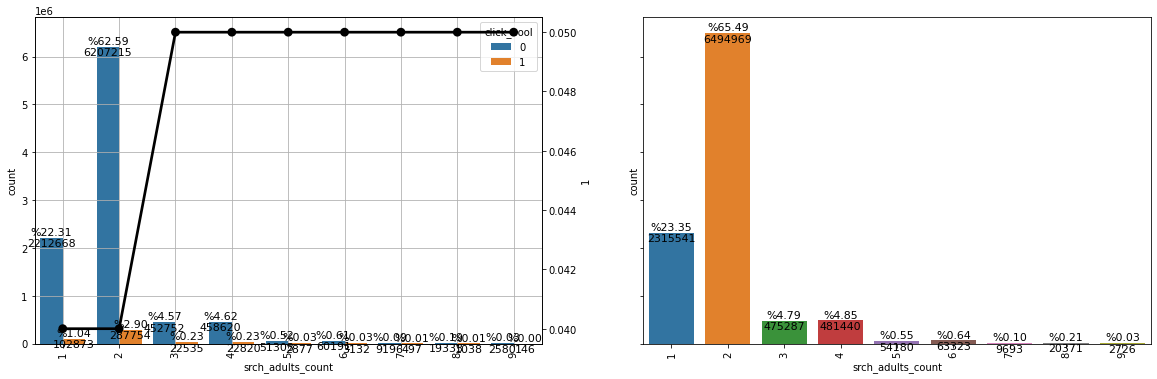

col: srch_children_count
Unique number: 10

Top 5 (value: number):

   srch_children_count  sample_num      frac    cumsum
0                    0     7630745  0.769420  0.769420
1                    1     1350942  0.136218  0.905637
2                    2      771090  0.077750  0.983388
3                    3      114785  0.011574  0.994962
4                    4       38079  0.003840  0.998801

Bottom 5 (value: number):

   srch_children_count  sample_num      frac    cumsum
5                    5        5856  0.000590  0.999392
6                    6        4111  0.000415  0.999806
7                    8        1010  0.000102  0.999908
8                    7         728  0.000073  0.999981
9                    9         184  0.000019  1.000000


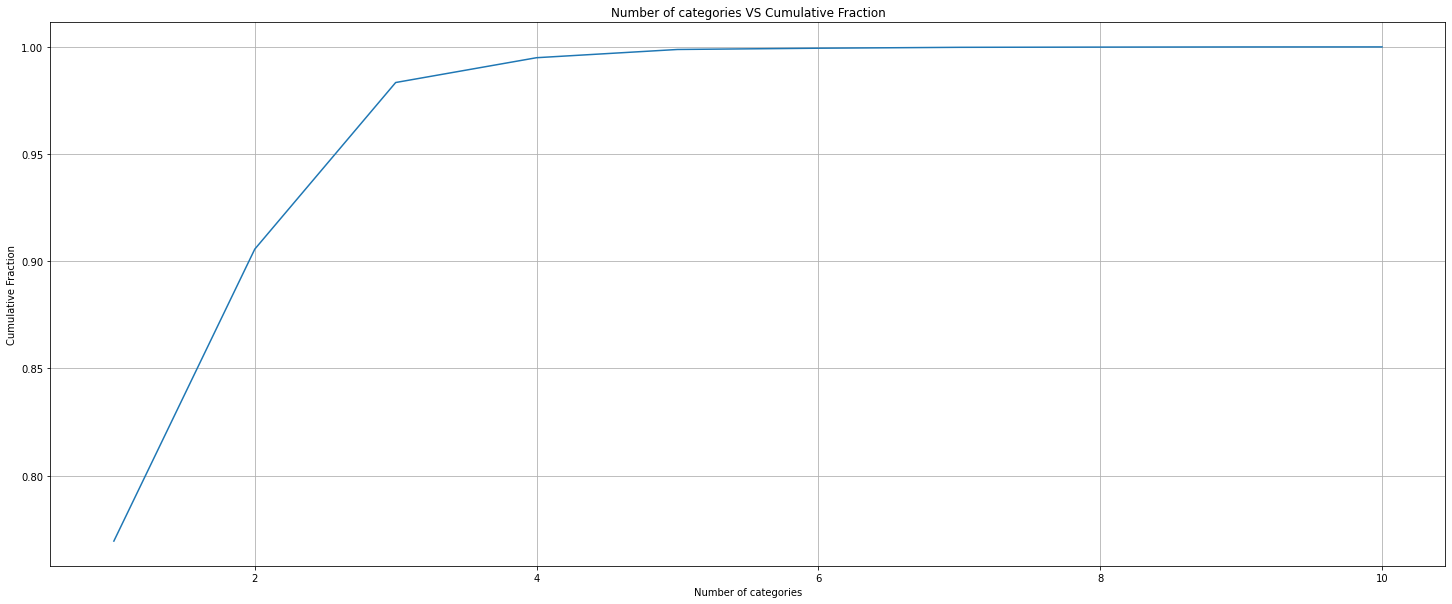

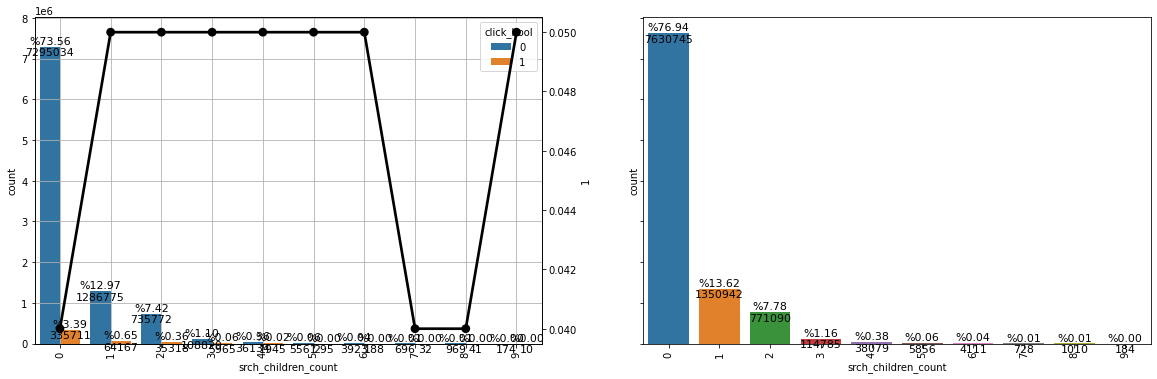

col: srch_room_count
Unique number: 8

Top 5 (value: number):

   srch_room_count  sample_num      frac    cumsum
0                1     9045780  0.912100  0.912100
1                2      734315  0.074042  0.986142
2                3       92372  0.009314  0.995456
3                4       25023  0.002523  0.997979
4                5        8053  0.000812  0.998791

Bottom 5 (value: number):

   srch_room_count  sample_num      frac    cumsum
3                4       25023  0.002523  0.997979
4                5        8053  0.000812  0.998791
5                8        4950  0.000499  0.999290
6                6        4345  0.000438  0.999729
7                7        2692  0.000271  1.000000


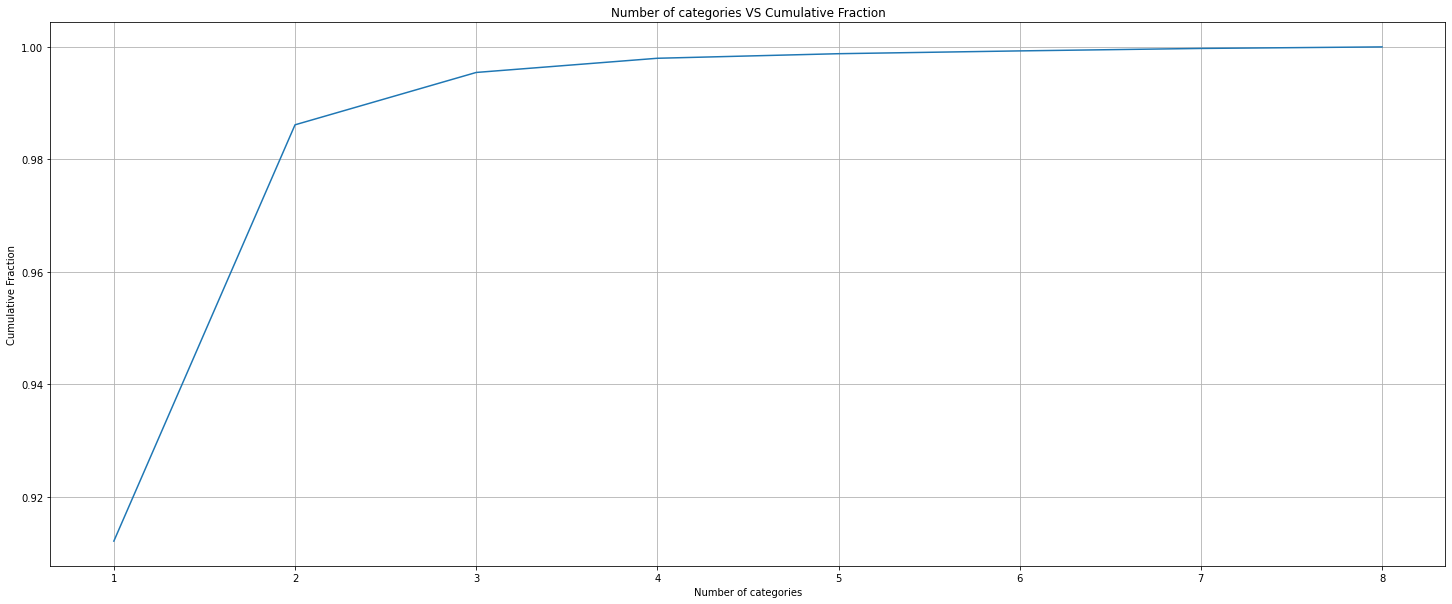

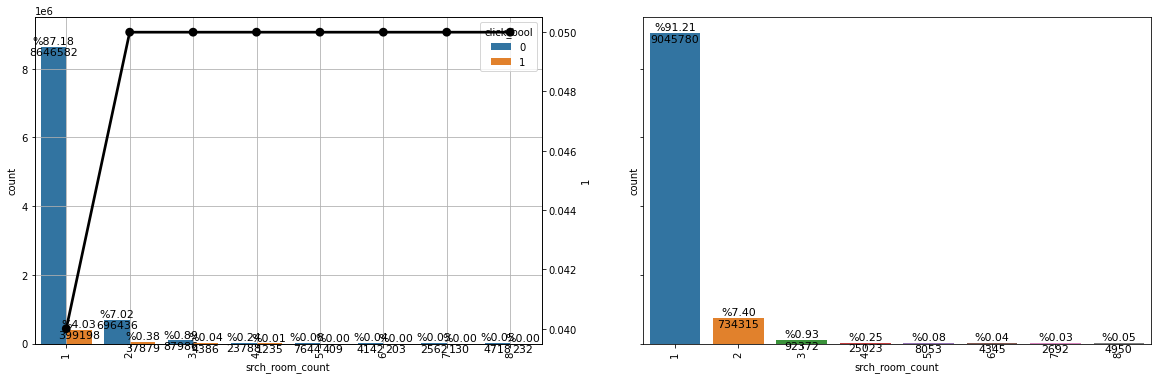

col: srch_query_affinity_score
Unique number: 305668

Top 5 (value: number):

   srch_query_affinity_score  sample_num      frac    cumsum
0                    -6.2064         382  0.000039  0.000039
1                    -6.1394         381  0.000038  0.000077
2                    -6.6835         328  0.000033  0.000110
3                    -6.2856         316  0.000032  0.000142
4                    -6.5074         315  0.000032  0.000174

Bottom 5 (value: number):

        srch_query_affinity_score  sample_num          frac    cumsum
305662                   -29.2937           1  1.008316e-07  0.064085
305663                   -20.3354           1  1.008316e-07  0.064085
305664                   -29.1165           1  1.008316e-07  0.064085
305665                   -25.1975           1  1.008316e-07  0.064085
305666                   -30.6797           1  1.008316e-07  0.064085


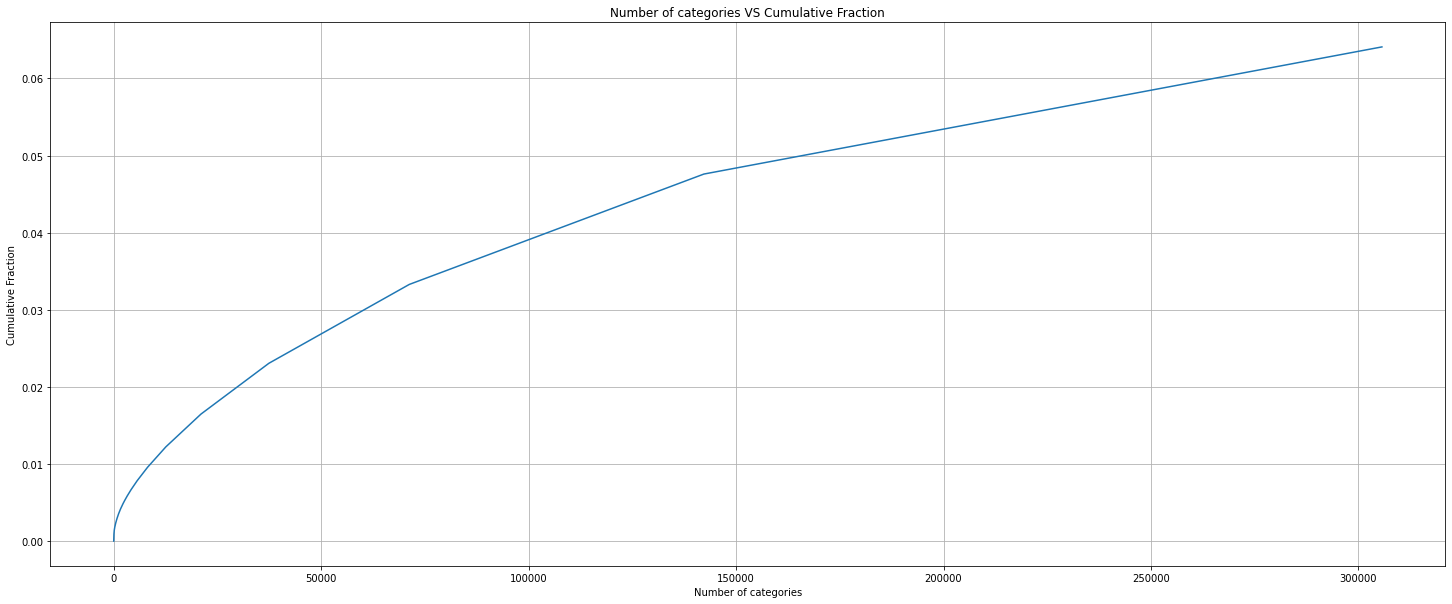

KeyboardInterrupt: 

In [143]:
df = train
target = 'click_bool'
for col in dense_features:
    print('='*20)
    print(f"col: {col}")
    unique_num = len(df[col].unique())
    stats = value_count_stats(df=df, col=col)
    print(f"Unique number: {unique_num}")
    print('='*20)
    print()
    print("Top 5 (value: number):")
    print()
    print(stats.head(5))
    print()
    print("Bottom 5 (value: number):")
    print()
    print(stats.tail(5))
    stats_plot(stats=stats)
    cate_features_plot(df=df, col=col, target=target)

## Position Bias 

In [191]:
rename_map = {
    'click_bool': 'position_ctr'
    , 'booking_bool': 'position_ctcvr'
    , 'label': 'position_reg_label'
    
}

rename_map2 = {
    "click_bool": 'position_cnt'
}

position_stats = train.groupby('position')['click_bool', 'booking_bool', regression_label].mean().reset_index().rename(columns=rename_map)
# .agg({'click_bool': ['count', 'mean'], 'booking_bool': ['mean'], regression_label: ['mean']})
# ['click_bool'].apply([np.mean()])
position_count = train.groupby('position')['click_bool'].count().reset_index().rename(columns=rename_map2)

<ipython-input-191-290cb56445ee>:12: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  position_stats = train.groupby('position')['click_bool', 'booking_bool', regression_label].mean().reset_index().rename(columns=rename_map)


In [195]:
position_stats = position_stats.merge(position_count, how='left', on='position')

In [202]:
position_stats.columns

[autoreload of scripts.train_config failed: Traceback (most recent call last):
  File "/Users/mac/opt/miniconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/mac/opt/miniconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/mac/opt/miniconda3/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/mac/opt/miniconda3/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 855, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/mac/Documents/guohua/ongoing_code_project/expedia_hotel_recommendation/notebooks/../scripts/train_config.py", line 8, in <module>
    from src.

Index(['position', 'position_ctr', 'position_ctcvr', 'position_reg_label',
       'position_cnt'],
      dtype='object')

In [196]:
position_stats

position  position_ctr  position_ctcvr  position_reg_label  position_cnt
0          1      0.193186        0.141388            0.810537        398569
1          2      0.134852        0.094671            0.553716        398466
2          3      0.105525        0.071689            0.426117        398484
3          4      0.087763        0.057602            0.348332        386427
4          5      0.023065        0.011452            0.080484         18600
5          6      0.071045        0.045016            0.277139        398100
6          7      0.060276        0.037362            0.232638        389223
7          8      0.052634        0.032067            0.201469        380362
8          9      0.046458        0.027333            0.174914        372011
9         10      0.043611        0.025582            0.163969        346767
10        11      0.008734        0.003225            0.027142         22327
11        12      0.037336        0.021547            0.139313        356334
12        13      0.034074        0.019012            0.125182        349420
13        14      0.030946        0.017175            0.113415        342018
14        15      0.029259        0.016037            0.106629        334908
15        16      0.028183        0.014878            0.101001        309373
16        17      0.004356        0.001422            0.012979         22498
17        18      0.024641        0.013043            0.088411        321012
18        19      0.022964        0.011943            0.081758        314403
19        20      0.022021        0.011070            0.077252        307848
20        21      0.020519        0.010268            0.071840        301142
21        22      0.019995        0.009562            0.068675        276418
22        23      0.003636        0.001119            0.010627         21455
23        24      0.018245        0.008955            0.063356        287645
24        25      0.016651        0.008167            0.057803        280764
25        26      0.016354        0.007870            0.056319        274062
26        27      0.015665        0.007433            0.053628        267471
27        28      0.014592        0.006821            0.049645        260971
28        29      0.013660        0.006112            0.045657        254091
29        30      0.013315        0.005823            0.044100        246420
30        31      0.012973        0.005776            0.043272        237728
31        32      0.012188        0.005305            0.040291        223573
32        33      0.012118        0.005286            0.040092        211511
33        34      0.011744        0.005153            0.038947        198733
34        35      0.011051        0.004689            0.036170        175726
35        36      0.010024        0.004662            0.034034        134277
36        37      0.009714        0.004660            0.033409         73813
37        38      0.008608        0.004912            0.031952         21376
38        39      0.009109        0.004554            0.031880          3074
39        40      0.007692        0.007692            0.038462           130

In [199]:
position_stats.to_csv(os.path.join(base_dir, position_feature_path), index=False)

In [1]:
import pandas as pd

In [2]:
position_stats = pd.read_csv('../data/offline_features/production/position_feature.csv')

In [3]:
position_stats

position  position_ctr  position_ctcvr  position_reg_label  position_cnt
0          1      0.193186        0.141388            0.810537        398569
1          2      0.134852        0.094671            0.553716        398466
2          3      0.105525        0.071689            0.426117        398484
3          4      0.087763        0.057602            0.348332        386427
4          5      0.023065        0.011452            0.080484         18600
5          6      0.071045        0.045016            0.277139        398100
6          7      0.060276        0.037362            0.232638        389223
7          8      0.052634        0.032067            0.201469        380362
8          9      0.046458        0.027333            0.174914        372011
9         10      0.043611        0.025582            0.163969        346767
10        11      0.008734        0.003225            0.027142         22327
11        12      0.037336        0.021547            0.139313        356334
12        13      0.034074        0.019012            0.125182        349420
13        14      0.030946        0.017175            0.113415        342018
14        15      0.029259        0.016037            0.106629        334908
15        16      0.028183        0.014878            0.101001        309373
16        17      0.004356        0.001422            0.012979         22498
17        18      0.024641        0.013043            0.088411        321012
18        19      0.022964        0.011943            0.081758        314403
19        20      0.022021        0.011070            0.077252        307848
20        21      0.020519        0.010268            0.071840        301142
21        22      0.019995        0.009562            0.068675        276418
22        23      0.003636        0.001119            0.010627         21455
23        24      0.018245        0.008955            0.063356        287645
24        25      0.016651        0.008167            0.057803        280764
25        26      0.016354        0.007870            0.056319        274062
26        27      0.015665        0.007433            0.053628        267471
27        28      0.014592        0.006821            0.049645        260971
28        29      0.013660        0.006112            0.045657        254091
29        30      0.013315        0.005823            0.044100        246420
30        31      0.012973        0.005776            0.043272        237728
31        32      0.012188        0.005305            0.040291        223573
32        33      0.012118        0.005286            0.040092        211511
33        34      0.011744        0.005153            0.038947        198733
34        35      0.011051        0.004689            0.036170        175726
35        36      0.010024        0.004662            0.034034        134277
36        37      0.009714        0.004660            0.033409         73813
37        38      0.008608        0.004912            0.031952         21376
38        39      0.009109        0.004554            0.031880          3074
39        40      0.007692        0.007692            0.038462           130

In [10]:
position_stats['position_weight'] = round(1/position_stats['position_reg_label'], 2)

In [11]:
position_stats

position  position_ctr  position_ctcvr  position_reg_label  position_cnt  \
0          1      0.193186        0.141388            0.810537        398569   
1          2      0.134852        0.094671            0.553716        398466   
2          3      0.105525        0.071689            0.426117        398484   
3          4      0.087763        0.057602            0.348332        386427   
4          5      0.023065        0.011452            0.080484         18600   
5          6      0.071045        0.045016            0.277139        398100   
6          7      0.060276        0.037362            0.232638        389223   
7          8      0.052634        0.032067            0.201469        380362   
8          9      0.046458        0.027333            0.174914        372011   
9         10      0.043611        0.025582            0.163969        346767   
10        11      0.008734        0.003225            0.027142         22327   
11        12      0.037336        0.021547            0.139313        356334   
12        13      0.034074        0.019012            0.125182        349420   
13        14      0.030946        0.017175            0.113415        342018   
14        15      0.029259        0.016037            0.106629        334908   
15        16      0.028183        0.014878            0.101001        309373   
16        17      0.004356        0.001422            0.012979         22498   
17        18      0.024641        0.013043            0.088411        321012   
18        19      0.022964        0.011943            0.081758        314403   
19        20      0.022021        0.011070            0.077252        307848   
20        21      0.020519        0.010268            0.071840        301142   
21        22      0.019995        0.009562            0.068675        276418   
22        23      0.003636        0.001119            0.010627         21455   
23        24      0.018245        0.008955            0.063356        287645   
24        25      0.016651        0.008167            0.057803        280764   
25        26      0.016354        0.007870            0.056319        274062   
26        27      0.015665        0.007433            0.053628        267471   
27        28      0.014592        0.006821            0.049645        260971   
28        29      0.013660        0.006112            0.045657        254091   
29        30      0.013315        0.005823            0.044100        246420   
30        31      0.012973        0.005776            0.043272        237728   
31        32      0.012188        0.005305            0.040291        223573   
32        33      0.012118        0.005286            0.040092        211511   
33        34      0.011744        0.005153            0.038947        198733   
34        35      0.011051        0.004689            0.036170        175726   
35        36      0.010024        0.004662            0.034034        134277   
36        37      0.009714        0.004660            0.033409         73813   
37        38      0.008608        0.004912            0.031952         21376   
38        39      0.009109        0.004554            0.031880          3074   
39        40      0.007692        0.007692            0.038462           130   

    position_weight  
0              1.23  
1              1.81  
2              2.35  
3              2.87  
4             12.42  
5              3.61  
6              4.30  
7              4.96  
8              5.72  
9              6.10  
10            36.84  
11             7.18  
12             7.99  
13             8.82  
14             9.38  
15             9.90  
16            77.05  
17            11.31  
18            12.23  
19            12.94  
20            13.92  
21            14.56  
22            94.10  
23            15.78  
24            17.30  
25            17.76  
26            18.65  
27            20.14  
28            21.90  
29            22.68  
30            23.11  
31            24.82

In [12]:
dic = dict(zip(position_stats['position'], position_stats['position_weight']))

In [13]:
dic

{1: 1.23,
 2: 1.81,
 3: 2.35,
 4: 2.87,
 5: 12.42,
 6: 3.61,
 7: 4.3,
 8: 4.96,
 9: 5.72,
 10: 6.1,
 11: 36.84,
 12: 7.18,
 13: 7.99,
 14: 8.82,
 15: 9.38,
 16: 9.9,
 17: 77.05,
 18: 11.31,
 19: 12.23,
 20: 12.94,
 21: 13.92,
 22: 14.56,
 23: 94.1,
 24: 15.78,
 25: 17.3,
 26: 17.76,
 27: 18.65,
 28: 20.14,
 29: 21.9,
 30: 22.68,
 31: 23.11,
 32: 24.82,
 33: 24.94,
 34: 25.68,
 35: 27.65,
 36: 29.38,
 37: 29.93,
 38: 31.3,
 39: 31.37,
 40: 26.0}

## TODO Item CTR 

In [175]:
stats = train.groupby(['prop_id', 'position']).agg({'click_bool': ['count', 'mean'], 'booking_bool': ['mean'], regression_label: ['mean']})
# ['click_bool'].apply([np.mean()])

In [177]:
stats

click_bool      booking_bool label
                      count mean         mean  mean
prop_id position                                   
1       4                 1  0.0          0.0   0.0
        6                 1  0.0          0.0   0.0
        8                 1  1.0          0.0   2.0
        10                2  0.0          0.0   0.0
        12                1  0.0          0.0   0.0
...                     ...  ...          ...   ...
140821  7                 2  0.0          0.0   0.0
        8                 1  0.0          0.0   0.0
        9                 1  0.0          0.0   0.0
        12                2  0.0          0.0   0.0
        22                1  0.0          0.0   0.0

[2104203 rows x 4 columns]

In [182]:
stats['click_bool']['count'].describe([0.05*i for i in range(20)])

count    2.104203e+06
mean     4.713200e+00
std      8.303867e+00
min      1.000000e+00
0%       1.000000e+00
5%       1.000000e+00
10%      1.000000e+00
15%      1.000000e+00
20%      1.000000e+00
25%      1.000000e+00
30%      1.000000e+00
35%      1.000000e+00
40%      2.000000e+00
45%      2.000000e+00
50%      2.000000e+00
55%      3.000000e+00
60%      3.000000e+00
65%      4.000000e+00
70%      4.000000e+00
75%      5.000000e+00
80%      6.000000e+00
85%      8.000000e+00
90%      1.000000e+01
95%      1.600000e+01
max      6.620000e+02
Name: count, dtype: float64

[autoreload of scripts.train_config failed: Traceback (most recent call last):
  File "/Users/mac/opt/miniconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/mac/opt/miniconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/mac/opt/miniconda3/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/mac/opt/miniconda3/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 855, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/mac/Documents/guohua/ongoing_code_project/expedia_hotel_recommendation/notebooks/../scripts/train_config.py", line 9, in <module>
    from src.